In [ ]:
# pip install gym

In [ ]:
# pip install gym_anytrading

In [ ]:
# pip install stable_baselines3

In [ ]:
# pip install shimmy>=2.0

In [1]:
from typing import Dict, Tuple, List, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
from gym import spaces
from gym.utils import seeding

from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

# import gym_anytrading
# from gym_anytrading.envs import StocksEnv

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 178, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 63, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

### Heston simulation Function

# Environment

In [2]:
def heston_model_sim(
    S0, V0, rho, theta, sigma, kappa, r, q,
    T, n_paths, n_steps, SEED=None
):
    """
    Simulate asset price paths using the Heston stochastic volatility model
    (Euler discretisation, risk‐neutral measure).
    
    Parameters
    ----------
    S0 : float
        Initial stock price
    V0 : float
        Initial variance
    rho : float
        Correlation between stock returns and variance
    theta : float
        Long-term mean variance
    sigma : float
        Volatility of variance ("vol of vol")
    kappa : float
        Rate of mean reversion of variance
    r : float
        Risk-free interest rate
    q : float
        Dividend yield
    T : float
        Time to maturity (years)
    n_paths : int
        Number of Monte Carlo paths
    n_steps : int
        Number of time steps
    SEED : int or None
        Random seed for reproducibility
    
    Returns
    -------
    S : ndarray, shape (n_steps, n_paths)
        Simulated stock price paths
    v : ndarray, shape (n_steps, n_paths)
        Simulated variance paths
    time : ndarray, shape (n_steps,)
        Time grid points
    """
    # time grid
    time, dt = np.linspace(0, T, n_steps, retstep=True)
    
    # set up RNG
    rng = np.random.default_rng(SEED)
    
    # covariance for correlated Brownian increments
    cov = np.array([[1, rho],
                    [rho, 1]])
    mean = np.array([0., 0.])
    
    # draw all increments at once: shape (n_steps-1, n_paths, 2)
    Z = rng.multivariate_normal(mean, cov, size=(n_steps-1, n_paths))
    
    # allocate
    S = np.zeros((n_steps, n_paths))
    v = np.zeros((n_steps, n_paths))
    S[0, :] = S0
    v[0, :] = V0
    
    # Euler‐Maruyama steps
    for t in range(1, n_steps):
        S_prev = S[t-1]
        v_prev = v[t-1]
        dW_s = Z[t-1, :, 0]
        dW_v = Z[t-1, :, 1]
        
        # stock price step under risk-neutral mu = r - q
        S[t] = S_prev * np.exp((r - q - 0.5 * v_prev) * dt
                                + np.sqrt(v_prev * dt) * dW_s)
        
        # variance step (absorbing at zero)
        v[t] = np.maximum(
            v_prev
            + kappa * (theta - v_prev) * dt
            + sigma * np.sqrt(v_prev * dt) * dW_v,
            0.0
        )
    
    return S, v, time

def plot_heston_paths(time, S, v, n_paths_to_plot=10, figsize=(14,6)):
    
    n_steps, n_paths = S.shape
    # pick evenly spaced indices if too many
    idx = np.linspace(0, n_paths-1, n_paths_to_plot, dtype=int)

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Stock price paths
    for i in idx:
        axes[0].plot(time, S[:, i], lw=1.6)
    axes[0].set_title(f"Stock Price Paths (n={n_paths_to_plot})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("S(t)")
    
    # Variance paths
    for i in idx:
        axes[1].plot(time, v[:, i], lw=1.6)
    axes[1].set_title(f"Variance Paths (n={n_paths_to_plot})")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("v(t)")
    
    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_policy(model, env, option_premium, n_paths=100, render_every=None, deterministic=True):
    """
    Roll out the policy on n_paths fresh simulations and return P&L distribution.

    Args:
        model: Trained model
        env: Environment to evaluate on
        n_paths: Number of paths to evaluate
        render_every: If provided, render every n paths
        deterministic: Whether to use deterministic actions

    Returns:
        Array of P&L values
    """
    pnl_list = []
    unhedged_pnl_list = []

    for i in range(n_paths):
        obs = env.reset()
        done = False

        # Optional rendering
        if render_every and i % render_every == 0:
            env.render(mode='human')

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, info = env.step(action)

            # Optional rendering of final state
            if render_every and i % render_every == 0 and done:
                env.render(mode='human')

        # Compute terminal P&L
        S_T = env.S_path[-1]
        payoff = max(S_T - option_params['K'], 0.0)
        portfolio_value = env.position * S_T + env.cash * np.exp(env.r * env.T)
        pnl = -payoff + portfolio_value + option_premium
        pnl_list.append(pnl)

        unhedged_pnl = -payoff + option_premium  # Just the premium received minus the payoff
        unhedged_pnl_list.append(unhedged_pnl)


        # Simple progress indicator
        if (i+1) % max(1, n_paths//10) == 0:
            print(f"Progress: {i+1}/{n_paths} paths evaluated")

    return np.array(pnl_list), np.array(unhedged_pnl_list)
    

def plot_pnl_distributions(hedged_pnl, unhedged_pnl):
    """
    Plot both hedged and unhedged P&L distributions with risk metrics.
    
    Args:
        hedged_pnl: Array of P&L values with hedging
        unhedged_pnl: Array of P&L values without hedging
    """
    # Calculate statistics for hedged P&L
    mean_hedged = np.mean(hedged_pnl)
    var_95_hedged = np.percentile(hedged_pnl, 5)  # 95% VaR (5th percentile)
    cvar_95_hedged = hedged_pnl[hedged_pnl <= var_95_hedged].mean()  # CVaR
    
    # Calculate statistics for unhedged P&L
    mean_unhedged = np.mean(unhedged_pnl)
    var_95_unhedged = np.percentile(unhedged_pnl, 5)  # 95% VaR
    cvar_95_unhedged = unhedged_pnl[unhedged_pnl <= var_95_unhedged].mean()  # CVaR
    
    # Create figure with two subplots (vertically stacked)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top plot - Hedged P&L
    ax1.hist(hedged_pnl, bins=15, alpha=0.75, color='blue')
    ax1.axvline(mean_hedged, color='k', linestyle='-', linewidth=2, label='Mean')
    ax1.axvline(var_95_hedged, color='r', linestyle='--', linewidth=2, label='VaR 95%')
    ax1.axvline(cvar_95_hedged, color='m', linestyle='--', linewidth=2, label='CVaR 95%')
    ax1.legend()
    ax1.set_title('Hedged P&L Distribution (Out-of-Sample)')
    ax1.set_xlabel('P&L')
    ax1.set_ylabel('Frequency')
    
    # Add text with stats in the top plot
    hedged_stats = (f"Mean: {mean_hedged:.4f}\n"
                   f"Std: {np.std(hedged_pnl):.4f}\n"
                   f"VaR 95%: {var_95_hedged:.4f}\n"
                   f"CVaR 95%: {cvar_95_hedged:.4f}")
    ax1.text(0.02, 0.95, hedged_stats, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Bottom plot - Unhedged P&L
    ax2.hist(unhedged_pnl, bins=15, alpha=0.75, color='red')
    ax2.axvline(mean_unhedged, color='k', linestyle='-', linewidth=2, label='Mean')
    ax2.axvline(var_95_unhedged, color='r', linestyle='--', linewidth=2, label='VaR 95%')
    ax2.axvline(cvar_95_unhedged, color='m', linestyle='--', linewidth=2, label='CVaR 95%')
    # ax2.legend()
    ax2.set_title('Unhedged P&L Distribution (Out-of-Sample)')
    ax2.set_xlabel('P&L')
    ax2.set_ylabel('Frequency')
    
    # Add text with stats in the bottom plot
    unhedged_stats = (f"Mean: {mean_unhedged:.4f}\n"
                     f"Std: {np.std(unhedged_pnl):.4f}\n"
                     f"VaR 95%: {var_95_unhedged:.4f}\n"
                     f"CVaR 95%: {cvar_95_unhedged:.4f}")
    ax2.text(0.02, 0.95, unhedged_stats, transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print(f"Risk Reduction from Hedging:")
    print(f"VaR Improvement: {var_95_unhedged - var_95_hedged:.4f}")
    print(f"CVaR Improvement: {cvar_95_unhedged - cvar_95_hedged:.4f}")
    print(f"Std Dev Reduction: {np.std(unhedged_pnl) - np.std(hedged_pnl):.4f}")

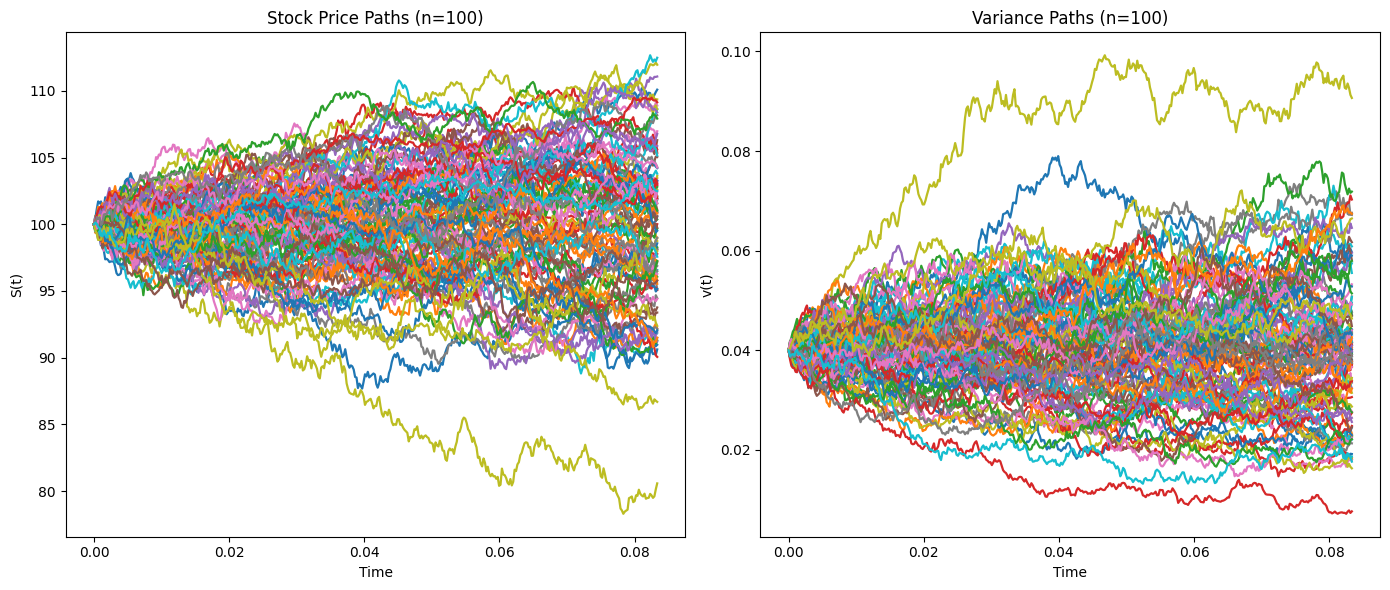

In [4]:
# simulate
S, v, time = heston_model_sim(
    S0=100, V0=0.04, rho=-0.7, theta=0.04, sigma=0.28, kappa=1.0,
    r=0.00, q=0.00, T=1/12, n_paths=200, n_steps=400, SEED=None
)

# visualize
plot_heston_paths(time, S, v, n_paths_to_plot=100)

In [5]:
class HestonHedgingEnv_Daily(gym.Env):
    """
    OpenAI Gym environment for hedging a European call using underlying simulated by Heston model.
    Modified to allow only daily rebalancing while maintaining a self-financing portfolio.

    Observation: [S_t, V_t, time_to_maturity, current_position, pnl, moneyness]
    Action: continuous hedge ratio (number of shares to hold)
    Reward: -proportional transaction cost at each step; at terminal step includes penalty on hedging error.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 heston_params: dict,
                 option_params: dict,
                 cost_rate: float = 0.001,
                 n_steps: int = 1000,
                 rebalance_frequency: int = 1,  # Default is daily (1)
                 action_lower: float = 0.0,
                 action_upper: float = 0.8,
                 lambda_: float = 1,
                 r_sig: float = 1,
                 r_const: float = 5,
                 reward_type: str = 'squared_error',
                 scaling_factors: Optional[Dict[str, float]] = None,
                 seed: Optional[int] = None):
        super().__init__()
        # Heston parameters
        self.S0 = heston_params['S0']
        self.V0 = heston_params['V0']
        self.rho = heston_params['rho']
        self.theta = heston_params['theta']
        self.sigma = heston_params['sigma']
        self.kappa = heston_params['kappa']
        self.r = heston_params['r']
        self.q = heston_params.get('q', 0.0)
        self.T = option_params['T']

        # Option parameters
        self.K = option_params['K']
        self.r = option_params['r']

        self.cost_rate = cost_rate
        self.n_steps = n_steps
        self.reward_type = reward_type
        self.scaling_factors = scaling_factors or self._default_scaling_factors()
        self.lambda_ = lambda_ 
        self.r_sig = r_sig      # Controls the width of the "acceptable" range around zero
        self.r_const = r_const

        # Daily rebalancing parameters
        self.rebalance_frequency = rebalance_frequency
        self.action_lower = action_lower
        self.action_upper = action_upper
        # Calculate steps per day based on total steps and time horizon
        self.steps_per_day = int(n_steps / (self.T * 252))  # Assuming 252 trading days per year
        self.trading_days = min(int(self.T * 252), n_steps // self.steps_per_day)

        # Create a list of indices where rebalancing is allowed
        self.rebalance_indices = [i * self.steps_per_day for i in range(self.trading_days + 1)]

        # Action space: continuous hedge ratio 
        # Negative values represent short positions in the stock
        self.action_space = spaces.Box(low=self.action_lower, high=self.action_upper, shape=(1,), dtype=np.float32)

        # Observation space: [normalized S_t, normalized V_t, normalized time_to_maturity,
        # normalized position, normalized pnl, moneyness]
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

        self.seed_value = seed
        if seed is not None:
            self.seed(seed)

        self.S_path = None
        self.V_path = None
        self.times = None
        self.current_step = 0
        self.position = 0.0
        self.cash = 0.0
        self.portfolio_values = []
        self.cum_pnl = 0.0
        self.next_rebalance_step = 0
        self.can_rebalance = True

        # Tracking variables for analysis
        self.history = {
            'actions': [],
            'positions': [],
            'rewards': [],
            'stock_prices': [],
            'variances': [],
            'cash_balance': [],
            'costs': [],
            'portfolio_values': [],
            'pnl': [],
            'rebalance_days': []  # Track which days rebalancing occurred
        }

        # Initialize environment
        self.reset()

    def _default_scaling_factors(self) -> Dict[str, float]:
        """
        Define default scaling factors for observation normalization.

        Returns
        -------
        dict
            Dictionary with default scaling factors
        """
        return {
            'price': self.S0,          # Normalize price by initial price
            'variance': self.V0,       # Normalize variance by initial variance
            'time': self.T,            # Normalize time by total time to maturity
            'position': 1.0,           # No scaling for position by default
            'pnl': self.S0            # Scale PnL by initial price
        }

    def _normalize_observation(self, obs: np.ndarray) -> np.ndarray:
        """
        Normalize the observation vector for better learning.

        Parameters
        ----------
        obs : ndarray
            Raw observation vector [S_t, V_t, tau, position, pnl, moneyness]

        Returns
        -------
        ndarray
            Normalized observation vector
        """
        normalized = np.array([
            (obs[0] / self.scaling_factors['price']) - 1.0,      # Center price around 0
            (obs[1] / self.scaling_factors['variance']) - 1.0,   # Center variance around 0
            obs[2] / self.scaling_factors['time'],               # Time to maturity [0, 1]
            obs[3] / self.scaling_factors['position'],           # Position
            obs[4] / self.scaling_factors['pnl'],                # PnL
            obs[5]                                               # Moneyness indicator
        ], dtype=np.float32)

        return normalized

    def _generate_path(self):
        # Generate a single path for one episode
        # Note: sim_heston_ct86 function is imported from outside this class
        self.S_path, self.V_path, self.times = heston_model_sim(
            self.S0, self.V0, self.rho, self.theta,
            self.sigma, self.kappa, self.r,
            self.q, self.T, n_paths=1,
            n_steps=self.n_steps, SEED=self.seed_value)

        self.S_path = self.S_path.flatten()
        self.V_path = self.V_path.flatten()

    def _calculate_portfolio_value(self):
        """Calculate the current value of the hedging portfolio"""
        t = self.current_step
        S_t = self.S_path[t]

        # Time to maturity
        tau = self.T - self.times[t]

        # Value of stock position + cash (with interest)
        port_val = self.position * S_t + self.cash * np.exp(self.r * tau)

        # Option payoff at current price and time (for European call)
        # This represents the liability we're hedging against
        option_value = self._estimate_option_value(S_t, self.V_path[t], tau)

        # PnL is option value minus portfolio value (positive is good)
        pnl = -option_value + port_val

        return port_val, pnl

    def _estimate_option_value(self, S_t, V_t, tau):
        """
        Estimate the option value at the current time
        For simplicity, using a rough approximation for a call option
        In reality, you'd use a more sophisticated Heston option pricing model
        """
        if tau <= 0.0001:  # At maturity
            return max(S_t - self.K, 0.0)

        # Simple approximation based on the Black-Scholes formula components
        # Adjusted for volatility (using sqrt of variance from Heston)
        moneyness = S_t / self.K
        vol_term = np.sqrt(V_t) * np.sqrt(tau)
        time_decay = np.exp(-self.r * tau)

        # Rough option price approximation
        if S_t > self.K:
            # In the money
            intrinsic = S_t - self.K * time_decay
            time_value = 0.4 * S_t * vol_term
            return intrinsic + time_value
        else:
            # Out of the money
            return 0.4 * S_t * vol_term * moneyness

    def seed(self, seed: Optional[int] = None) -> List[int]:
        """
        Set the random seed for this environment.

        Parameters
        ----------
        seed : int, optional
            Random seed

        Returns
        -------
        list
            List containing the seed
        """
        self.seed_value = seed
        if seed is not None:
            np.random.seed(seed)
        return [seed]

    def reset(self):
        self._generate_path()
        self.current_step = 0
        self.position = 0.0  # initial hedge position
        self.cash = 0.0      # cash account, accumulates proceeds and costs
        self.cum_pnl = 0.0   # cumulative PnL
        self.next_rebalance_step = 0
        self.can_rebalance = True

        # Reset history
        self.history = {
            'actions': [],
            'positions': [],
            'rewards': [],
            'stock_prices': [],
            'variances': [],
            'cash_balance': [],
            'costs': [],
            'portfolio_values': [],
            'pnl': [],
            'rebalance_days': []
        }

        # Calculate initial portfolio value and PnL
        port_val, pnl = self._calculate_portfolio_value()
        self.history['portfolio_values'].append(port_val)
        self.history['pnl'].append(pnl)
        self.portfolio_values = [port_val]

        return self._get_obs()

    def step(self, action: np.ndarray):
        """
        Takes a step in the environment using the specified action.

        Parameters
        ----------
        action : ndarray
            Action vector [hedge_ratio]

        Returns
        -------
        ndarray
            Next observation
        float
            Reward for the action
        bool
            Whether the episode is done
        dict
            Additional information about the environment
        """
        t = self.current_step
        S_t = self.S_path[t]
        V_t = self.V_path[t]
        tau = self.T - self.times[t]

        # Check if rebalancing is allowed at this step
        is_rebalancing_day = t in self.rebalance_indices

        # Calculate portfolio value before rebalancing
        port_val_before, pnl_before = self._calculate_portfolio_value()

        # Apply rebalancing action only on rebalancing days
        if is_rebalancing_day:
            # clip/format action to ensure it's within bounds
            h_new = float(np.clip(action[0], self.action_space.low[0], self.action_space.high[0]))

            # compute transaction cost for rebalancing
            trade_size = h_new - self.position
            cost = self.cost_rate * abs(trade_size) * S_t

            # update cash: pay for trade and cost (self-financing constraint)
            self.cash -= trade_size * S_t + cost
            self.position = h_new

            # Record rebalancing day
            self.history['rebalance_days'].append(t)
        else:
            # No rebalancing on non-rebalancing days
            h_new = self.position
            cost = 0.0

        # Calculate portfolio value and PnL after rebalancing
        port_val, pnl = self._calculate_portfolio_value()
        self.cum_pnl = pnl

        # Record state for history
        self.history['actions'].append(h_new)
        self.history['positions'].append(self.position)
        self.history['stock_prices'].append(S_t)
        self.history['variances'].append(V_t)
        self.history['cash_balance'].append(self.cash)
        self.history['costs'].append(cost)
        self.history['portfolio_values'].append(port_val)
        self.history['pnl'].append(pnl)
        self.portfolio_values.append(port_val)

        # move to next step
        self.current_step += 1
        done = (self.current_step == self.n_steps)

        # Calculate reward
        if is_rebalancing_day:
            # On rebalancing days, penalize for transaction costs
            reward = -cost

            if self.reward_type in ('immediate_pnl', 'zero_target_gaussian'):
                # Reward based on change in PnL minus cost
                if len(self.history['pnl']) >= 2:
                    pnl_change = self.history['pnl'][-1] - self.history['pnl'][-2]
                    reward += pnl_change
        else:
            # On non-rebalancing days, keep reward at 0
            reward = 0.0
        
        # At terminal step, add hedging error penalty
        if done:
            S_T = self.S_path[-1]
            payoff = max(S_T - self.K, 0.0)
            final_port_val = self.position * S_T + self.cash * np.exp(self.r * self.T)
            final_pnl = -payoff + final_port_val

            if self.reward_type == 'mean_variance':
                # Mean-variance reward (negative exponential utility)
                reward += -(1 / self.lambda_) * np.exp(-self.lambda_ * final_pnl)
            elif self.reward_type == 'pnl':
                # Direct PnL reward
                reward += final_pnl
            elif self.reward_type == 'squared_error':
                # Negative squared error reward
                reward += -final_pnl**2
            elif self.reward_type == 'immediate_pnl':
                # Already included intermediate PnL changes
                reward += 10 * final_pnl  # Emphasize final outcome
            elif self.reward_type == 'zero_target_gaussian':
                reward += self.r_const * np.exp(-(final_pnl**2)/(2*self.r_sig**2))  # Peaks at 1.0 when PnL=0
            else:
                # Default to squared error
                reward = -final_pnl**2

            info = {
                'final_stock_price': S_T,
                'option_payoff': payoff,
                'portfolio_value': final_port_val,
                'hedging_error': final_pnl,
                'total_cost': sum(self.history['costs']),
                'final_position': self.position,
                'final_cash': self.cash,
                'total_rebalances': len(self.history['rebalance_days'])
            }
        else:
            info = {
                'current_pnl': pnl,
                'last_cost': cost,
                'is_rebalancing_day': is_rebalancing_day,
            }

        # Record reward
        self.history['rewards'].append(reward)

        obs = self._get_obs()
        return obs, reward, done, info

    def _get_obs(self):
        """
        Get the current observation vector

        Returns
        ------
        ndarray
            Normalized observation vector [norm_S_t, norm_V_t, norm_tau, norm_position, norm_pnl, moneyness]
        """
        t = self.current_step
        if t >= len(self.times):
            t = len(self.times) - 1

        S_t = self.S_path[t]
        V_t = self.V_path[t]
        tau = self.T - self.times[t]

        # Calculate moneyness indicator: -1 for out-of-the-money, 1 for in-the-money
        moneyness = 1.0 if S_t > self.K else -1.0

        # Add PnL to observation
        raw_obs = np.array([S_t, V_t, tau, self.position, self.cum_pnl, moneyness], dtype=np.float32)

        return self._normalize_observation(raw_obs)

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        """
        Render the current state of the environment.

        Parameters
        ----------
        mode : str, optional
            Rendering mode, options are 'human' and 'rgb_array'

        Returns
        -------
        ndarray, optional
            RGB array if mode is 'rgb_array', None otherwise
        """
        if mode == 'human':
            t = self.current_step
            t = min(t, len(self.times) - 1)
            S_t = self.S_path[t]
            is_rebalancing_day = t in self.rebalance_indices

            print(f"Step {t}/{self.n_steps}:")
            print(f"  Stock Price: {self.S_path[t]:.4f}")
            print(f"  Variance: {self.V_path[t]:.6f}")
            print(f"  Time to Maturity: {self.T - self.times[t]:.4f}")
            print(f"  Current Position: {self.position:.4f}")
            print(f"  Cash Balance: {self.cash:.4f}")
            print(f"  Rebalancing Day: {is_rebalancing_day}")

            if t > 0:
                print(f"  Transaction Cost: {self.history['costs'][-1]:.4f}")
                print(f"  Reward: {self.history['rewards'][-1]:.4f}")
                print(f"  Current PnL: {self.history['pnl'][-1]:.4f}")
                print(f"  Moneyness (S/K): {S_t/self.K:.4f}")
                
                if S_t < self.K:
                    print("  Option Status: Out-of-the-money")
                else:
                    print("  Option Status: In-the-money")


            # If at terminal step, print additional information
            if t == (self.n_steps - 1):
                S_T = self.S_path[-1]
                option_payoff = max(S_T - self.K, 0.0)
                port_val = self.position * S_T + self.cash * np.exp(self.r * self.T)
                print(f"Terminal State:")
                print(f"  Final Stock Price: {S_T:.4f}")
                print(f"  Option Payoff: {option_payoff:.4f}")
                print(f"  Portfolio Value: {port_val:.4f}")
                print(f"  Hedging Error: {port_val - option_payoff:.4f}")
                print(f"  Total Cost: {sum(self.history['costs']):.4f}")
                print(f"  Total Rebalances: {len(self.history['rebalance_days'])}")

            return None

        elif mode == 'rgb_array':
            # Create visualization and return as RGB array
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))

            # Plot stock price path
            axes[0, 0].plot(self.times[:self.current_step+1], self.S_path[:self.current_step+1])
            axes[0, 0].set_title('Stock Price Path')
            axes[0, 0].set_xlabel('Time')
            axes[0, 0].set_ylabel('Price')

            # Plot variance path
            axes[0, 1].plot(self.times[:self.current_step+1], self.V_path[:self.current_step+1])
            axes[0, 1].set_title('Variance Path')
            axes[0, 1].set_xlabel('Time')
            axes[0, 1].set_ylabel('Variance')

            # Plot position history
            if self.current_step > 0:
                time_points = self.times[:self.current_step]
                axes[1, 0].plot(time_points, self.history['positions'][:self.current_step])
                axes[1, 0].set_title('Hedge Position')
                axes[1, 0].set_xlabel('Time')
                axes[1, 0].set_ylabel('Position')

                # Mark rebalancing days with vertical lines
                rebalance_times = [self.times[idx] for idx in self.history['rebalance_days'] if idx < self.current_step]
                for rt in rebalance_times:
                    axes[1, 0].axvline(x=rt, color='r', linestyle='--', alpha=0.3)

                # Plot portfolio value history
                if len(self.portfolio_values) > 1:
                    axes[1, 1].plot(time_points, self.portfolio_values[:self.current_step])
                    axes[1, 1].set_title('Portfolio Value')
                    axes[1, 1].set_xlabel('Time')
                    axes[1, 1].set_ylabel('Value')

            plt.tight_layout()

            # Convert plot to RGB array
            fig.canvas.draw()
            # Get the RGBA buffer from the figure
            w, h = fig.canvas.get_width_height()
            buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            # Reshape it to a proper image and convert to RGB
            buf = buf.reshape((h, w, 4))
            # Convert RGBA to RGB
            img = buf[:, :, :3]
            plt.close(fig)

            return img

        else:
            raise ValueError(f"Unsupported render mode: {mode}")

    def close(self):
        """Clean up resources."""
        plt.close('all')

    def get_history(self) -> Dict[str, List]:
        """
        Get the history of the environment for analysis.

        Returns
        -------
        dict
            Dictionary containing the history of actions, positions, rewards, etc.
        """
        return self.history

# TD3

## TD3 1 SIGMA 0.1 CONST 4

sigma=0.1
const=4

In [7]:
from stable_baselines3 import TD3

In [10]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.1
r_const = 4
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                               option_params=option_params,
                               action_lower=action_lower,
                               action_upper=action_upper,
                               n_steps=n_steps,
                               reward_type=reward_type,
                               r_sig=r_sig,
                               r_const=r_const,
                               lambda_=lambda_)

env_maker = lambda: myenv
env = DummyVecEnv([env_maker])

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions)
)

model = TD3(
    policy="MlpPolicy",     
    env=env,
    action_noise=action_noise,
    verbose=1,
    device=device,
)

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model.learn(total_timesteps=40_000)

Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.1479
  Variance: 0.061347
  Time to Maturity: 0.0000
  Current Position: 0.7651
  Cash Balance: -75.8933
  Rebalancing Day: True
  Transaction Cost: 0.0041
  Reward: 0.6626
  Current PnL: -0.7976
  Moneyness (S/K): 0.9815
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.1479
  Option Payoff: 0.0000
  Portfolio Value: -0.7976
  Hedging Error: -0.7976
  Total Cost: 0.1610
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.2004
  Variance: 0.054419
  Time to Maturity: 0.0000
  Current Position: 0.6831
  Cash Balance: -66.6212
  Rebalancing Day: True
  Transaction Cost: 0.0119
  Reward: 0.0697
  Current PnL: -2.9541
  M

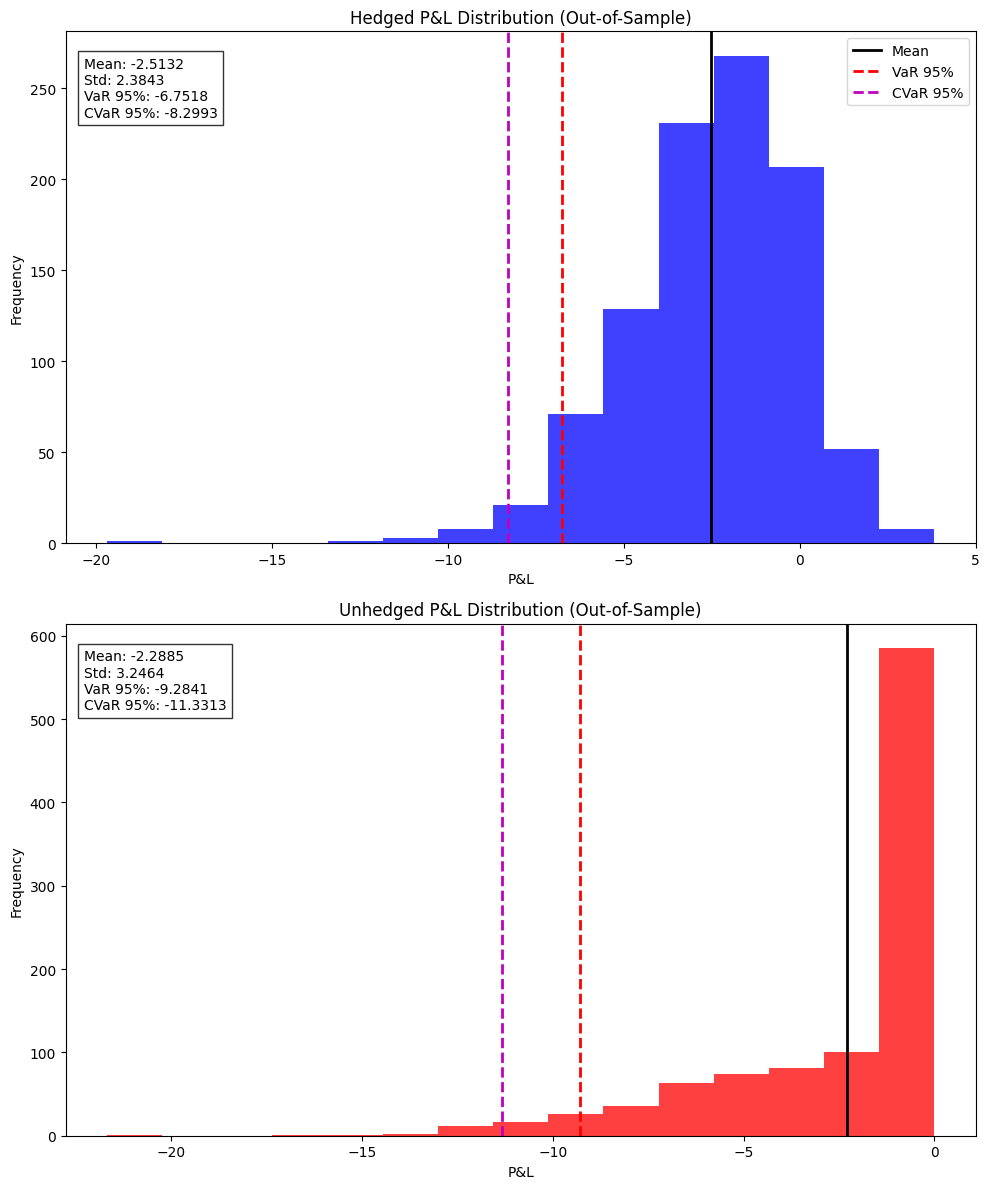

Risk Reduction from Hedging:
VaR Improvement: -2.5323
CVaR Improvement: -3.0320
Std Dev Reduction: 0.8621


In [12]:
eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                               option_params=option_params,
                               action_lower=action_lower,
                               action_upper=action_upper,
                               n_steps=n_steps,
                               reward_type=reward_type,
                               r_sig=r_sig,
                               r_const=r_const,
                               lambda_=lambda_)
n_paths = 1000
pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)

plot_pnl_distributions(pnl_dist, unhedged_pnl)

## TD3 2 SIGMA 0.1 CONST [3, 5]

this itteration the r_sig = 0.1, and r_const = 3
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.7942
  Variance: 0.037010
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 3.0980
  Current PnL: 0.0000
  Moneyness (S/K): 0.9379
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.7942
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400

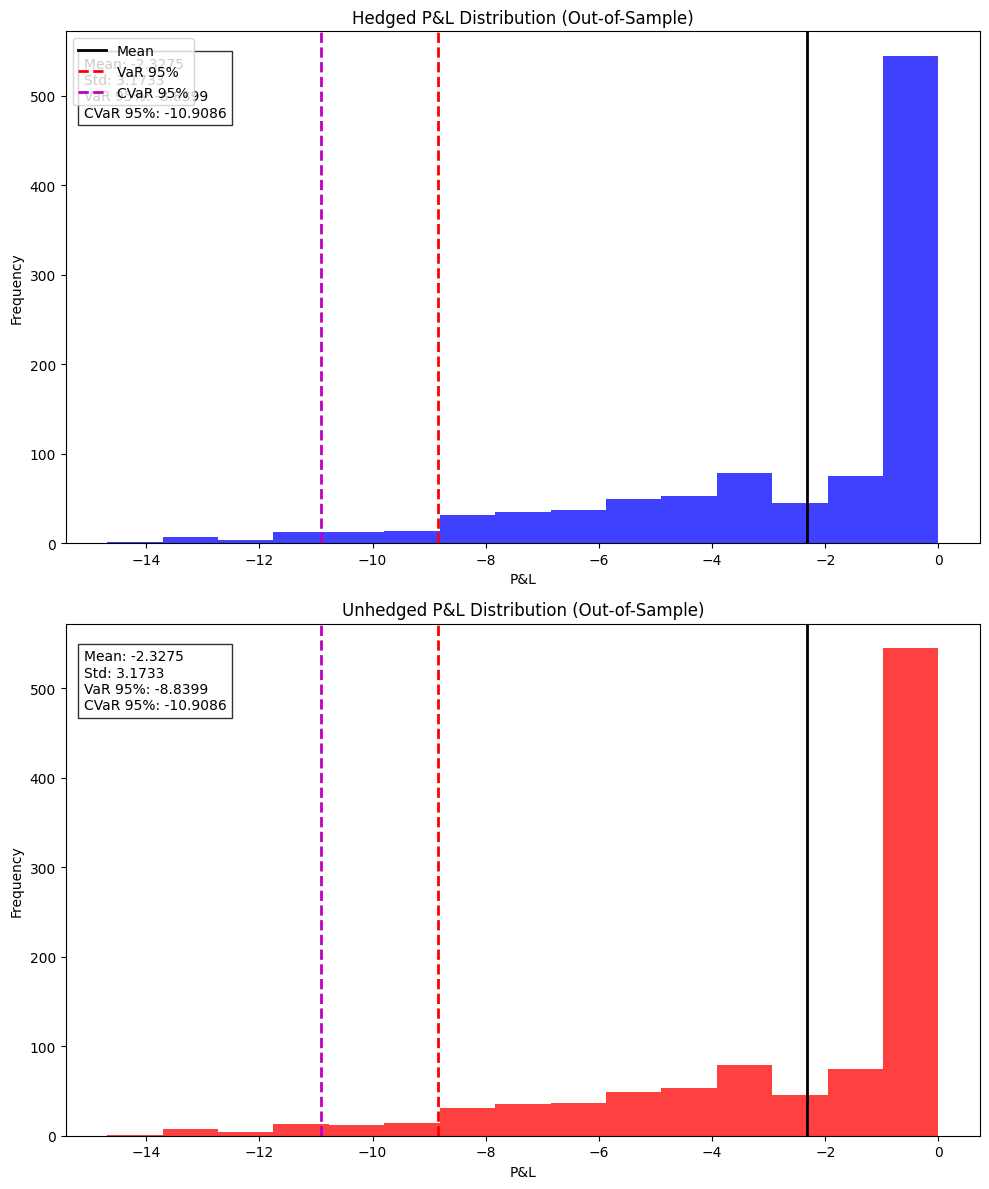

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 0.1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 109.4112
  Variance: 0.019044
  Time to Maturity: 0.0000
  Current Position: 0.9999
  Cash Balance: -104.6816
  Rebalancing Day: True
  Transaction Cost: 0.0001
  Reward: 0.0856
  Current PnL: -4.6891
  Moneyness (S/K): 1.0941
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 109.4112
  Option Payoff: 9.4112
  Portfolio Value: 4.7222
  Hedging Error: -4.6891
  Total Cost: 0.1075
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000

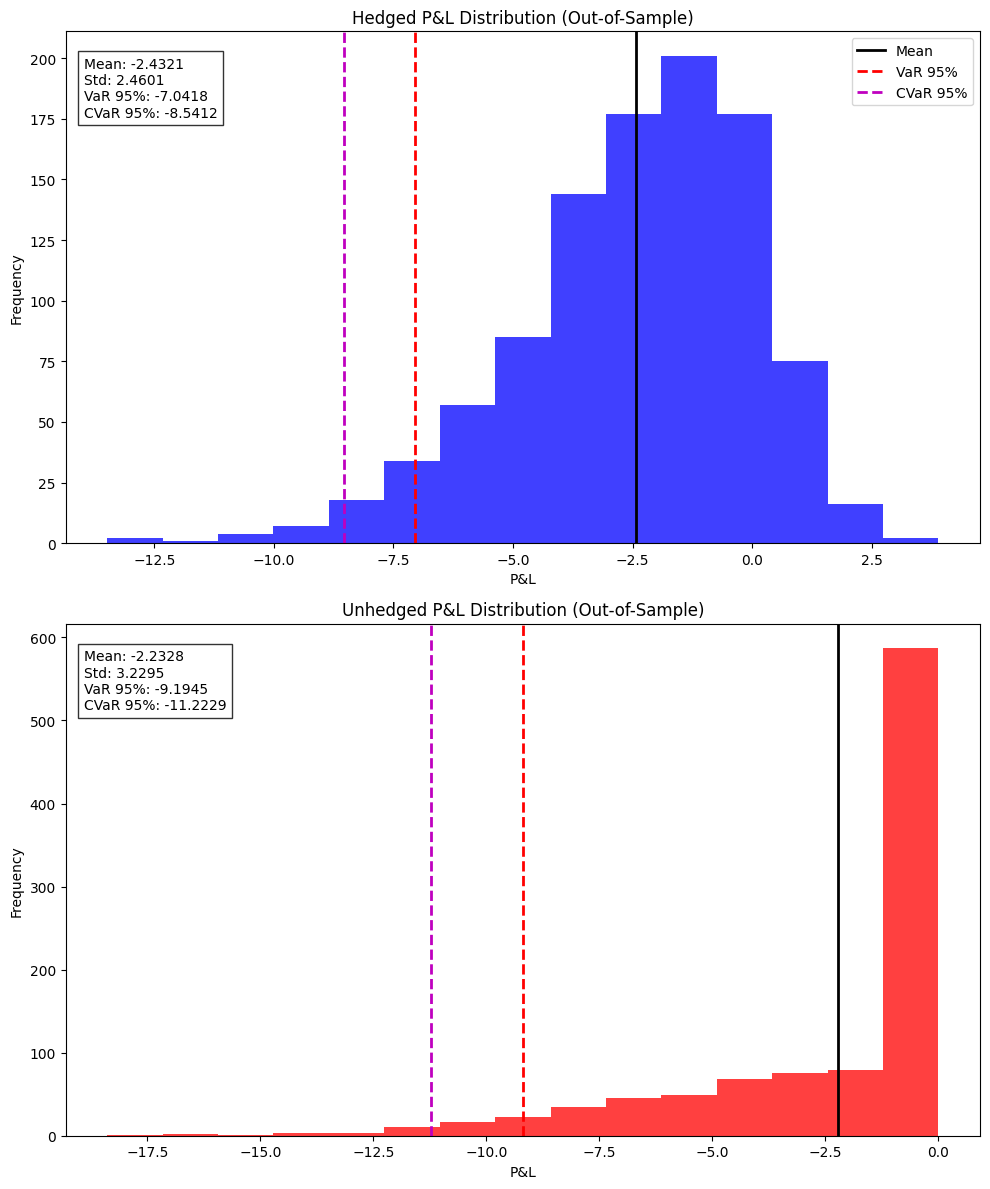

Risk Reduction from Hedging:
VaR Improvement: -2.1527
CVaR Improvement: -2.6817
Std Dev Reduction: 0.7694
---------------------------


In [14]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [3, 5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 3 SIGMA 0.1 CONST [7, 9]


this itteration the r_sig = 0.1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 95.8699
  Variance: 0.047699
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.5414
  Current PnL: -4.2301
  Moneyness (S/K): 0.9587
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 95.8699
  Option Payoff: 0.0000
  Portfolio Value: -4.2301
  Hedging Error: -4.2301
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 3

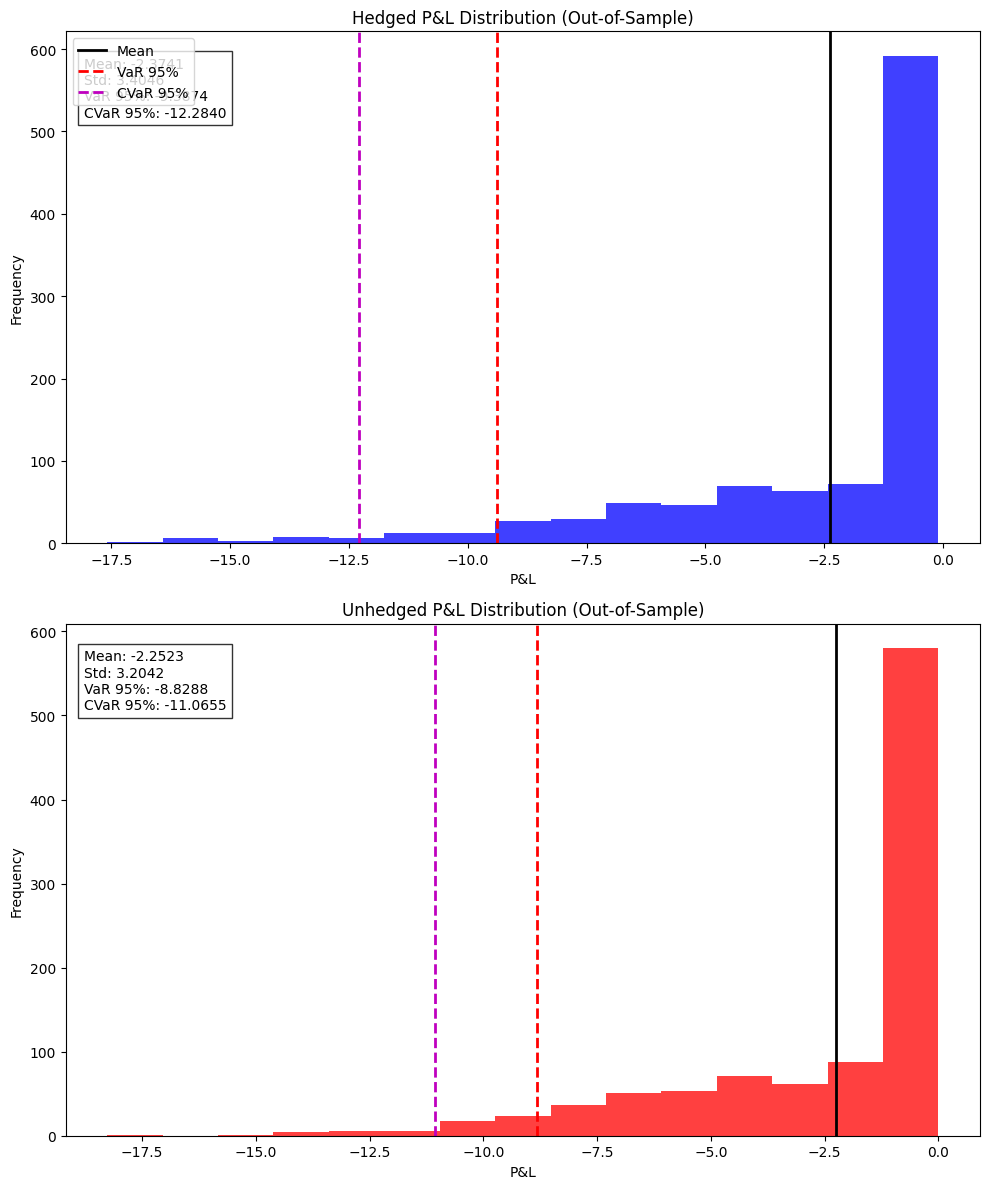

Risk Reduction from Hedging:
VaR Improvement: 0.5587
CVaR Improvement: 1.2185
Std Dev Reduction: -0.2004
---------------------------
this itteration the r_sig = 0.1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.9737
  Variance: 0.025814
  Time to Maturity: 0.0000
  Current Position: 0.4157
  Cash Balance: -41.5837
  Rebalancing Day: True
  Transaction Cost: 0.0538
  Reward: 8.6620
  Current PnL: -0.0264
  Moneyness (S/K): 0.9997
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.9737
  Option Payoff: 0.0000
  Portfolio Value: -0.0264
  Hedging Error: -0.0264
  Total Cost: 0.3171
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0

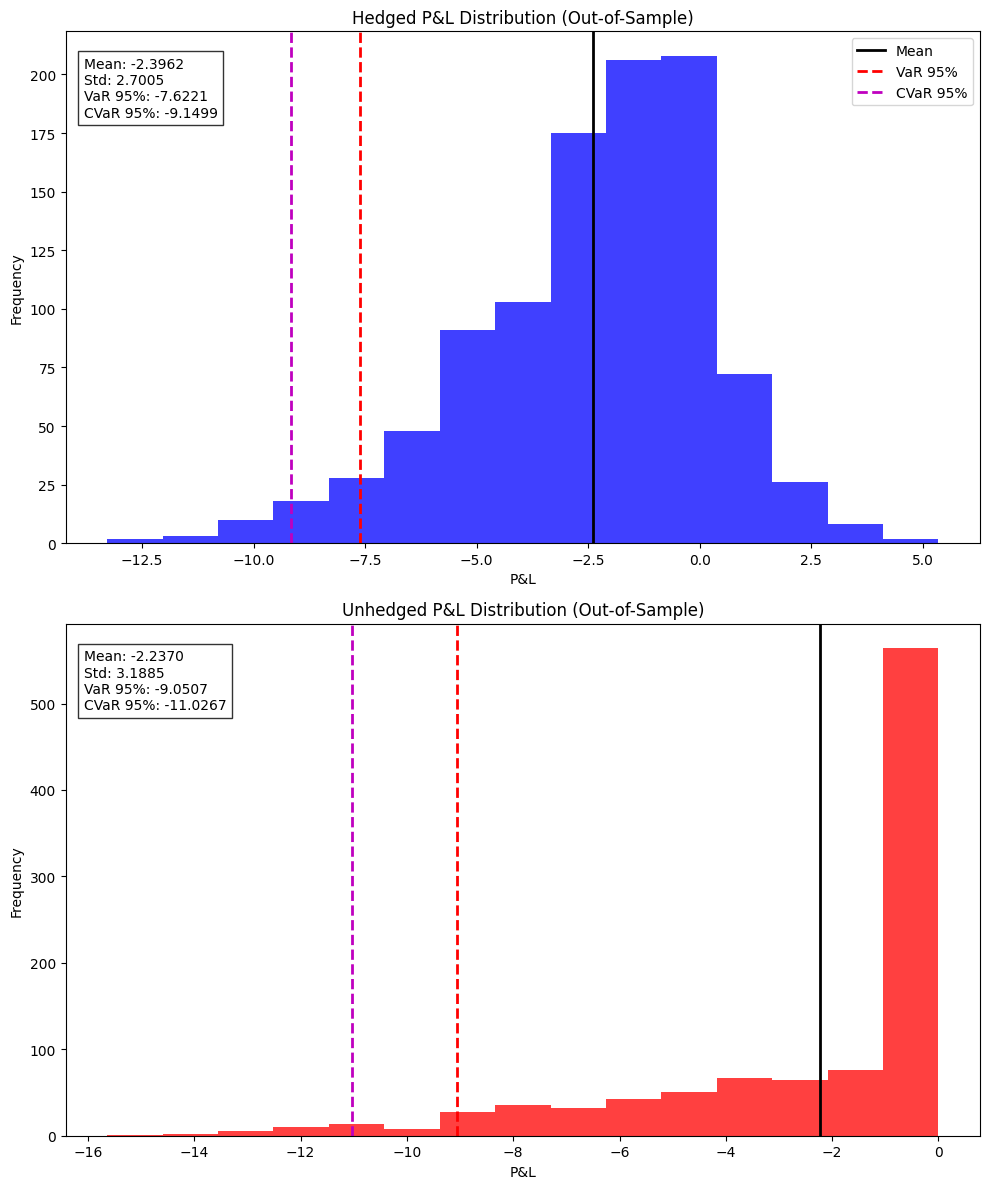

Risk Reduction from Hedging:
VaR Improvement: -1.4286
CVaR Improvement: -1.8768
Std Dev Reduction: 0.4879
---------------------------


In [15]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 4 SIGMA 0.5 CONST [4,7]

this itteration the r_sig = 0.5, and r_const = 4
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 103.1352
  Variance: 0.029147
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -101.6525
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.1186
  Current PnL: -1.6525
  Moneyness (S/K): 1.0314
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 103.1352
  Option Payoff: 3.1352
  Portfolio Value: 1.4827
  Hedging Error: -1.6525
  Total Cost: 0.1016
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/

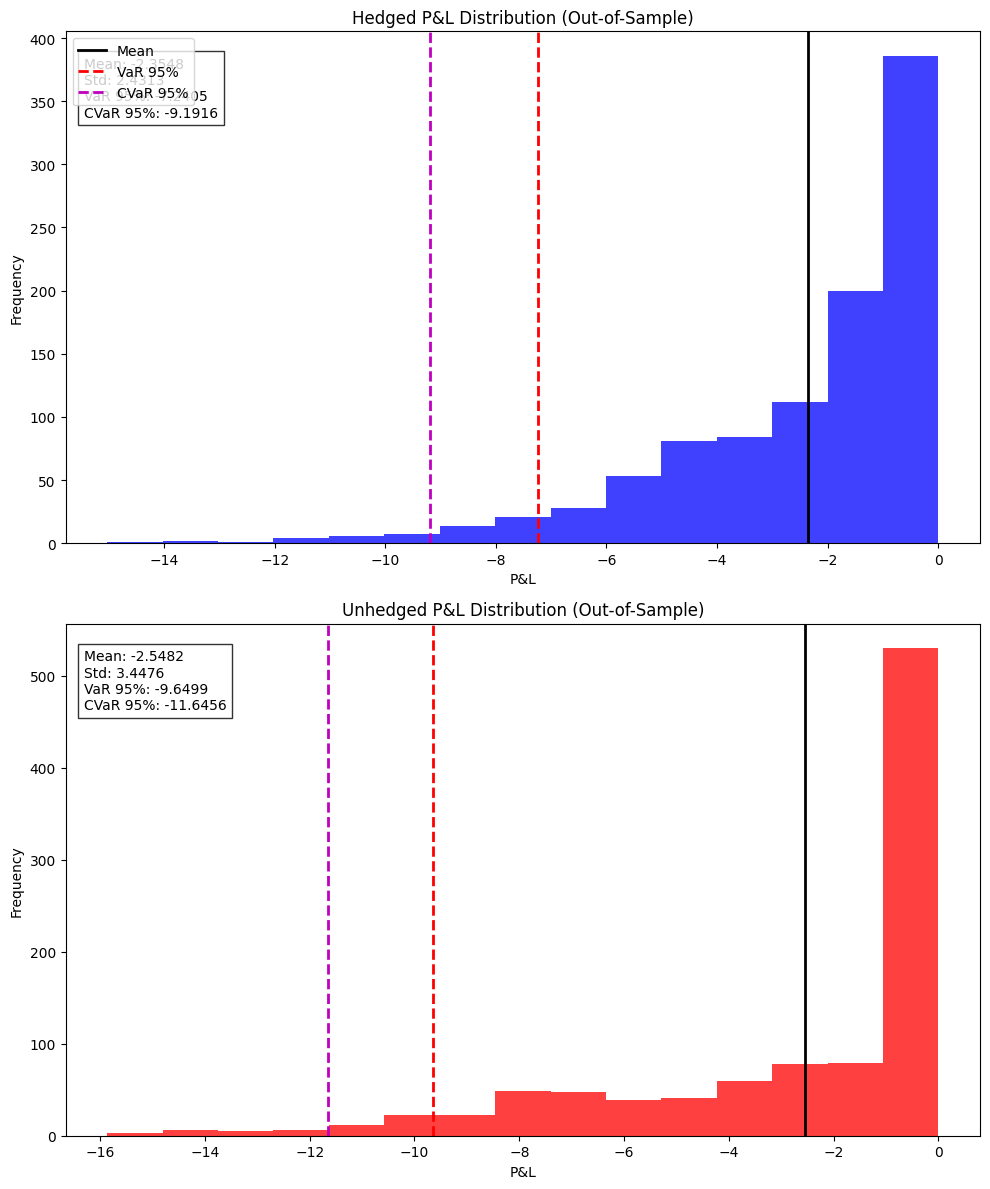

Risk Reduction from Hedging:
VaR Improvement: -2.4094
CVaR Improvement: -2.4540
Std Dev Reduction: 1.0163
---------------------------
this itteration the r_sig = 0.5, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 104.4927
  Variance: 0.029976
  Time to Maturity: 0.0000
  Current Position: 0.9970
  Cash Balance: -101.6749
  Rebalancing Day: True
  Transaction Cost: 0.0002
  Reward: 0.1083
  Current PnL: -1.9850
  Moneyness (S/K): 1.0449
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 104.4927
  Option Payoff: 4.4927
  Portfolio Value: 2.5077
  Hedging Error: -1.9850
  Total Cost: 0.1022
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

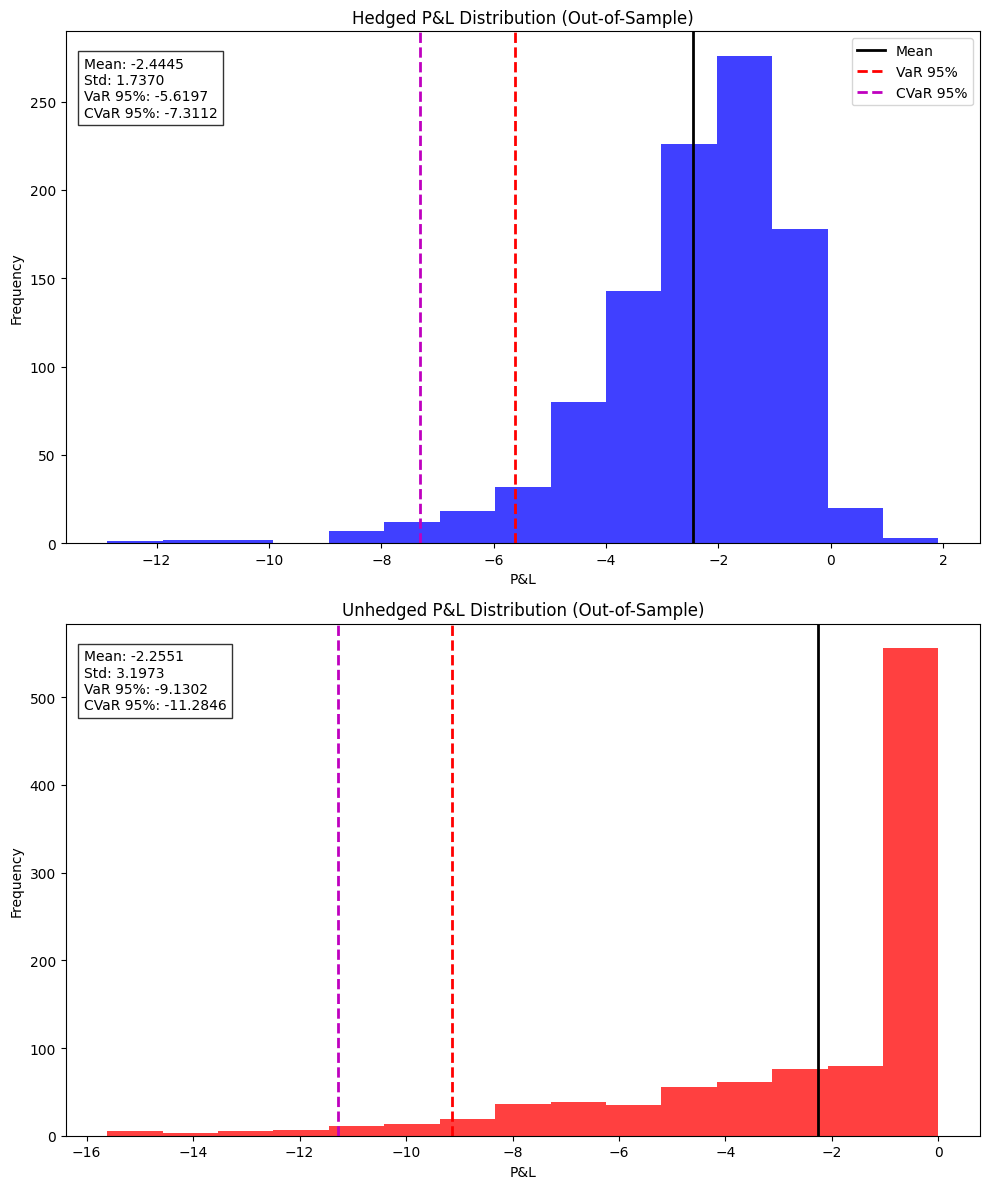

Risk Reduction from Hedging:
VaR Improvement: -3.5105
CVaR Improvement: -3.9734
Std Dev Reduction: 1.4603
---------------------------


In [16]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [4, 7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 5 SIGMA 0.5 CONST [3, 5, 9]

this itteration the r_sig = 0.5, and r_const = 3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 92.4933
  Variance: 0.034238
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.1964
  Current PnL: -7.6067
  Moneyness (S/K): 0.9249
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 92.4933
  Option Payoff: 0.0000
  Portfolio Value: -7.6067
  Hedging Error: -7.6067
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.4659
  Variance: 0.0287

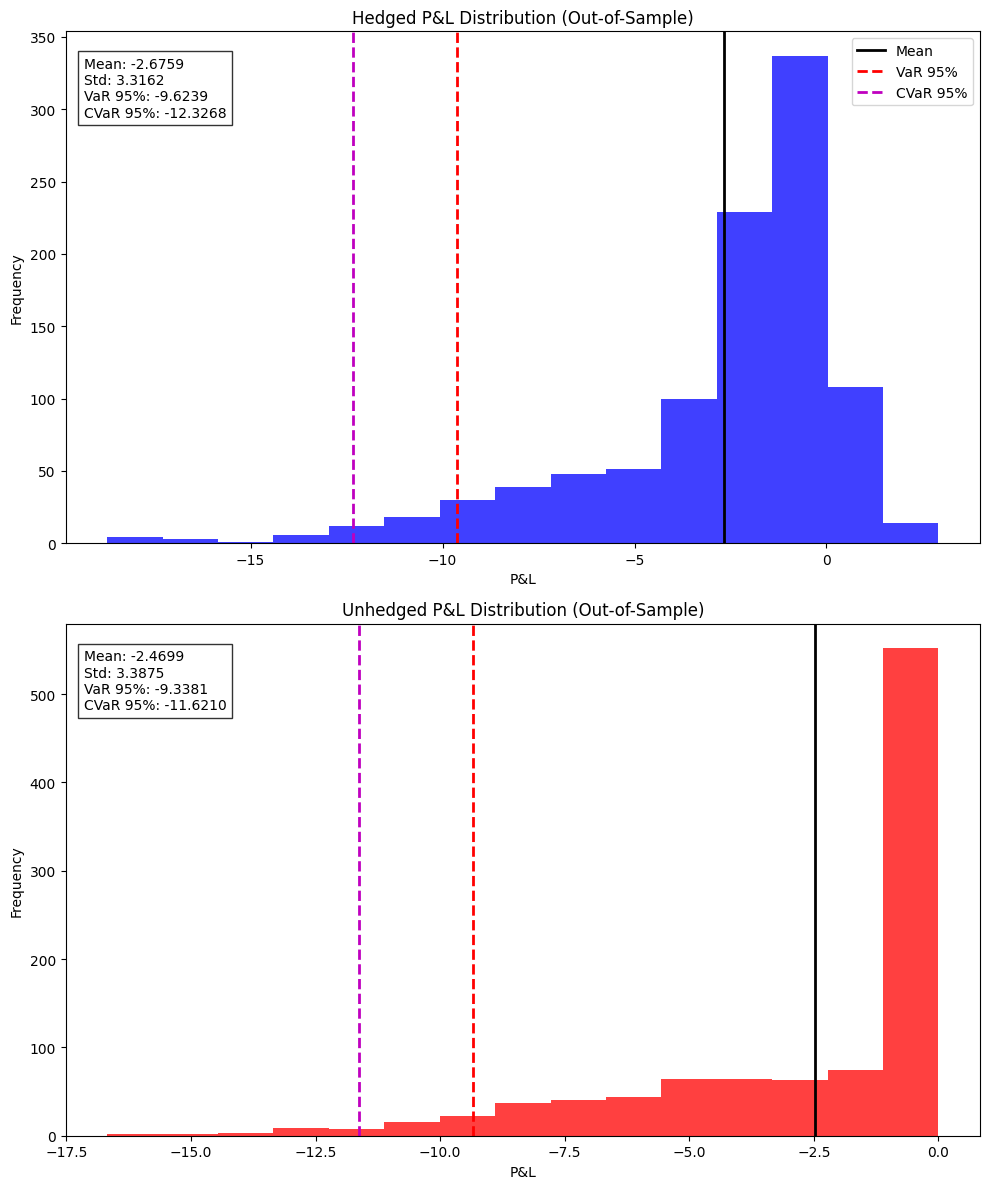

Risk Reduction from Hedging:
VaR Improvement: 0.2858
CVaR Improvement: 0.7059
Std Dev Reduction: 0.0713
---------------------------
this itteration the r_sig = 0.5, and r_const = 5


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 106.6842
  Variance: 0.017801
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -101.4693
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.1489
  Current PnL: -1.4697
  Moneyness (S/K): 1.0668
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 106.6842
  Option Payoff: 6.6842
  Portfolio Value: 5.2145
  Hedging Error: -1.4697
  Total Cost: 0.1935
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 100.9684
  Variance: 0.041375

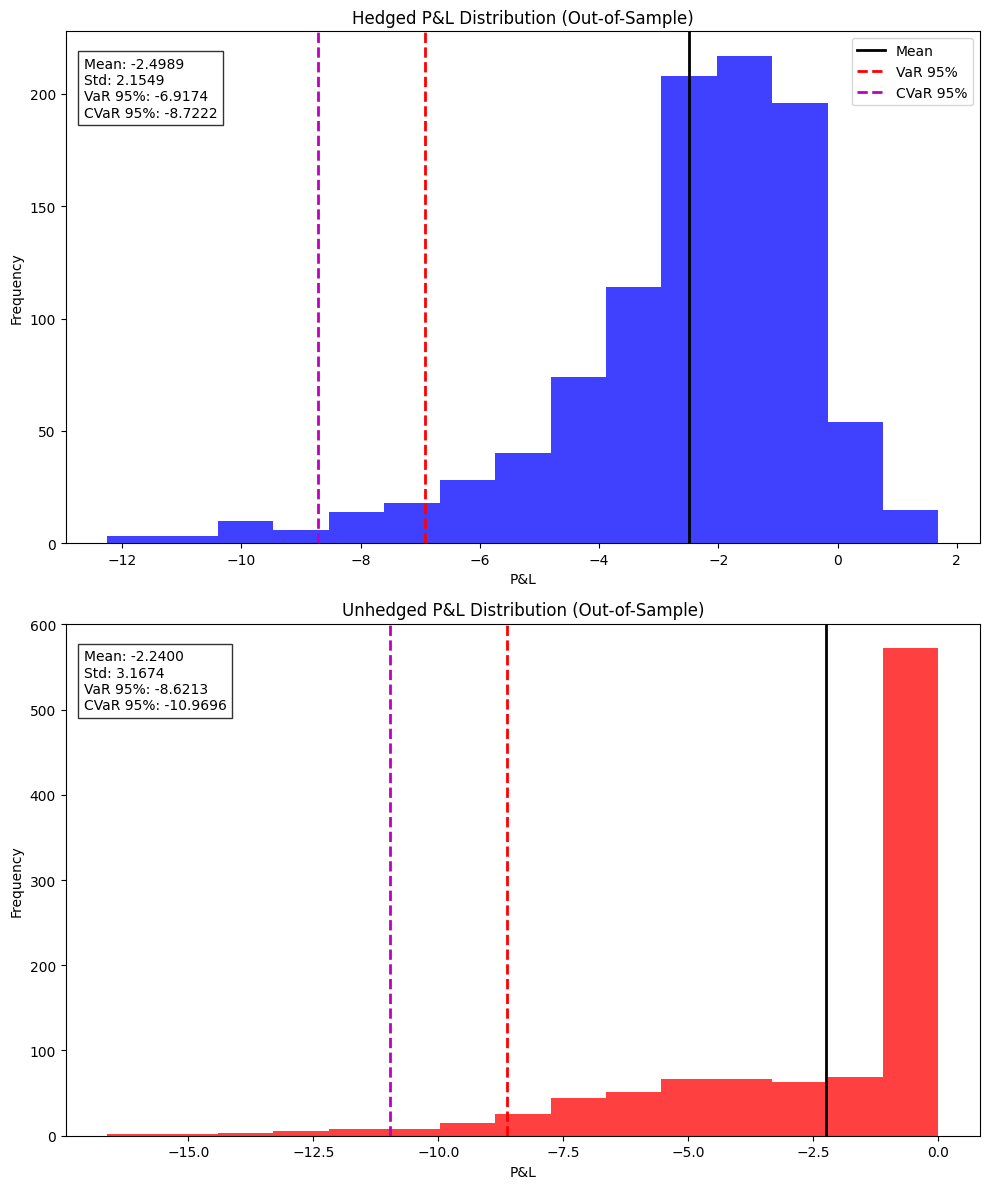

Risk Reduction from Hedging:
VaR Improvement: -1.7039
CVaR Improvement: -2.2475
Std Dev Reduction: 1.0125
---------------------------
this itteration the r_sig = 0.5, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 109.2191
  Variance: 0.020490
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: -0.3053
  Current PnL: -9.2191
  Moneyness (S/K): 1.0922
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 109.2191
  Option Payoff: 9.2191
  Portfolio Value: 0.0000
  Hedging Error: -9.2191
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000

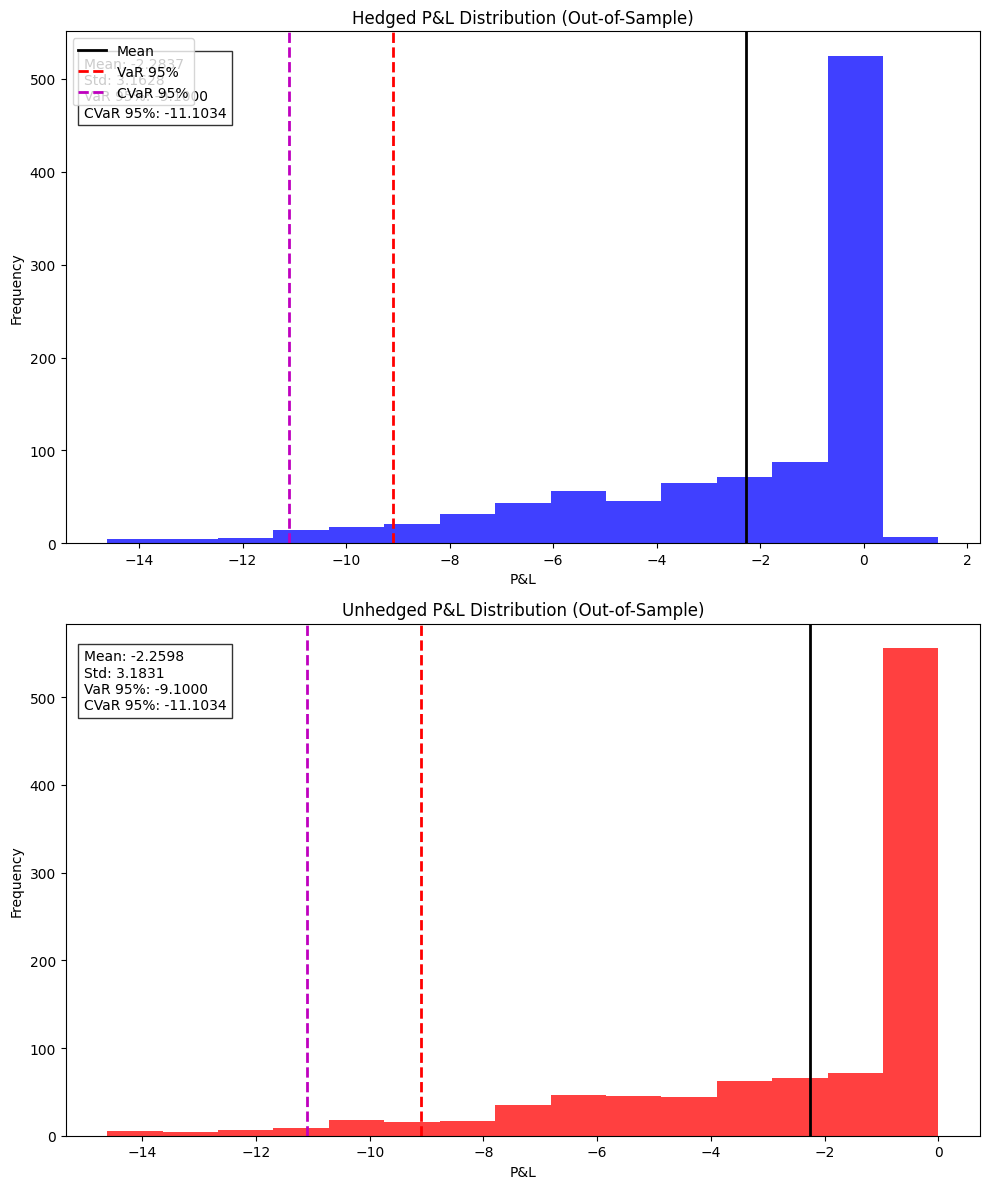

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0203
---------------------------


In [10]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [3, 5, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST [3, 4, 5, 7, 9]

this itteration the r_sig = 1, and r_const = 3
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 97.1220
  Variance: 0.050601
  Time to Maturity: 0.0000
  Current Position: 0.0146
  Cash Balance: -4.3176
  Rebalancing Day: True
  Transaction Cost: 0.0014
  Reward: 0.1639
  Current PnL: -2.9014
  Moneyness (S/K): 0.9712
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 97.1220
  Option Payoff: 0.0000
  Portfolio Value: -2.9014
  Hedging Error: -2.9014
  Total Cost: 0.2043
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/4

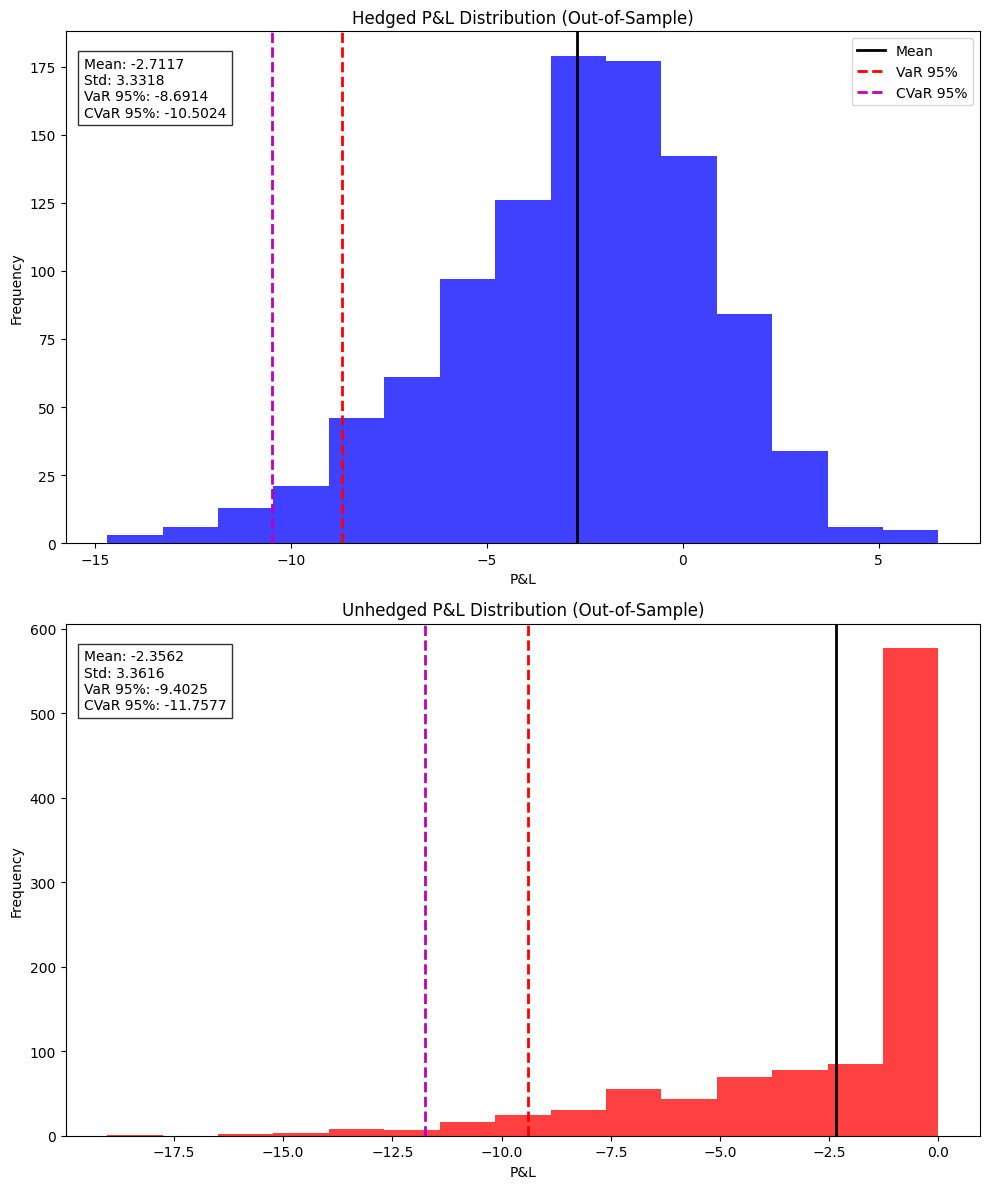

Risk Reduction from Hedging:
VaR Improvement: -0.7111
CVaR Improvement: -1.2554
Std Dev Reduction: 0.0298
---------------------------
this itteration the r_sig = 1, and r_const = 4
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 97.6106
  Variance: 0.045103
  Time to Maturity: 0.0000
  Current Position: 0.5122
  Cash Balance: -56.4119
  Rebalancing Day: True
  Transaction Cost: 0.0133
  Reward: 0.1466
  Current PnL: -6.4121
  Moneyness (S/K): 0.9761
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 97.6106
  Option Payoff: 0.0000
  Portfolio Value: -6.4121
  Hedging Error: -6.4121
  Total Cost: 0.1397
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

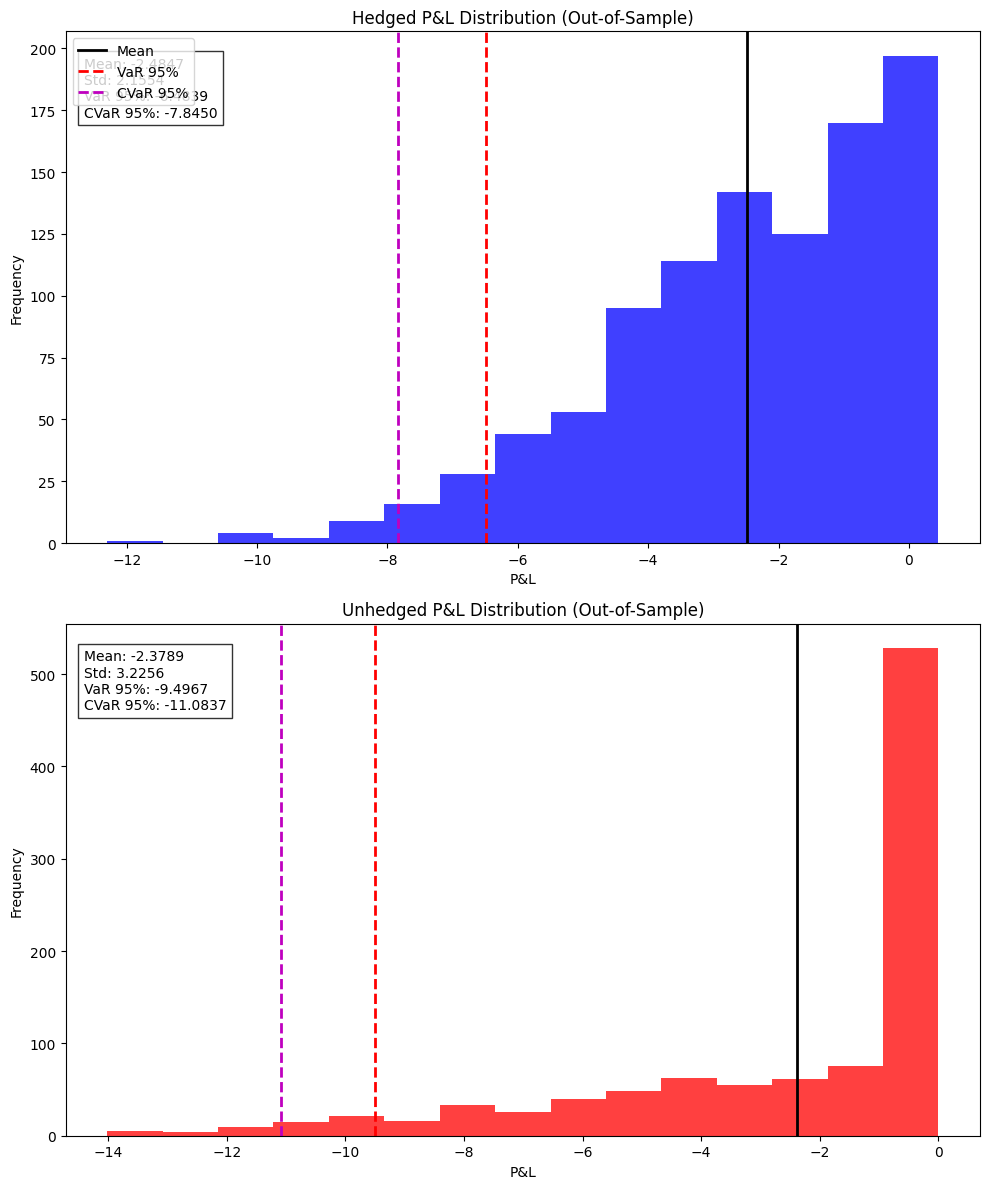

Risk Reduction from Hedging:
VaR Improvement: -3.0128
CVaR Improvement: -3.2386
Std Dev Reduction: 1.0702
---------------------------
this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 104.5932
  Variance: 0.040630
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.0954
  Current PnL: -0.1000
  Moneyness (S/K): 1.0459
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 104.5932
  Option Payoff: 4.5932
  Portfolio Value: 4.4932
  Hedging Error: -0.1000
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000

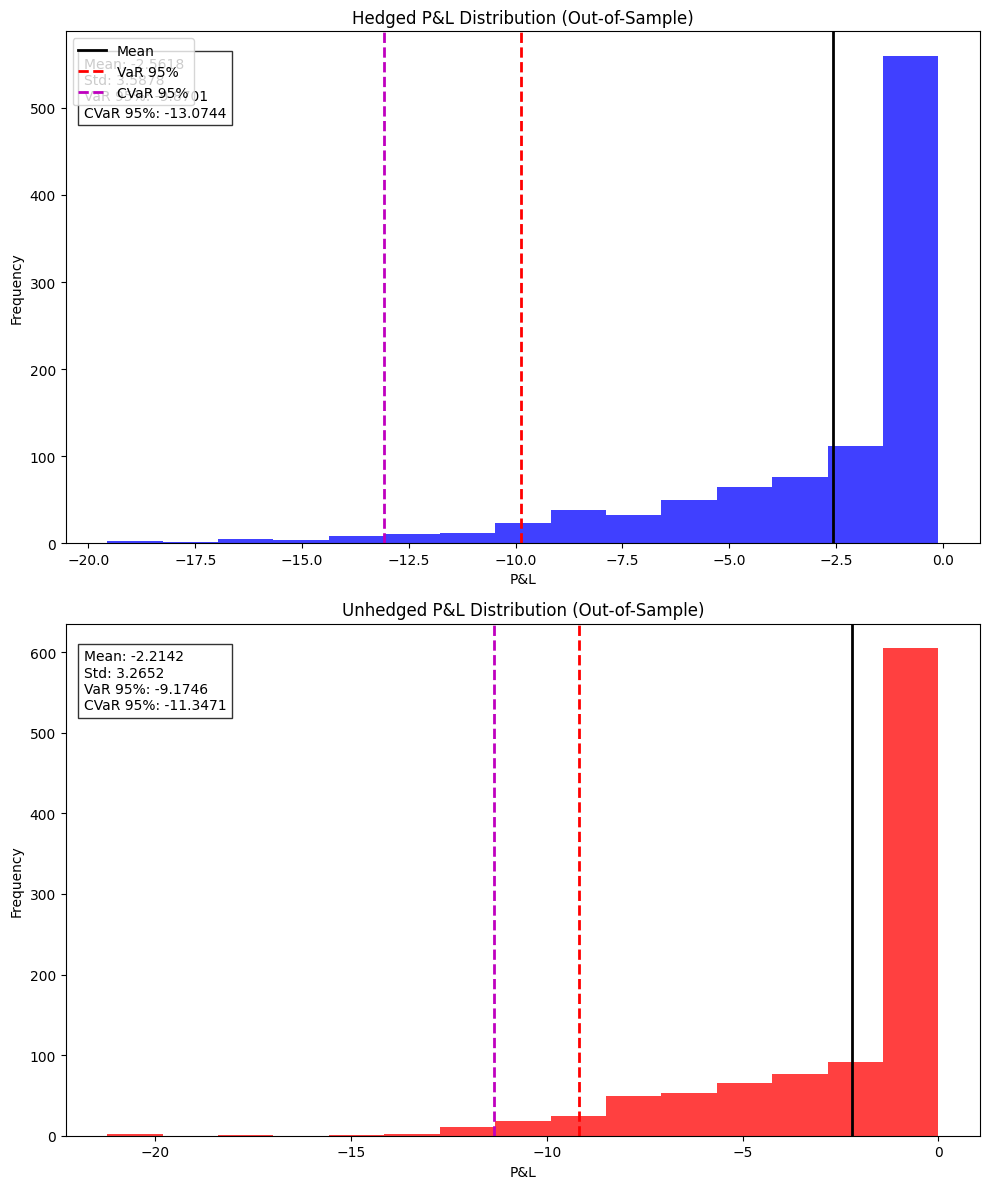

Risk Reduction from Hedging:
VaR Improvement: 0.6954
CVaR Improvement: 1.7273
Std Dev Reduction: -0.3226
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 89.2966
  Variance: 0.068583
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -3.4132
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.1421
  Current PnL: -3.4132
  Moneyness (S/K): 0.8930
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 89.2966
  Option Payoff: 0.0000
  Portfolio Value: -3.4132
  Hedging Error: -3.4132
  Total Cost: 0.1423
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000

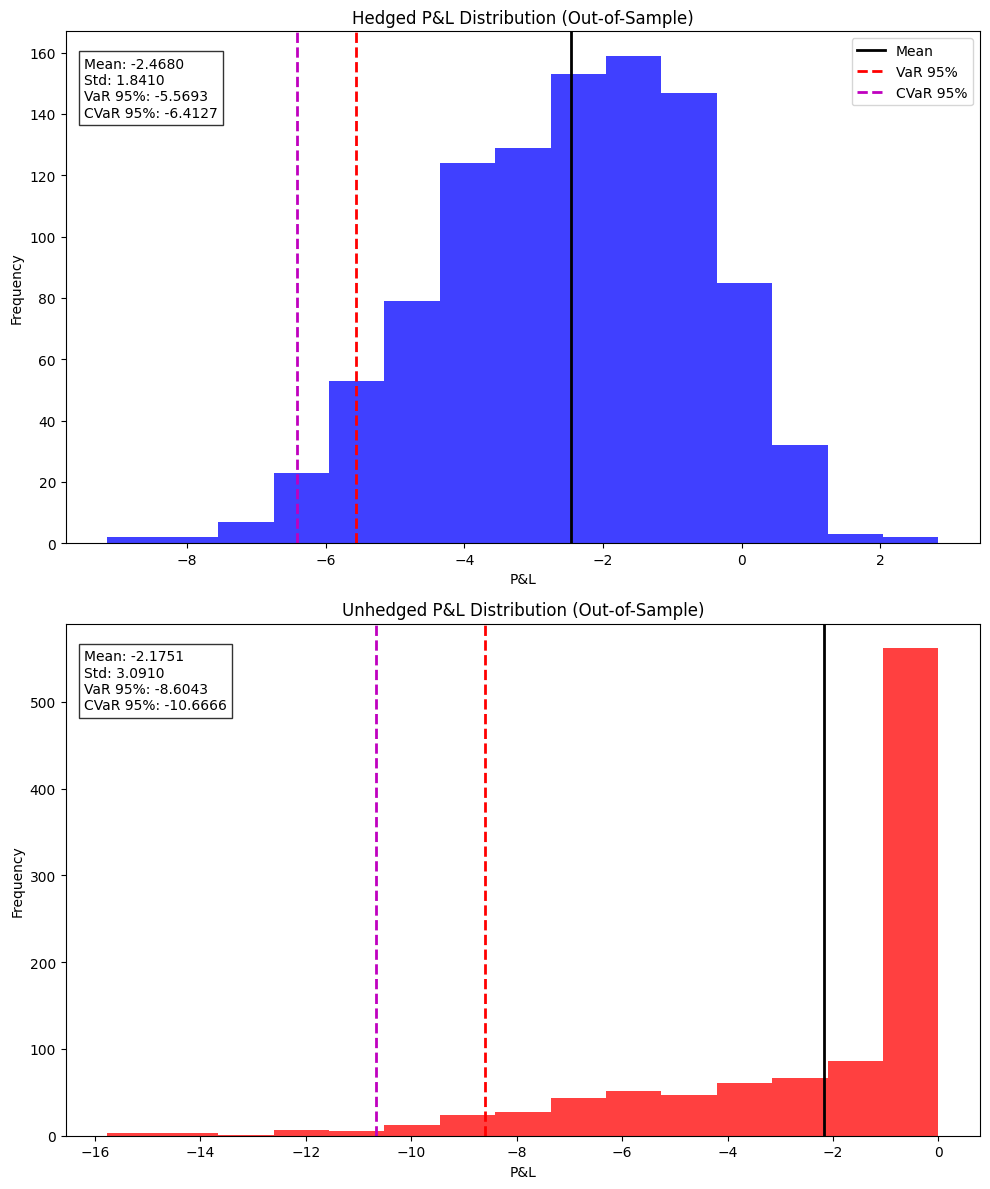

Risk Reduction from Hedging:
VaR Improvement: -3.0350
CVaR Improvement: -4.2539
Std Dev Reduction: 1.2500
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 100.4750
  Variance: 0.051297
  Time to Maturity: 0.0000
  Current Position: 0.0019
  Cash Balance: -0.2323
  Rebalancing Day: True
  Transaction Cost: 0.0031
  Reward: 8.1871
  Current PnL: -0.5131
  Moneyness (S/K): 1.0047
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 100.4750
  Option Payoff: 0.4750
  Portfolio Value: -0.0381
  Hedging Error: -0.5131
  Total Cost: 0.0798
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000


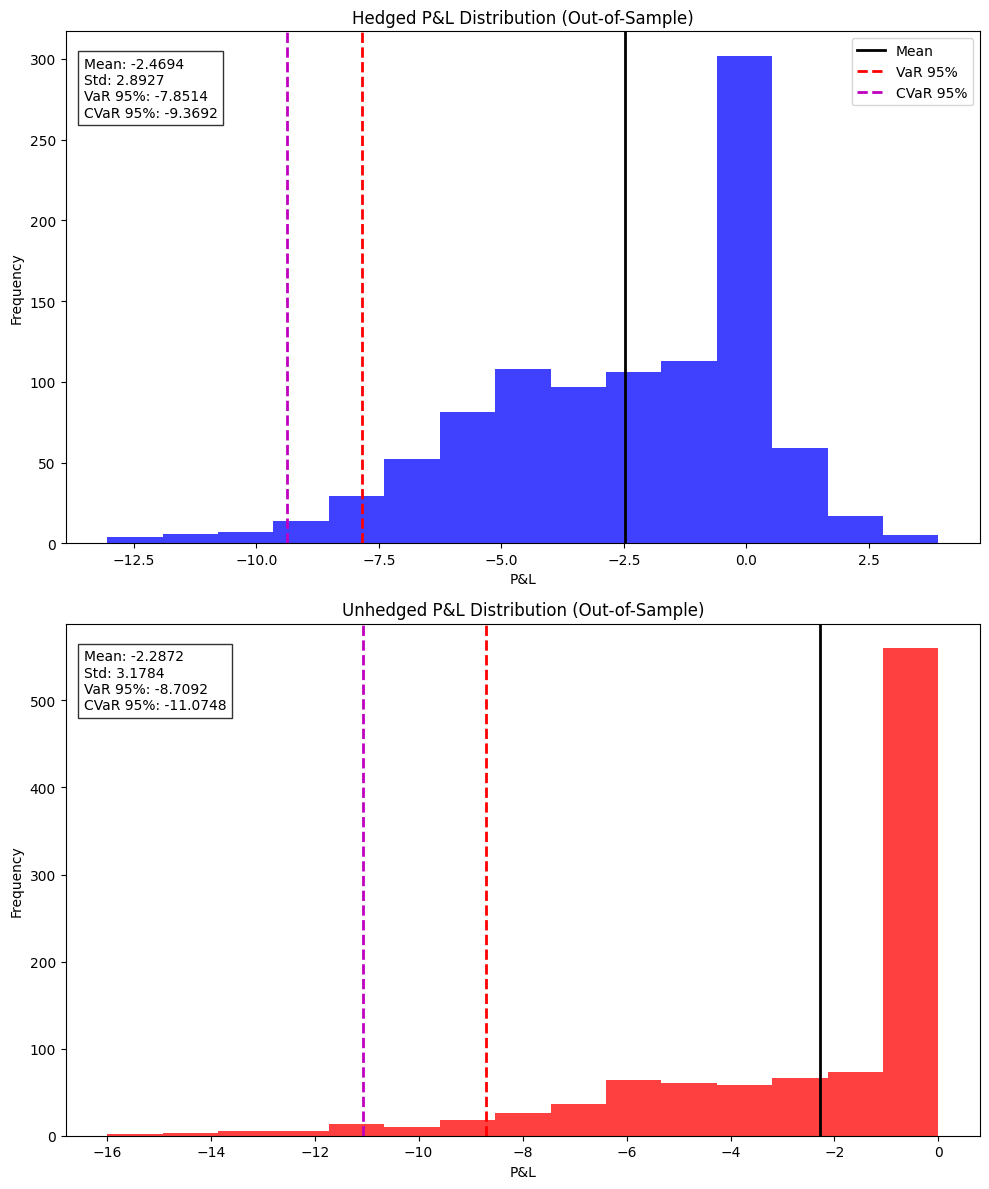

Risk Reduction from Hedging:
VaR Improvement: -0.8577
CVaR Improvement: -1.7056
Std Dev Reduction: 0.2857
---------------------------


In [11]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [3, 4, 5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1.5 CONST [5, 7, 9]

this itteration the r_sig = 1.5, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.8821
  Variance: 0.031588
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.1048
  Current PnL: 0.0000
  Moneyness (S/K): 0.9988
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.8821
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400

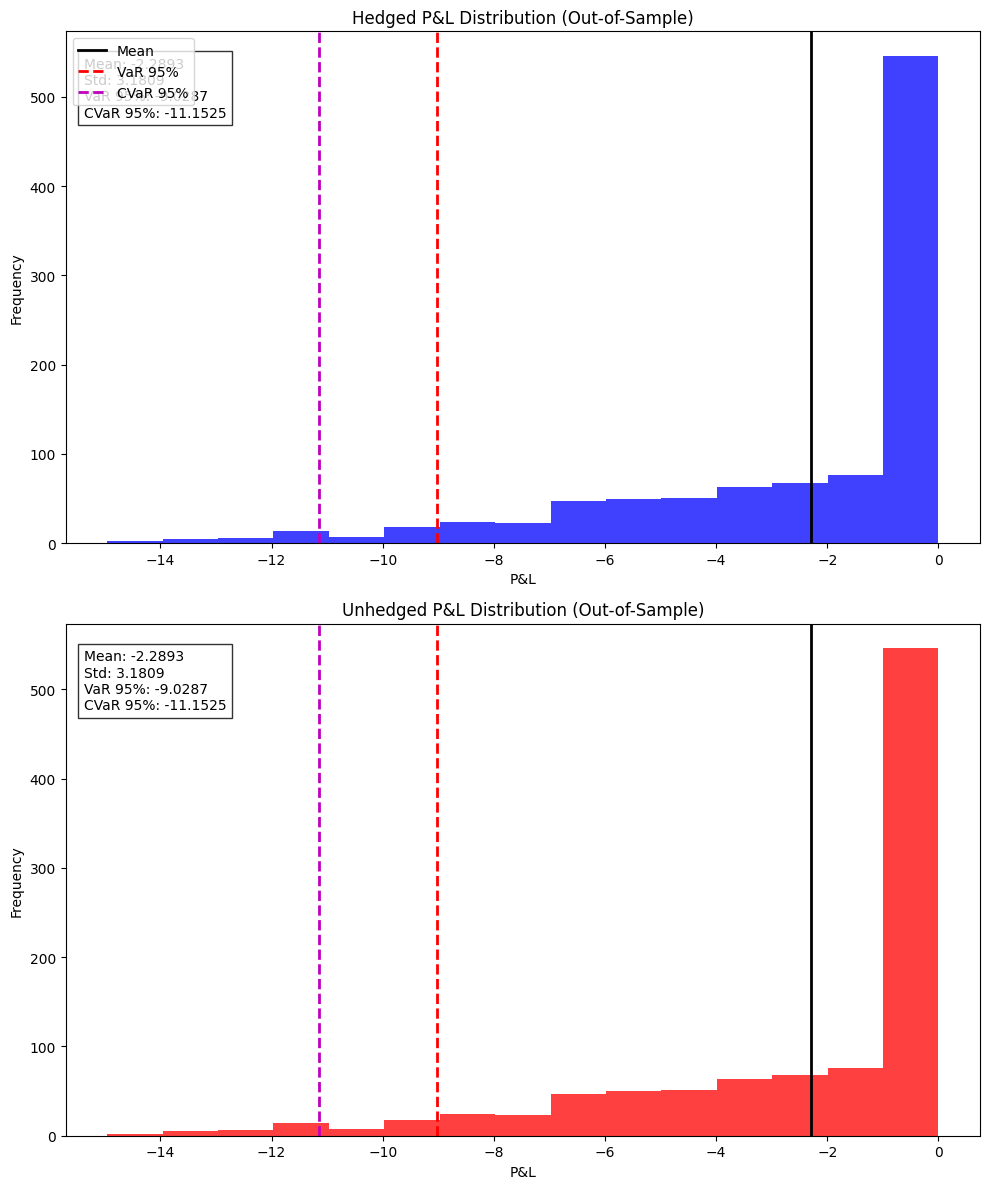

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: -0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 1.5, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.2598
  Variance: 0.060655
  Time to Maturity: 0.0000
  Current Position: 0.0128
  Cash Balance: -3.6183
  Rebalancing Day: True
  Transaction Cost: 0.0017
  Reward: 2.1633
  Current PnL: -2.3560
  Moneyness (S/K): 0.9826
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.2598
  Option Payoff: 0.0000
  Portfolio Value: -2.3560
  Hedging Error: -2.3560
  Total Cost: 0.1804
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

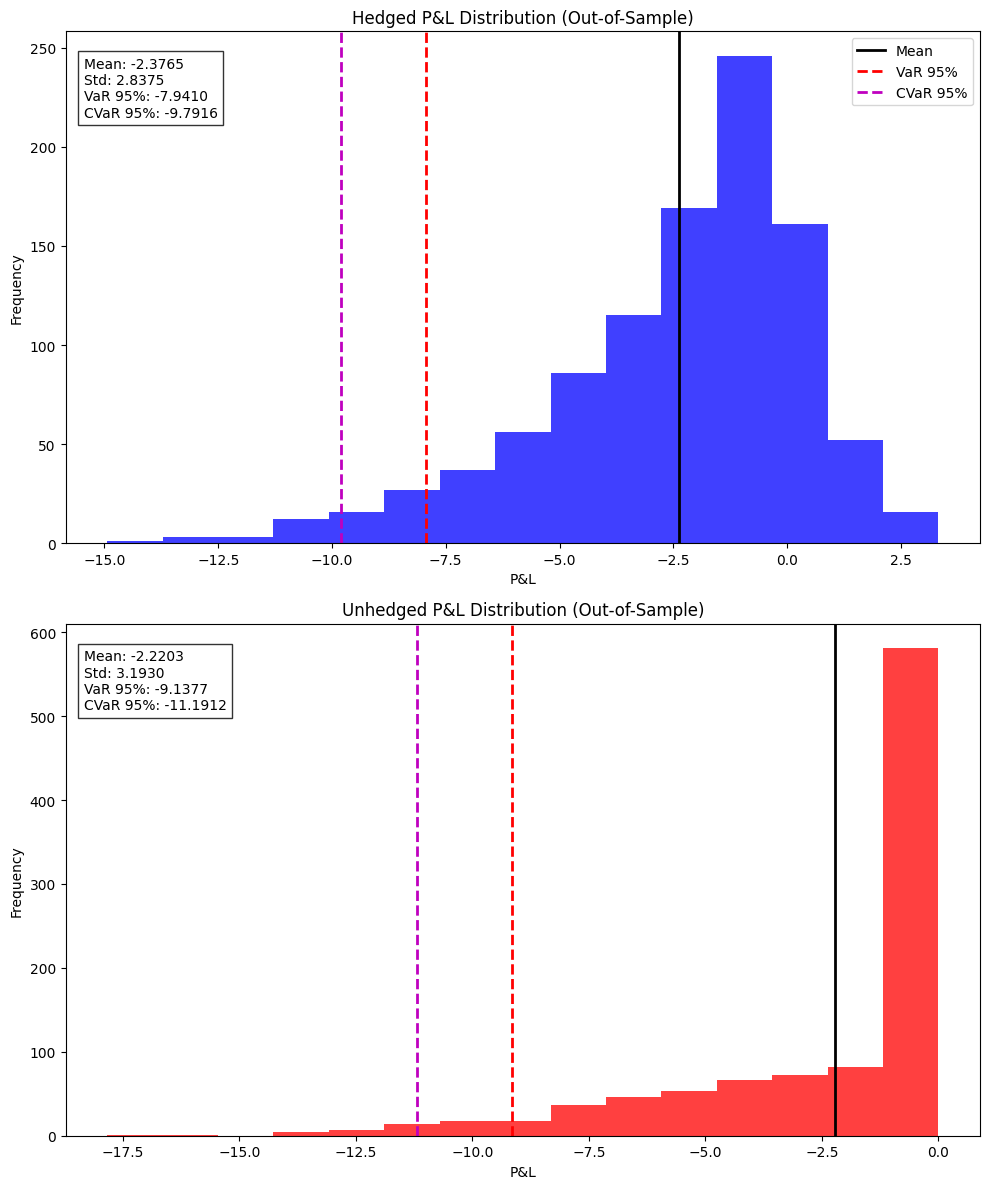

Risk Reduction from Hedging:
VaR Improvement: -1.1967
CVaR Improvement: -1.3996
Std Dev Reduction: 0.3556
---------------------------
this itteration the r_sig = 1.5, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 101.7061
  Variance: 0.024007
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.9335
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 7.5062
  Current PnL: -0.9335
  Moneyness (S/K): 1.0171
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 101.7061
  Option Payoff: 1.7061
  Portfolio Value: 0.7725
  Hedging Error: -0.9335
  Total Cost: 0.2616
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

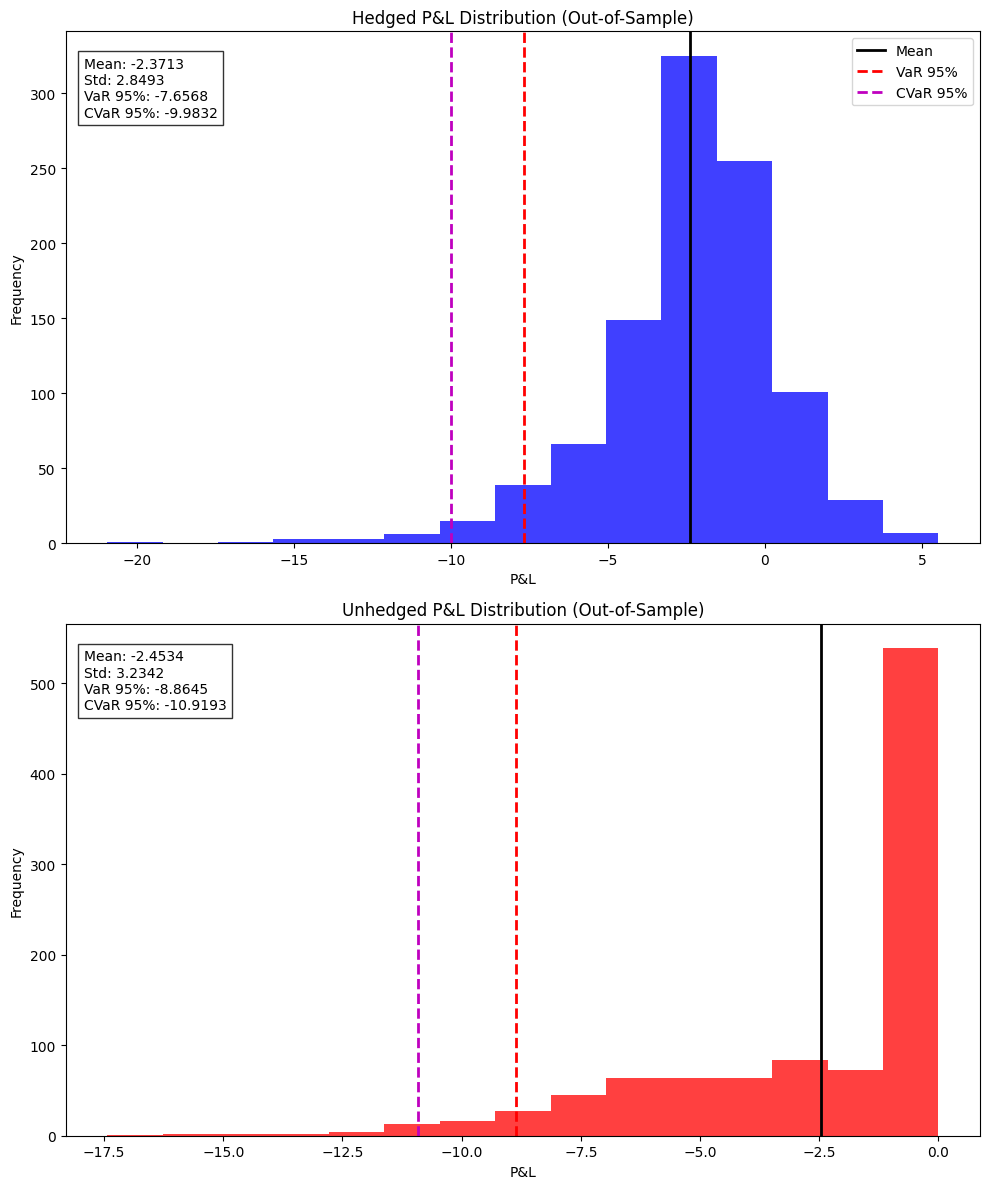

Risk Reduction from Hedging:
VaR Improvement: -1.2078
CVaR Improvement: -0.9361
Std Dev Reduction: 0.3849
---------------------------


In [12]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST 7 80K STEPS DIDINT WORK 
40K TOTAL STEPS WORKS FINE

more training for TD3 sigma 1 const 7

this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.8763
  Variance: 0.031982
  Time to Maturity: 0.0000
  Current Position: 0.9923
  Cash Balance: -99.3855
  Rebalancing Day: True
  Transaction Cost: 0.0112
  Reward: 6.7316
  Current PnL: -0.2802
  Moneyness (S/K): 0.9988
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.8763
  Option Payoff: 0.0000
  Portfolio Value: -0.2802
  Hedging Error: -0.2802
  Total Cost: 0.1784
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/

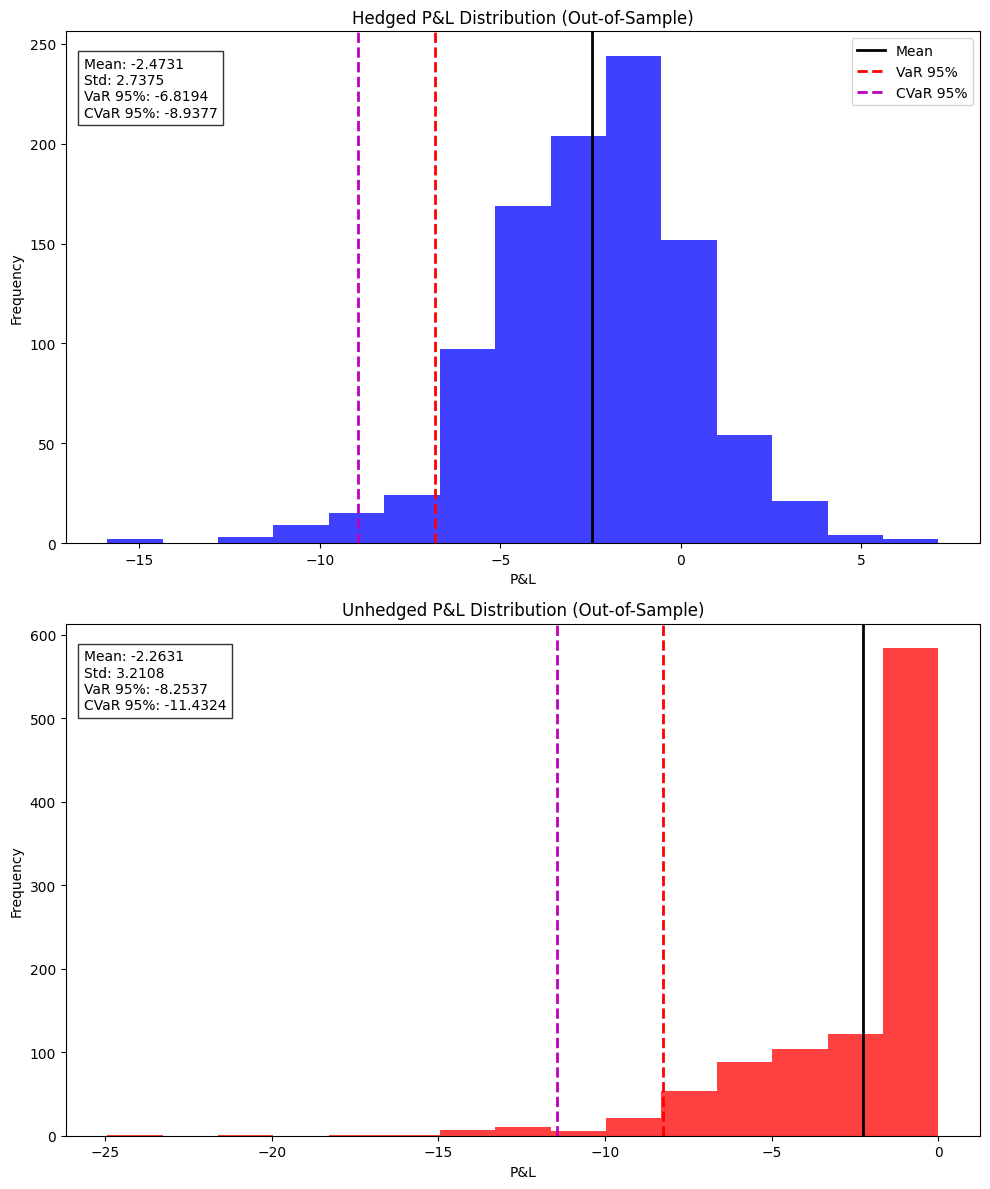

Risk Reduction from Hedging:
VaR Improvement: -1.4342
CVaR Improvement: -2.4947
Std Dev Reduction: 0.4733
---------------------------


In [15]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST 7 TOTAL_STEPS = [10K, 20K, 30K, 50K]

this itteration did 10000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 90.9681
  Variance: 0.047882
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.1052
  Current PnL: 0.0000
  Moneyness (S/K): 0.9097
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 90.9681
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock P

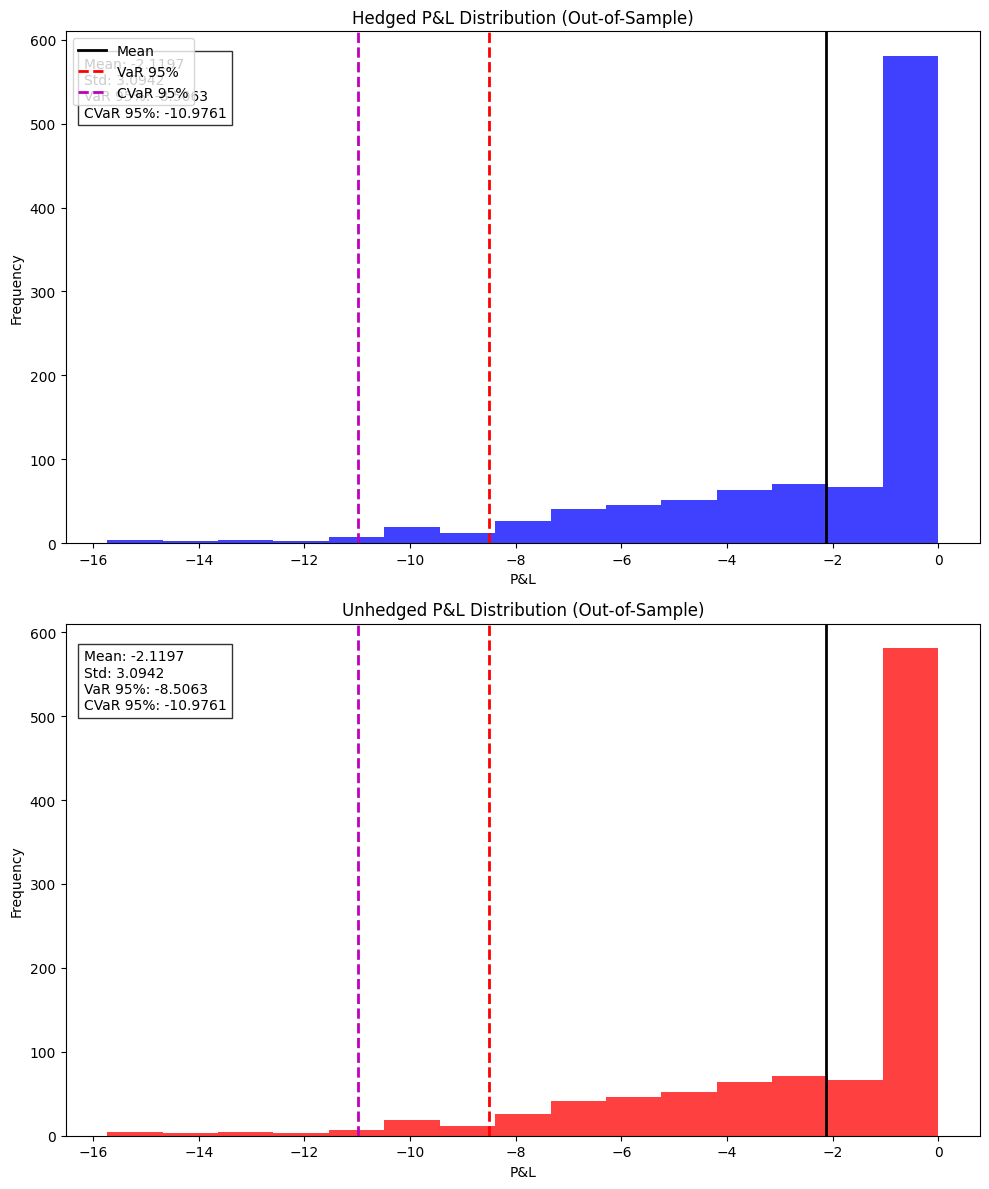

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration did 20000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.1115
  Variance: 0.048072
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.1099
  Current PnL: 0.0000
  Moneyness (S/K): 0.9311
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.1115
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0

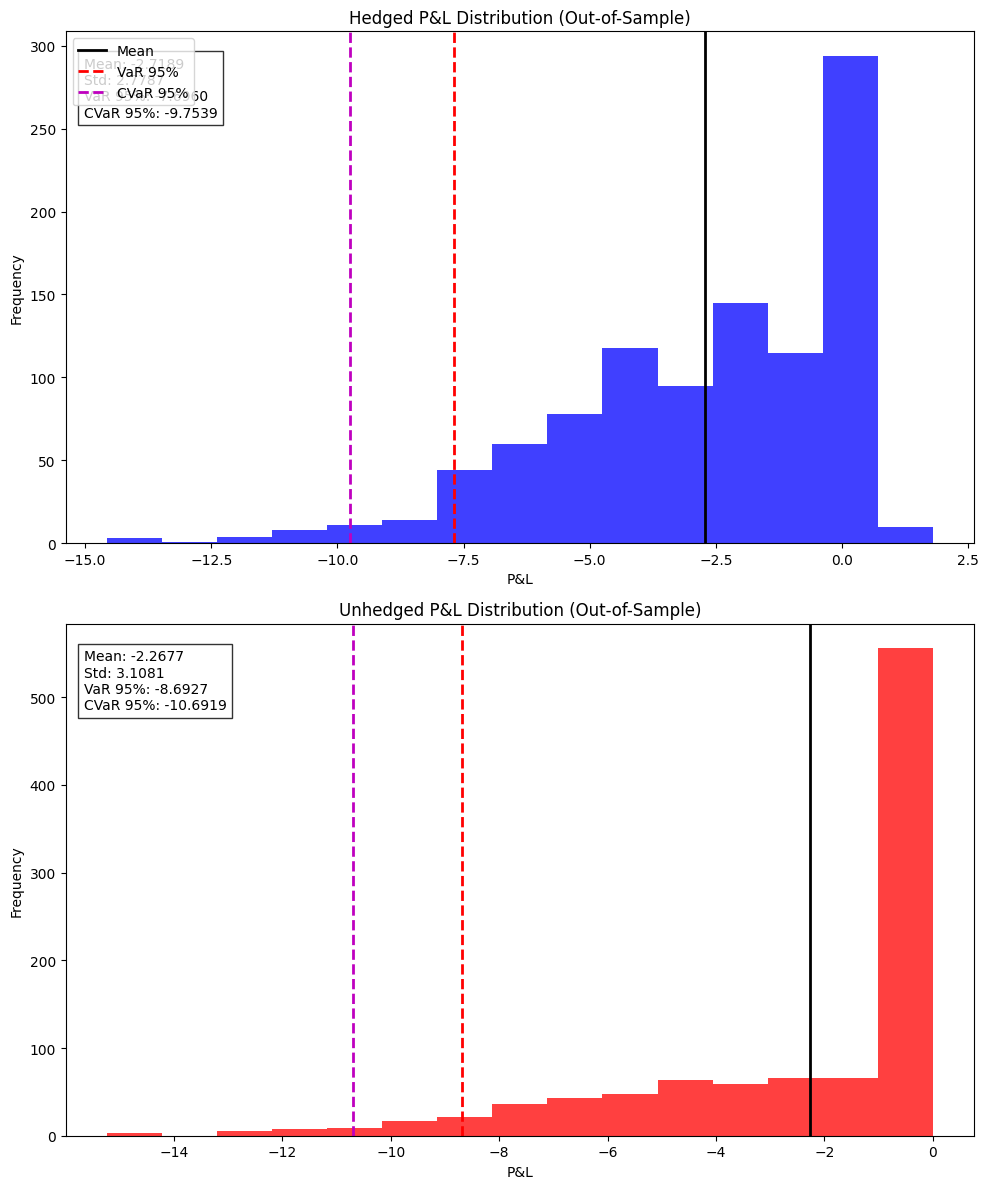

Risk Reduction from Hedging:
VaR Improvement: -0.9966
CVaR Improvement: -0.9380
Std Dev Reduction: 0.3294
---------------------------
this itteration did 30000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.7978
  Variance: 0.047502
  Time to Maturity: 0.0000
  Current Position: 0.4032
  Cash Balance: -40.2501
  Rebalancing Day: True
  Transaction Cost: 0.0190
  Reward: 9.1087
  Current PnL: -0.0138
  Moneyness (S/K): 0.9980
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.7978
  Option Payoff: 0.0000
  Portfolio Value: -0.0138
  Hedging Error: -0.0138
  Total Cost: 0.2525
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Vari

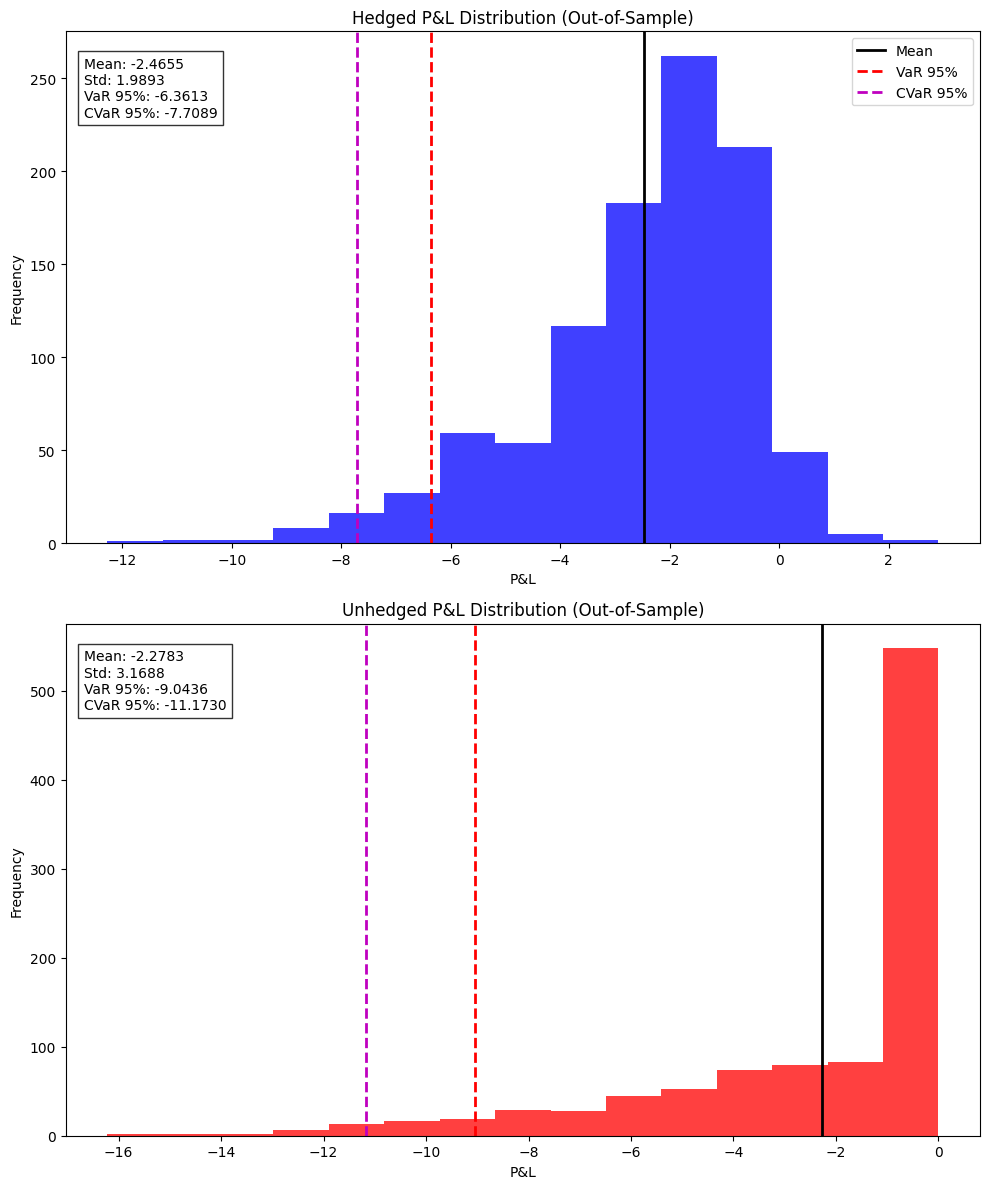

Risk Reduction from Hedging:
VaR Improvement: -2.6822
CVaR Improvement: -3.4641
Std Dev Reduction: 1.1794
---------------------------
this itteration did 50000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.4417
  Variance: 0.028604
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -98.6318
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.8853
  Current PnL: -2.1901
  Moneyness (S/K): 0.9644
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.4417
  Option Payoff: 0.0000
  Portfolio Value: -2.1901
  Hedging Error: -2.1901
  Total Cost: 0.1836
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Vari

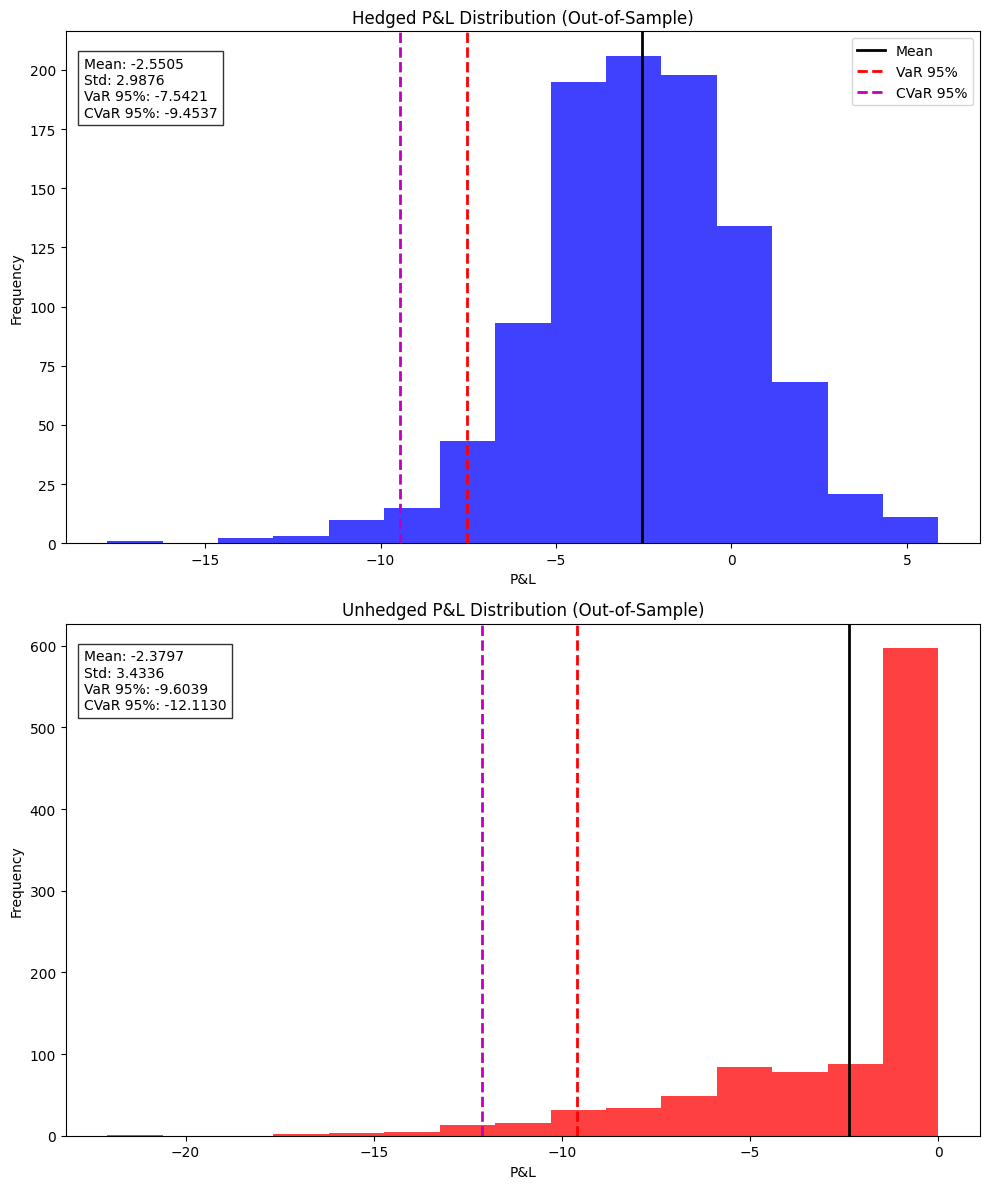

Risk Reduction from Hedging:
VaR Improvement: -2.0618
CVaR Improvement: -2.6593
Std Dev Reduction: 0.4460
---------------------------


In [33]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
r_consts = 7

NUMS = [10_000, 20_000, 30_000, 50_000]

for NUM in NUMS:

    print(f'this itteration did {NUM} total steps')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=NUM)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST 7 TOTAL_STEPS = [35K, 45K]

this itteration did 35000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.6479
  Variance: 0.057749
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.1207
  Current PnL: 0.0000
  Moneyness (S/K): 0.9365
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.6479
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock P

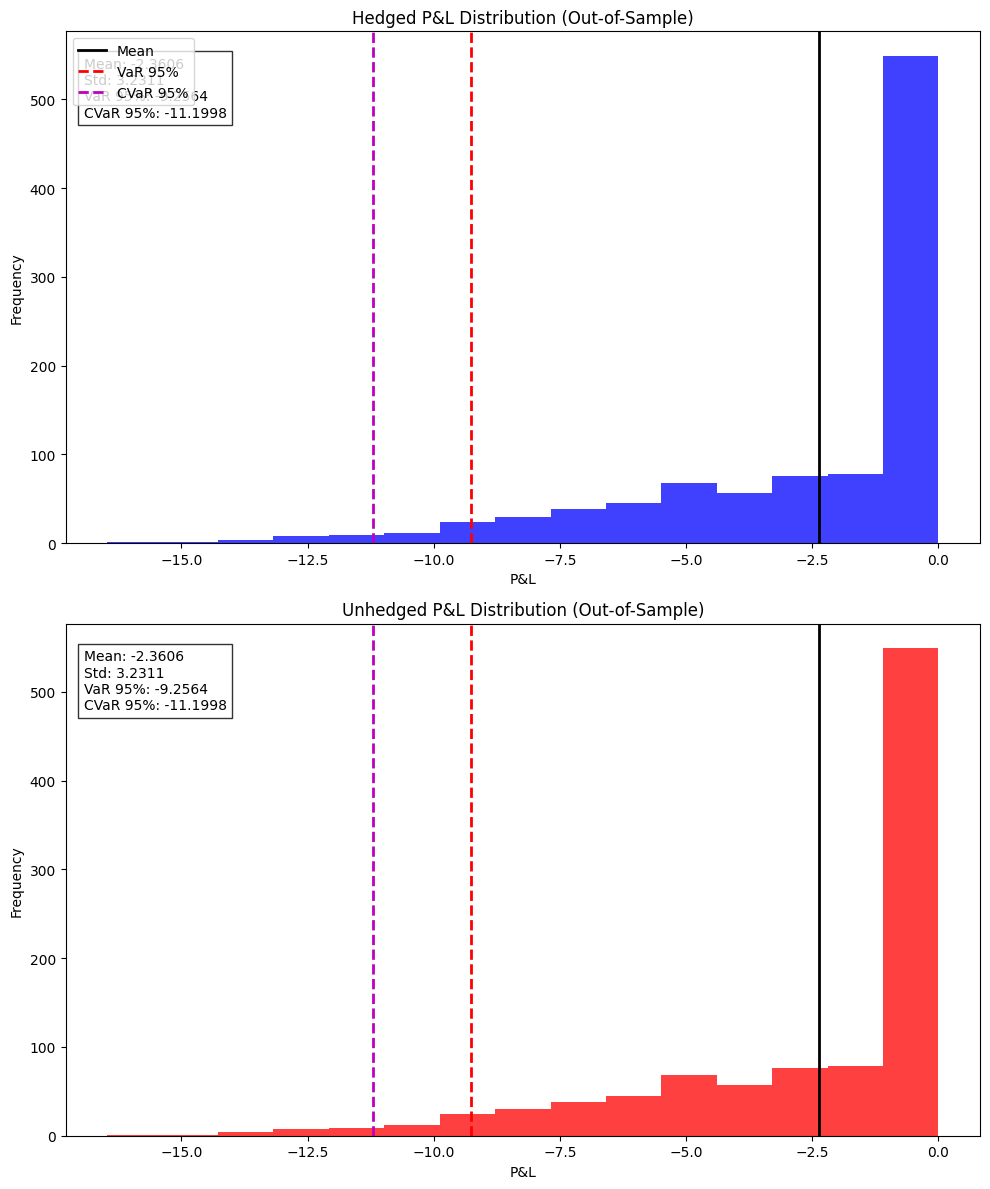

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration did 45000 total steps
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 92.0872
  Variance: 0.043252
  Time to Maturity: 0.0000
  Current Position: 0.6479
  Cash Balance: -63.4526
  Rebalancing Day: True
  Transaction Cost: 0.0030
  Reward: 0.2207
  Current PnL: -3.7879
  Moneyness (S/K): 0.9209
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 92.0872
  Option Payoff: 0.0000
  Portfolio Value: -3.7879
  Hedging Error: -3.7879
  Total Cost: 0.1672
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Varian

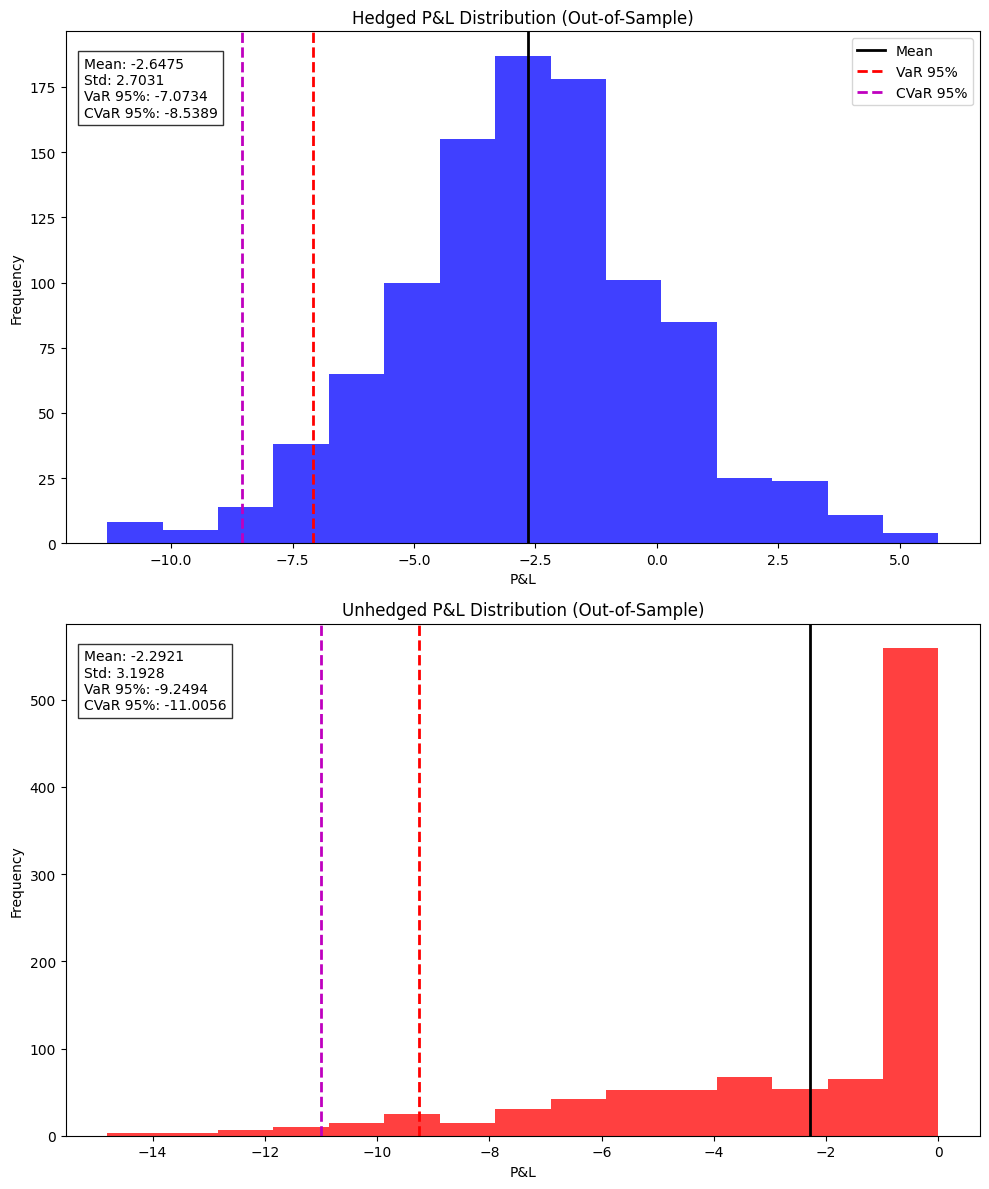

Risk Reduction from Hedging:
VaR Improvement: -2.1760
CVaR Improvement: -2.4667
Std Dev Reduction: 0.4898
---------------------------


In [34]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
r_consts = 7

NUMS = [35_000, 45_000]

for NUM in NUMS:

    print(f'this itteration did {NUM} total steps')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=NUM)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST 6 TS 40K

this itteration the r_sig = 1, and r_const = 6


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.7773
  Variance: 0.043113
  Time to Maturity: 0.0000
  Current Position: 0.0775
  Cash Balance: -9.2897
  Rebalancing Day: True
  Transaction Cost: 0.0102
  Reward: 1.2736
  Current PnL: -1.7930
  Moneyness (S/K): 0.9678
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.7773
  Option Payoff: 0.0000
  Portfolio Value: -1.7930
  Hedging Error: -1.7930
  Total Cost: 0.1501
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 100.7800
  Variance: 0.05987

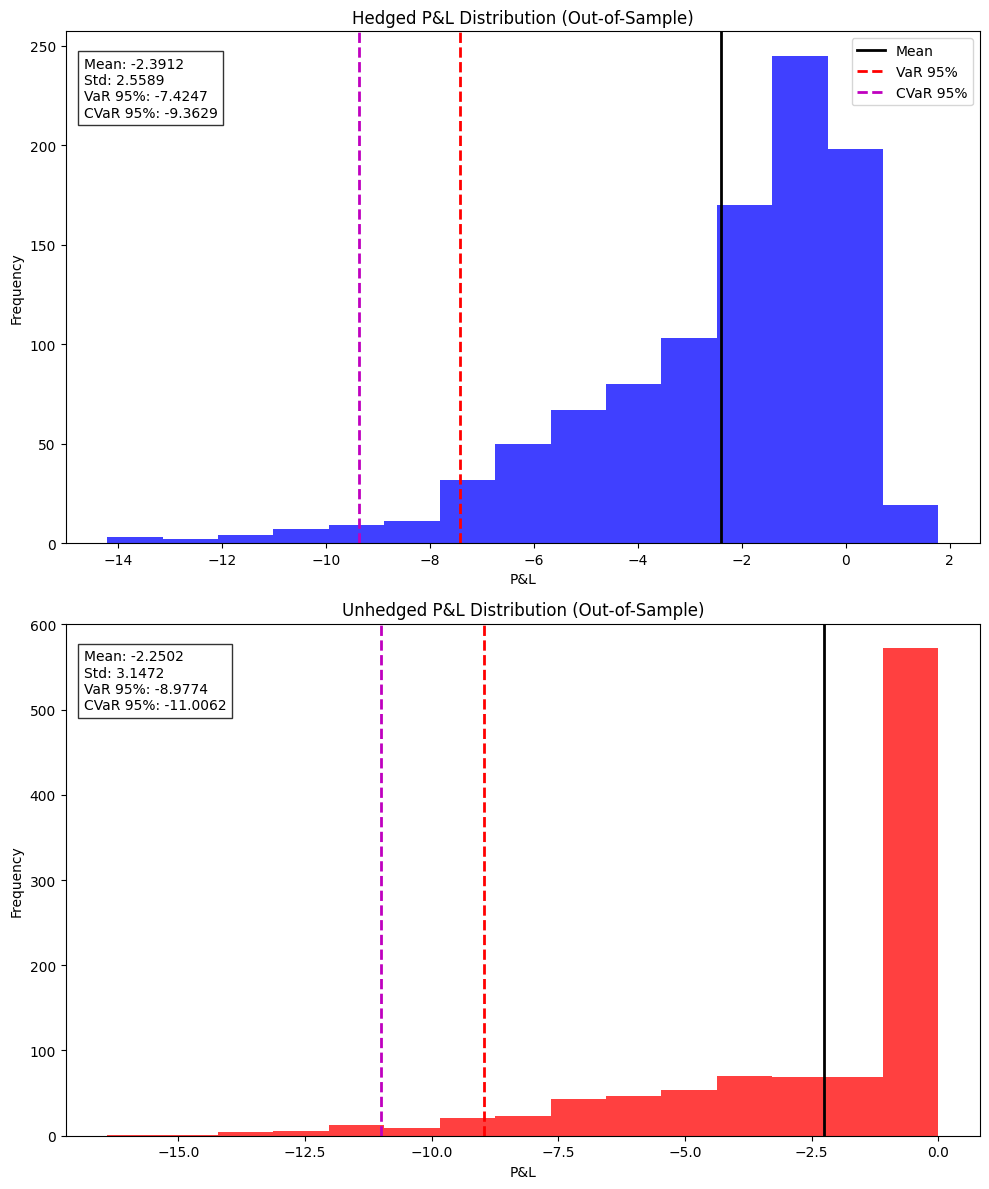

Risk Reduction from Hedging:
VaR Improvement: -1.5527
CVaR Improvement: -1.6432
Std Dev Reduction: 0.5883
---------------------------


In [6]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [6]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 SIGMA 1 CONST 7 40K_TS 10K_PATHS

this itteration the r_sig = 1, and r_const = 7


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 105.3359
  Variance: 0.041264
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.0924
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 7.0949
  Current PnL: -0.0925
  Moneyness (S/K): 1.0534
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 105.3359
  Option Payoff: 5.3359
  Portfolio Value: 5.2434
  Hedging Error: -0.0925
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 1000/10000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 83.3513
  Variance: 0.052805
  Time to Maturity: 0.0000
  Current Position: 0.9298
  Cash Balance: -91.8300
  Rebalancing Day: True
  Transaction Cost: 0.0093
  Reward

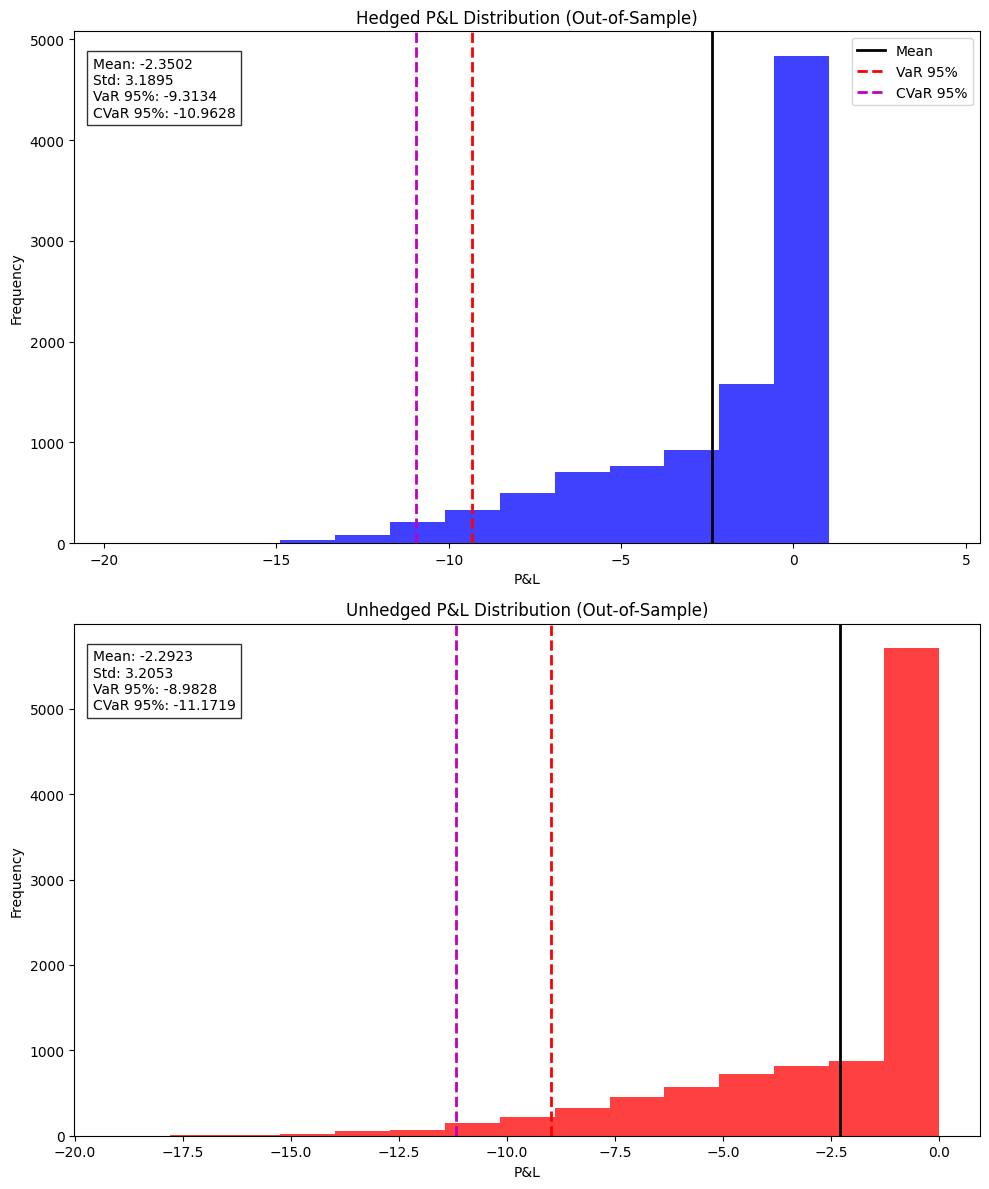

Risk Reduction from Hedging:
VaR Improvement: 0.3305
CVaR Improvement: -0.2091
Std Dev Reduction: 0.0158
---------------------------


In [61]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 10000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=1000)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 s1 c7 40k training

In [62]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)

this itteration the r_sig = 1, and r_const = 7


now n_paths = 1000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 92.9903
  Variance: 0.052719
  Time to Maturity: 0.0000
  Current Position: 0.0325
  Cash Balance: -2.9277
  Rebalancing Day: True
  Transaction Cost: 0.0102
  Reward: 7.0091
  Current PnL: 0.0912
  Moneyness (S/K): 0.9299
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 92.9903
  Option Payoff: 0.0000
  Portfolio Value: 0.0912
  Hedging Error: 0.0912
  Total Cost: 0.0565
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stoc

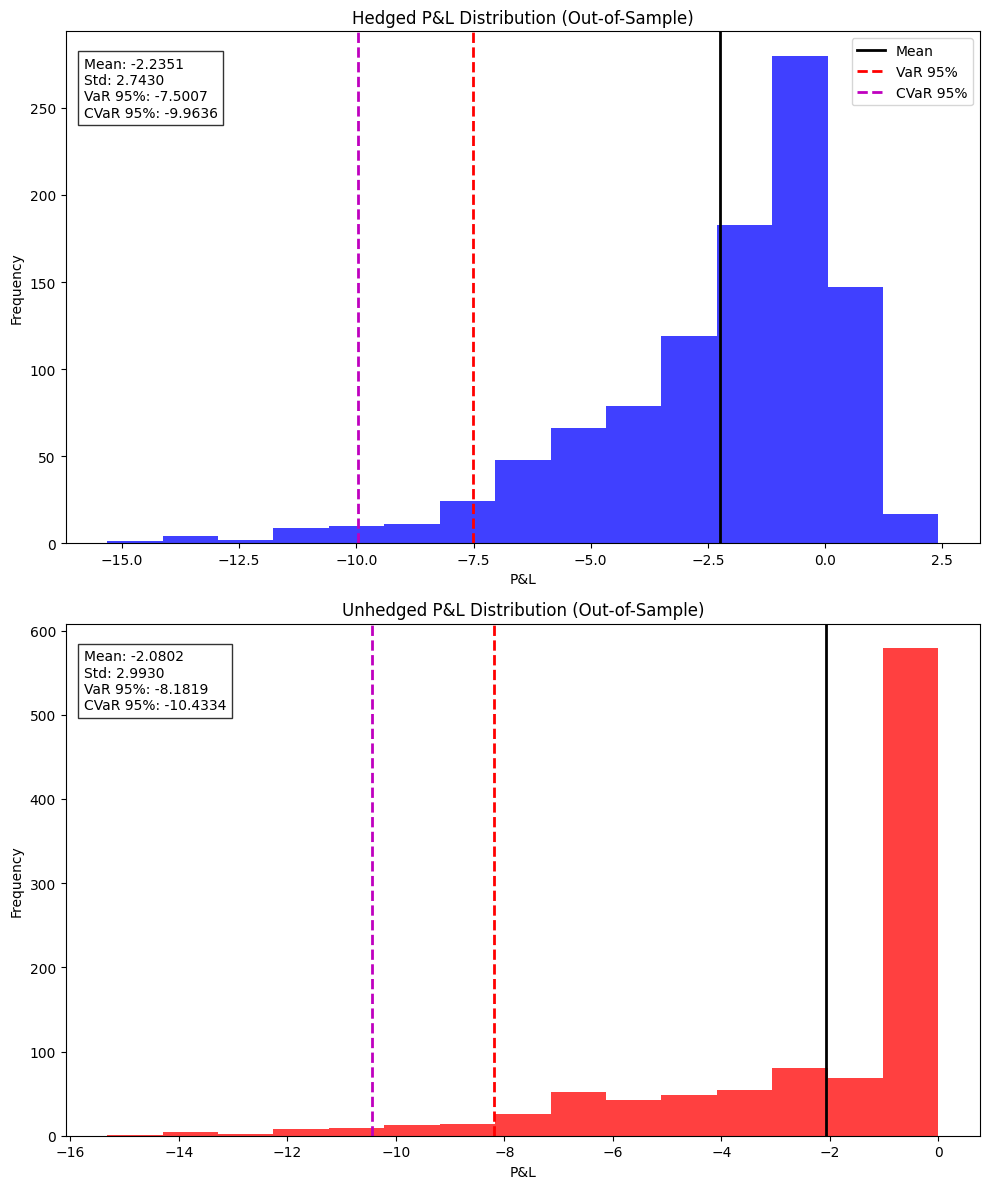

Risk Reduction from Hedging:
VaR Improvement: -0.6812
CVaR Improvement: -0.4698
Std Dev Reduction: 0.2500
---------------------------
now n_paths = 2000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.3388
  Variance: 0.043772
  Time to Maturity: 0.0000
  Current Position: 0.2650
  Cash Balance: -28.4648
  Rebalancing Day: True
  Transaction Cost: 0.0121
  Reward: 0.7835
  Current PnL: -2.1374
  Moneyness (S/K): 0.9934
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.3388
  Option Payoff: 0.0000
  Portfolio Value: -2.1374
  Hedging Error: -2.1374
  Total Cost: 0.1819
  Total Rebalances: 22
Progress: 200/2000 paths evaluated
Progress: 400/2000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalanci

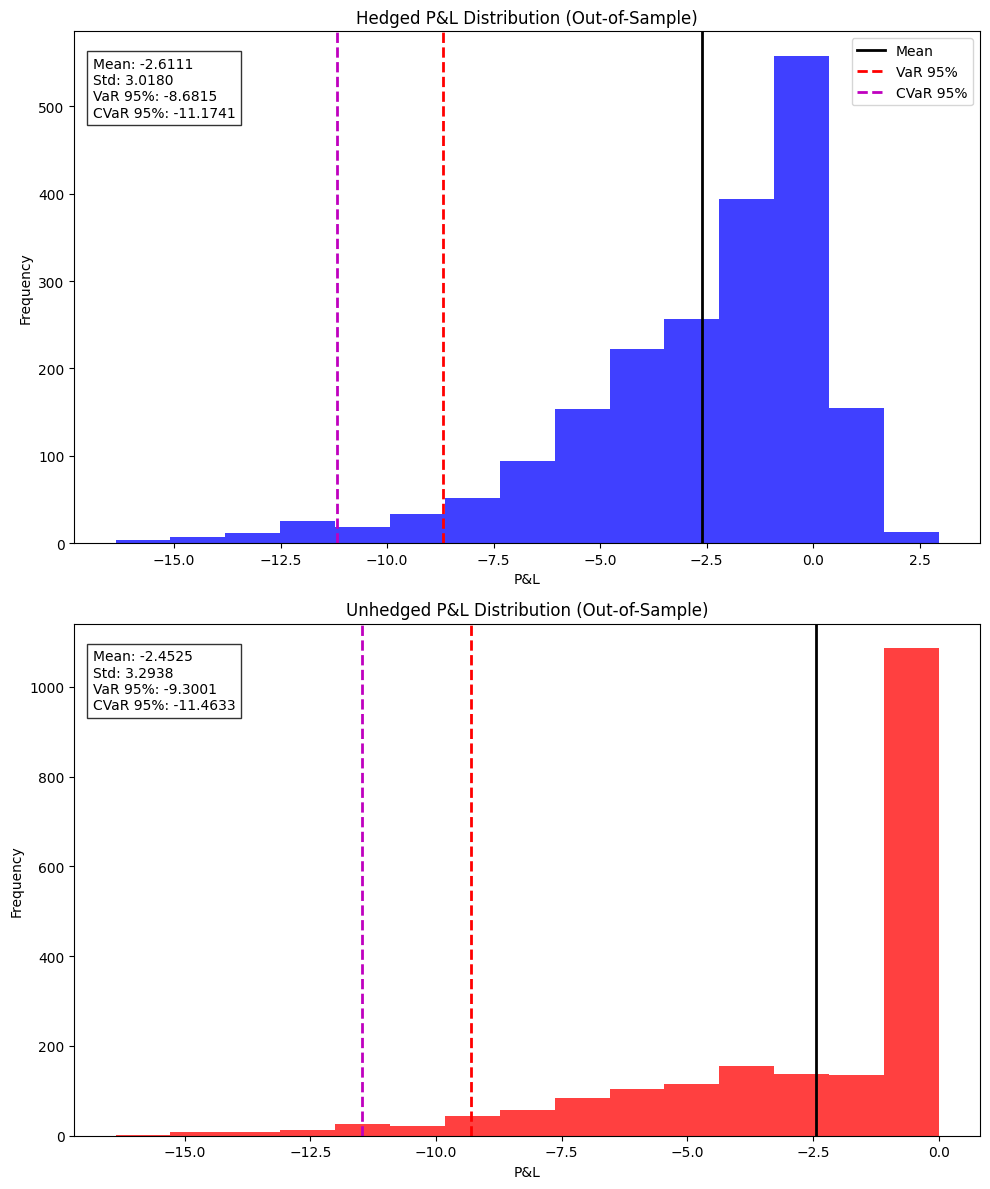

Risk Reduction from Hedging:
VaR Improvement: -0.6186
CVaR Improvement: -0.2892
Std Dev Reduction: 0.2757
---------------------------
now n_paths = 3000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 103.9252
  Variance: 0.012283
  Time to Maturity: 0.0000
  Current Position: 0.2202
  Cash Balance: -22.5139
  Rebalancing Day: True
  Transaction Cost: 0.0156
  Reward: -0.0092
  Current PnL: -3.5576
  Moneyness (S/K): 1.0393
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 103.9252
  Option Payoff: 3.9252
  Portfolio Value: 0.3676
  Hedging Error: -3.5576
  Total Cost: 0.3073
  Total Rebalances: 22
Progress: 300/3000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Pr

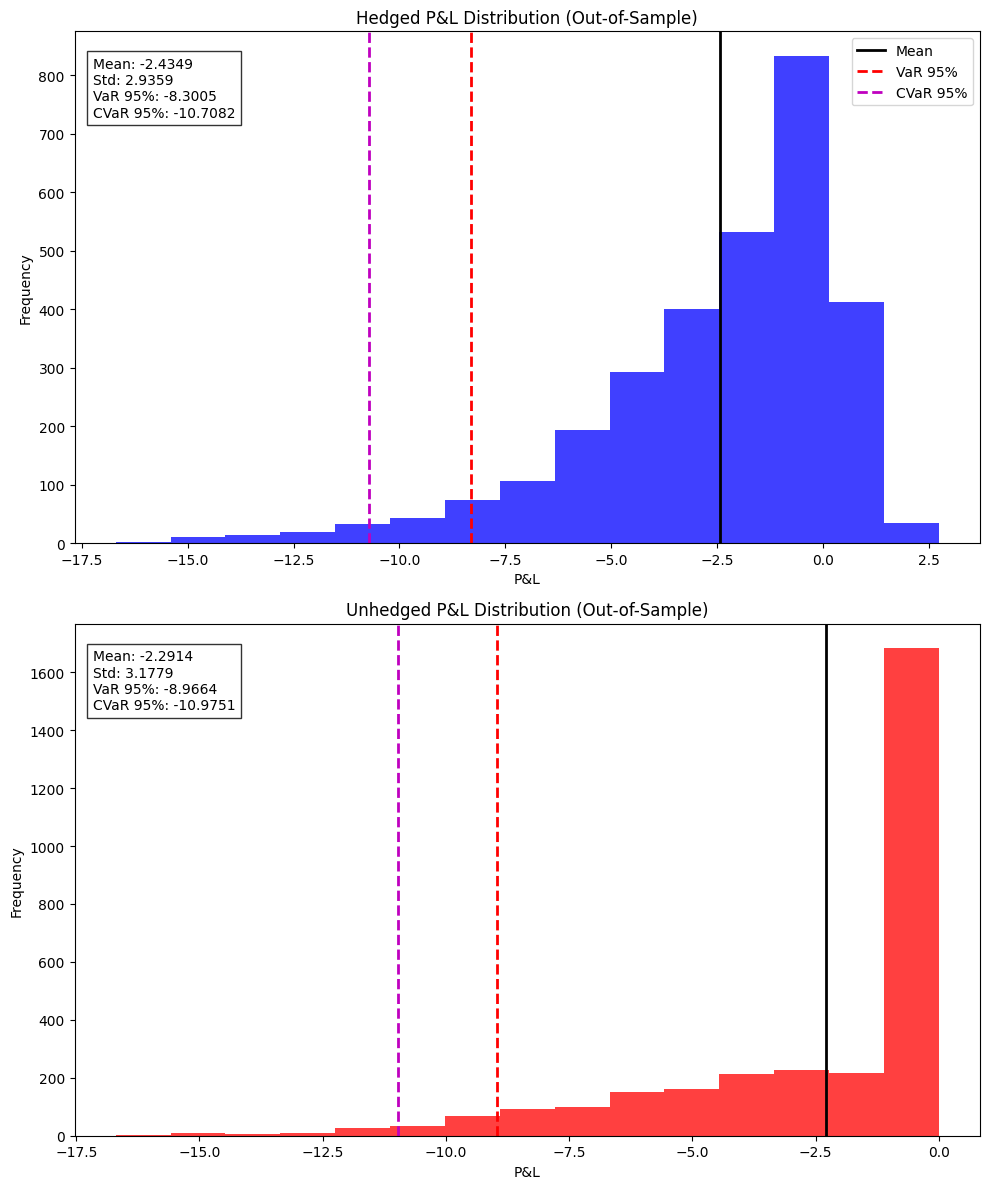

Risk Reduction from Hedging:
VaR Improvement: -0.6659
CVaR Improvement: -0.2669
Std Dev Reduction: 0.2420
---------------------------
now n_paths = 4000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.3702
  Variance: 0.039977
  Time to Maturity: 0.0000
  Current Position: 0.0510
  Cash Balance: -5.5086
  Rebalancing Day: True
  Transaction Cost: 0.0114
  Reward: 6.2395
  Current PnL: -0.4876
  Moneyness (S/K): 0.9837
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.3702
  Option Payoff: 0.0000
  Portfolio Value: -0.4876
  Hedging Error: -0.4876
  Total Cost: 0.3236
  Total Rebalances: 22
Progress: 400/4000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock P

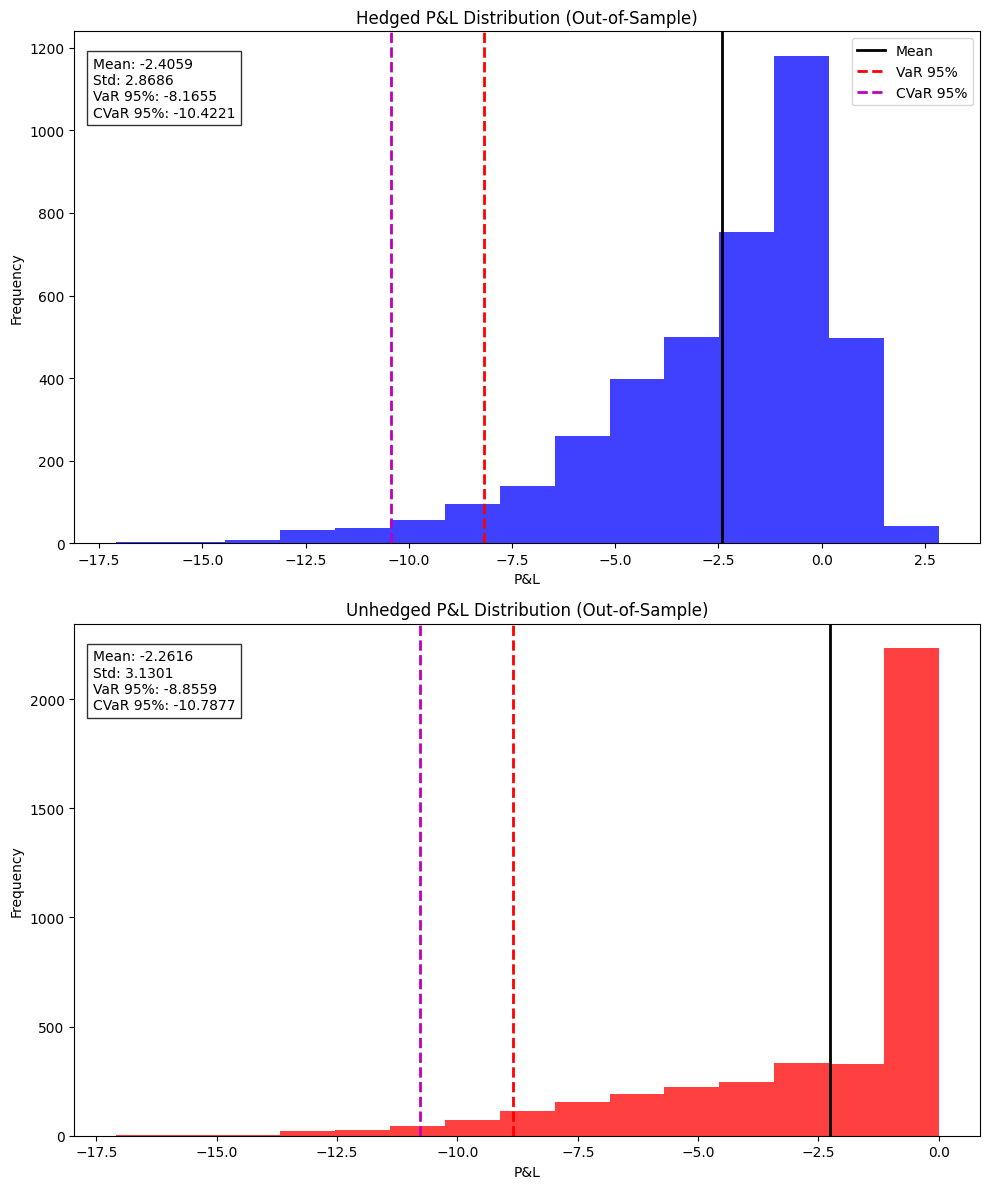

Risk Reduction from Hedging:
VaR Improvement: -0.6904
CVaR Improvement: -0.3656
Std Dev Reduction: 0.2615
---------------------------


In [63]:
N_PATHS = [1000, 2000, 3000, 4000]
for n_paths in N_PATHS:

    print(f'now n_paths = {n_paths} are in consideration')
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)

    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 S0.5 C5 40k training [FINAL]

In [64]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)

this itteration the r_sig = 0.5, and r_const = 5


now n_paths = 1000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 91.8440
  Variance: 0.060183
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -0.2157
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 4.6747
  Current PnL: -0.2157
  Moneyness (S/K): 0.9184
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 91.8440
  Option Payoff: 0.0000
  Portfolio Value: -0.2157
  Hedging Error: -0.2157
  Total Cost: 0.0858
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  S

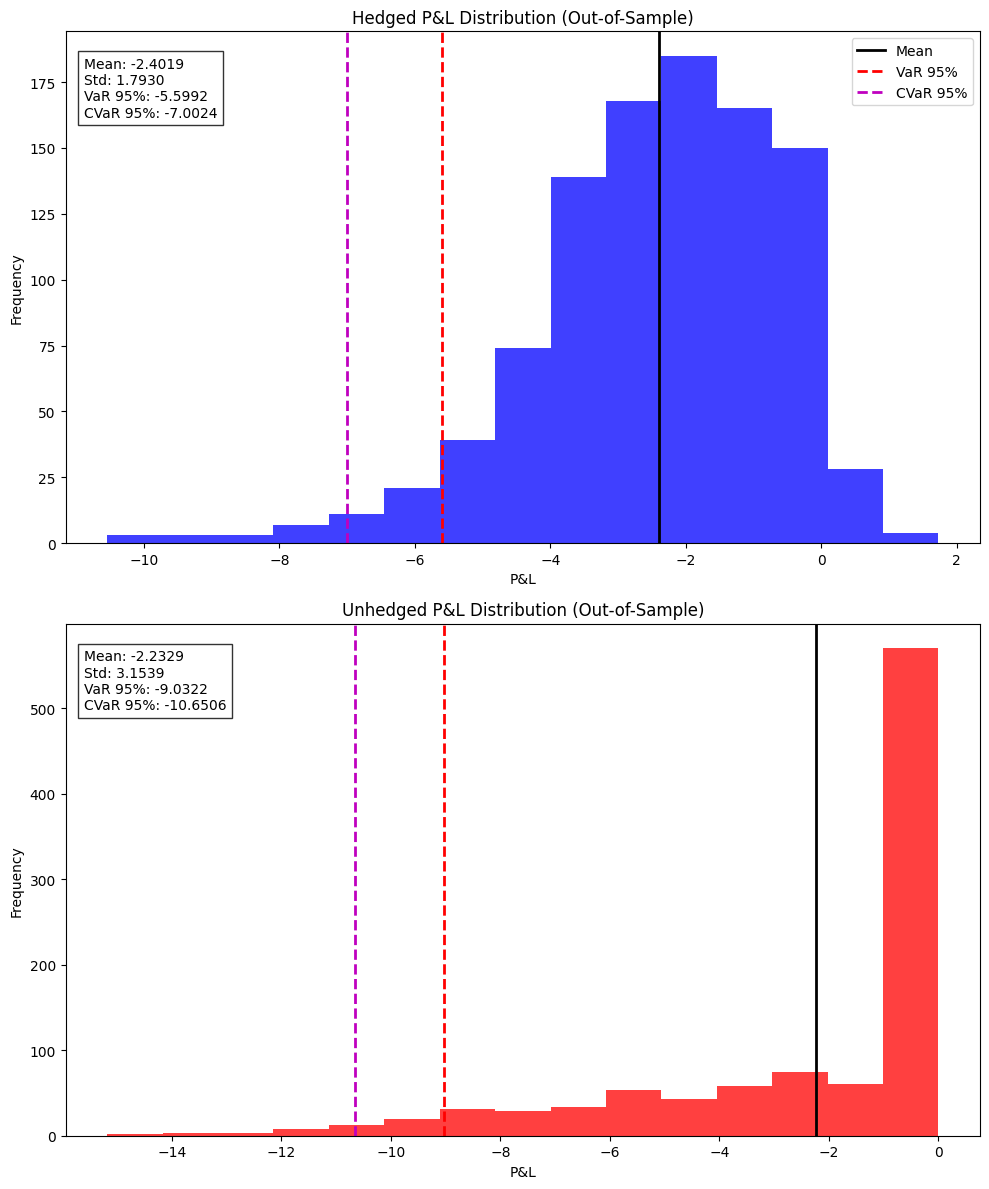

Risk Reduction from Hedging:
VaR Improvement: -3.4330
CVaR Improvement: -3.6482
Std Dev Reduction: 1.3609
---------------------------
now n_paths = 2000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 108.1178
  Variance: 0.021630
  Time to Maturity: 0.0000
  Current Position: 0.2997
  Cash Balance: -27.5335
  Rebalancing Day: True
  Transaction Cost: 0.0359
  Reward: -0.1905
  Current PnL: -3.2474
  Moneyness (S/K): 1.0812
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 108.1178
  Option Payoff: 8.1178
  Portfolio Value: 4.8703
  Hedging Error: -3.2474
  Total Cost: 0.2078
  Total Rebalances: 22
Progress: 200/2000 paths evaluated
Progress: 400/2000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing

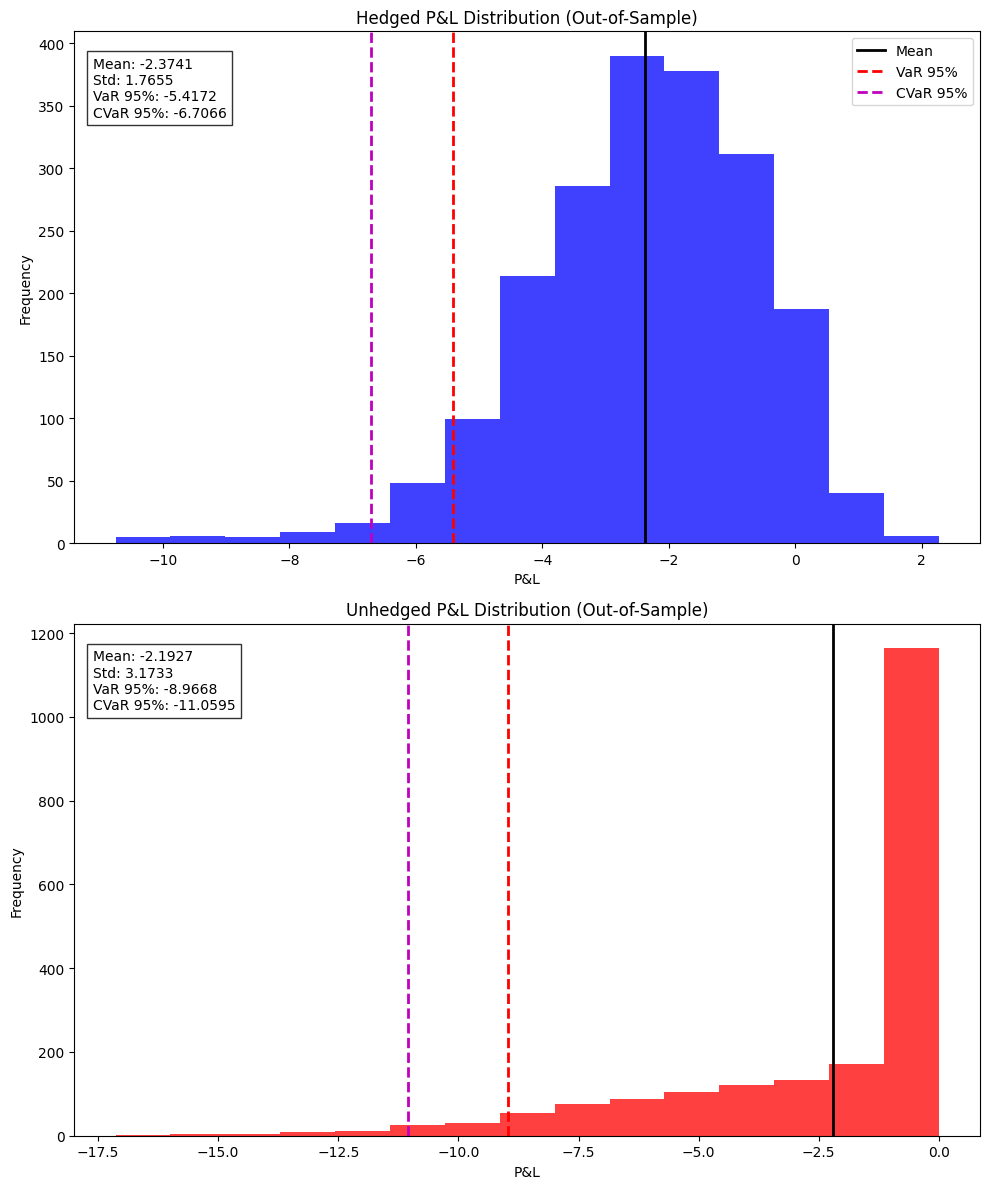

Risk Reduction from Hedging:
VaR Improvement: -3.5496
CVaR Improvement: -4.3529
Std Dev Reduction: 1.4077
---------------------------
now n_paths = 3000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 101.5466
  Variance: 0.023870
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -2.6914
  Rebalancing Day: True
  Transaction Cost: 0.0012
  Reward: -0.0999
  Current PnL: -4.2380
  Moneyness (S/K): 1.0155
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 101.5466
  Option Payoff: 1.5466
  Portfolio Value: -2.6914
  Hedging Error: -4.2380
  Total Cost: 0.2562
  Total Rebalances: 22
Progress: 300/3000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Pr

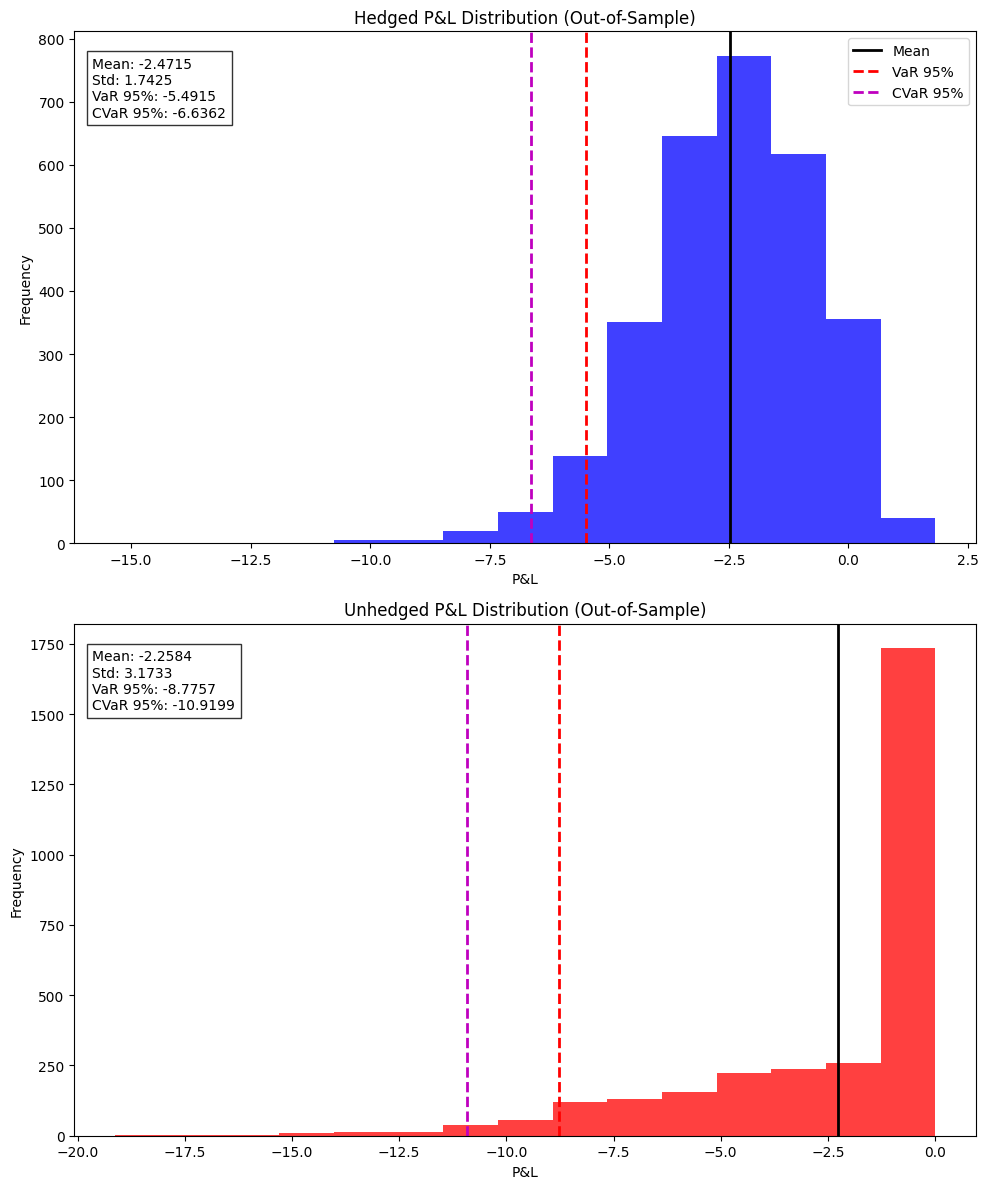

Risk Reduction from Hedging:
VaR Improvement: -3.2842
CVaR Improvement: -4.2837
Std Dev Reduction: 1.4309
---------------------------
now n_paths = 4000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.2610
  Variance: 0.044314
  Time to Maturity: 0.0000
  Current Position: 0.0127
  Cash Balance: -6.2872
  Rebalancing Day: True
  Transaction Cost: 0.0005
  Reward: 0.1111
  Current PnL: -5.0654
  Moneyness (S/K): 0.9626
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.2610
  Option Payoff: 0.0000
  Portfolio Value: -5.0654
  Hedging Error: -5.0654
  Total Cost: 0.1983
  Total Rebalances: 22
Progress: 400/4000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock P

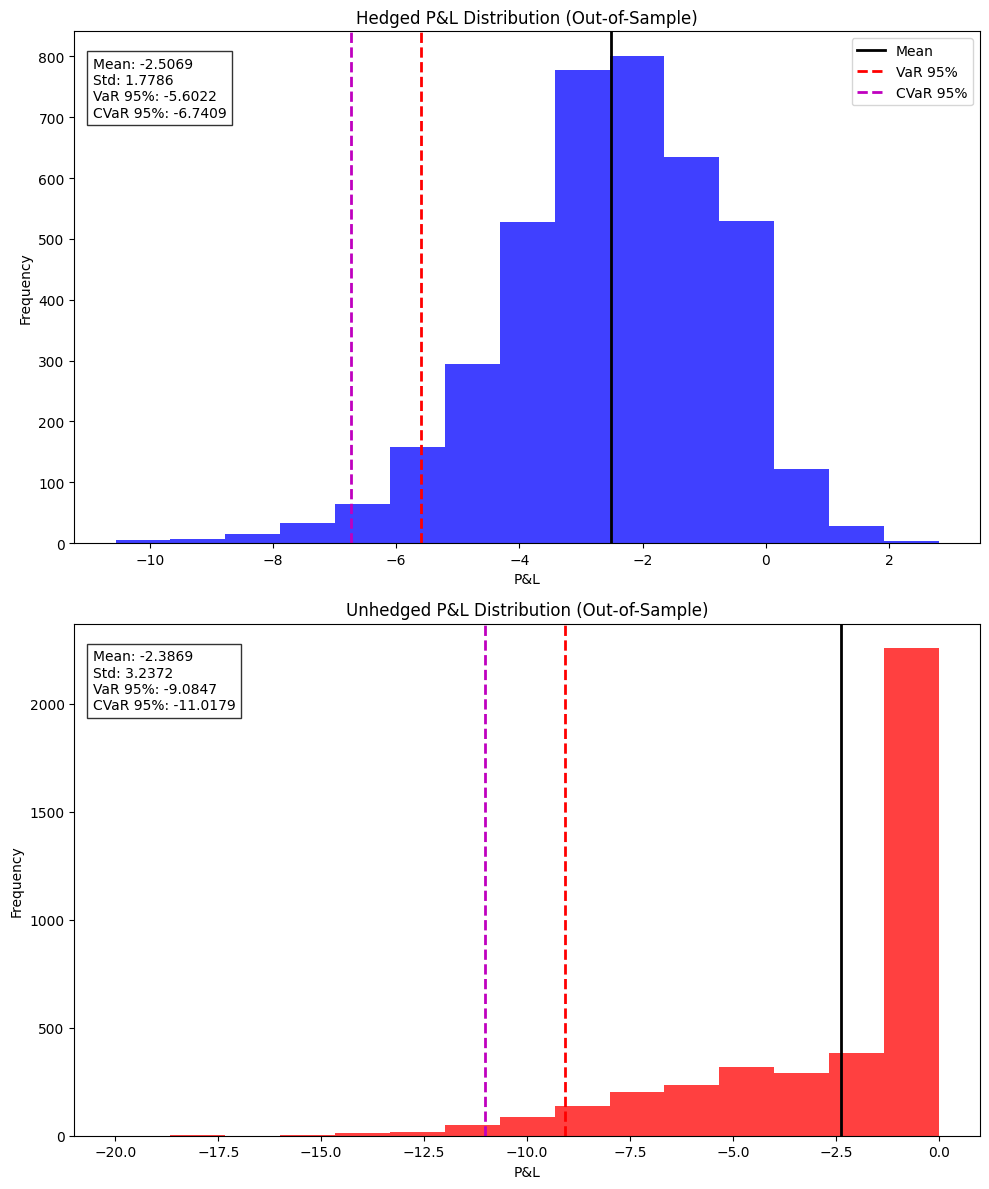

Risk Reduction from Hedging:
VaR Improvement: -3.4825
CVaR Improvement: -4.2771
Std Dev Reduction: 1.4585
---------------------------


In [65]:
N_PATHS = [1000, 4000]
for n_paths in N_PATHS:

    print(f'now n_paths = {n_paths} are in consideration')
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)

    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

In [66]:
model.save('working_td3')

now n_paths = 10000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 109.4695
  Variance: 0.024993
  Time to Maturity: 0.0000
  Current Position: 0.3787
  Cash Balance: -33.5575
  Rebalancing Day: True
  Transaction Cost: 0.0378
  Reward: 0.1257
  Current PnL: -1.5686
  Moneyness (S/K): 1.0947
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 109.4695
  Option Payoff: 9.4695
  Portfolio Value: 7.9009
  Hedging Error: -1.5686
  Total Cost: 0.2000
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 107.6206
  Variance: 0.016749
  Time to Maturity: 0.0000
  Current Position: 0.3761
  Cash Balance: -36.2678
  Rebalancing Day: True
  Transaction Cost: 0.0319
  Re

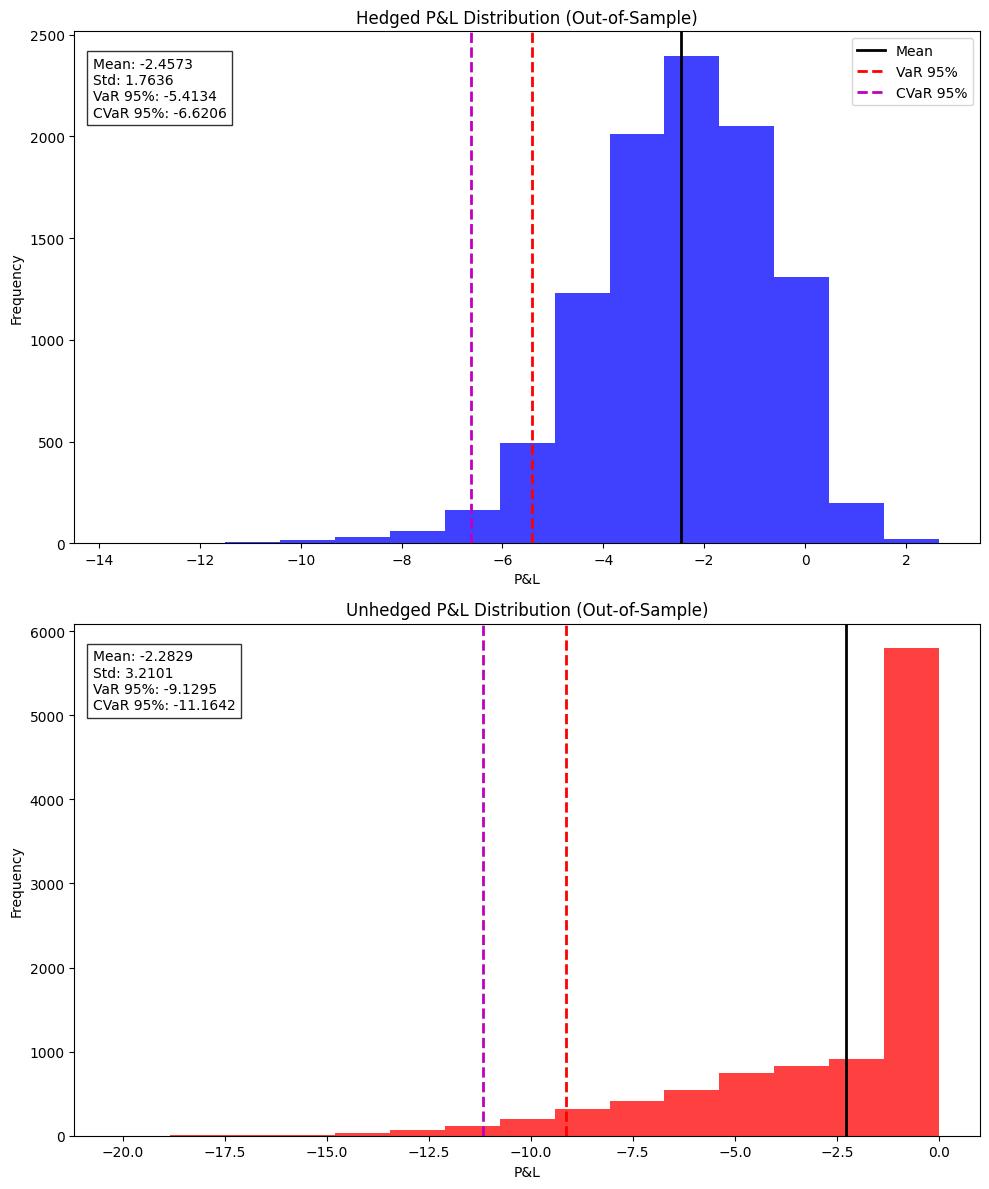

Risk Reduction from Hedging:
VaR Improvement: -3.7160
CVaR Improvement: -4.5436
Std Dev Reduction: 1.4465
---------------------------


In [67]:
N_PATHS = [10000]
for n_paths in N_PATHS:

    print(f'now n_paths = {n_paths} are in consideration')
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)

    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## TD3 change in sigma of noise 

In [10]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.2 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)

this itteration the r_sig = 0.5, and r_const = 5


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


now n_paths = 1000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 104.9898
  Variance: 0.023236
  Time to Maturity: 0.0000
  Current Position: 0.0266
  Cash Balance: -4.6645
  Rebalancing Day: True
  Transaction Cost: 0.0748
  Reward: -0.0696
  Current PnL: -6.8597
  Moneyness (S/K): 1.0499
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 104.9898
  Option Payoff: 4.9898
  Portfolio Value: -1.8698
  Hedging Error: -6.8597
  Total Cost: 0.2087
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  St

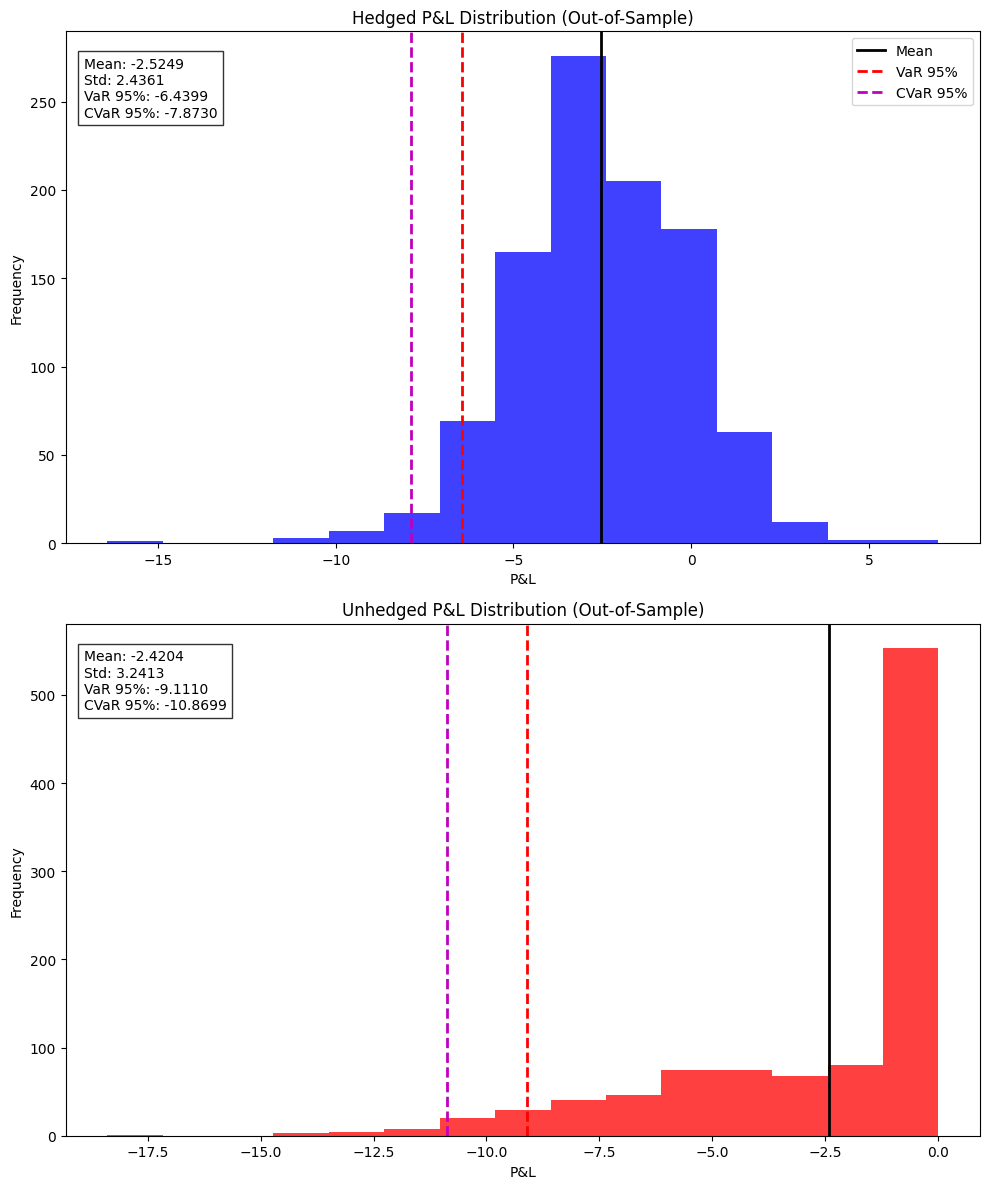

Risk Reduction from Hedging:
VaR Improvement: -2.6711
CVaR Improvement: -2.9969
Std Dev Reduction: 0.8053
---------------------------
now n_paths = 4000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 107.9678
  Variance: 0.044482
  Time to Maturity: 0.0000
  Current Position: 0.7595
  Cash Balance: -77.1594
  Rebalancing Day: True
  Transaction Cost: 0.0011
  Reward: 0.1139
  Current PnL: -3.1205
  Moneyness (S/K): 1.0797
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 107.9678
  Option Payoff: 7.9678
  Portfolio Value: 4.8474
  Hedging Error: -3.1205
  Total Cost: 0.1952
  Total Rebalances: 22
Progress: 400/4000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Pri

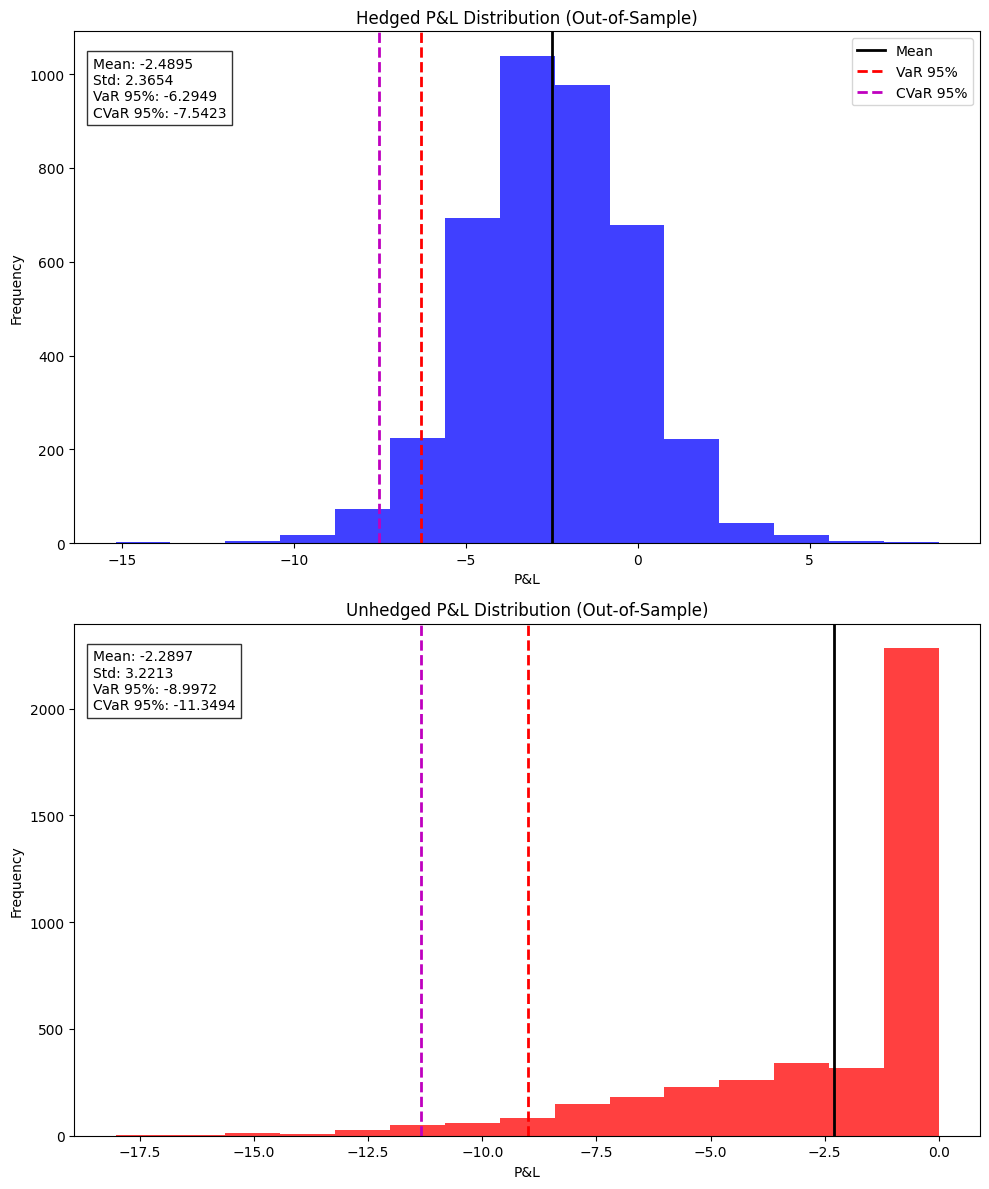

Risk Reduction from Hedging:
VaR Improvement: -2.7023
CVaR Improvement: -3.8071
Std Dev Reduction: 0.8559
---------------------------


In [11]:
N_PATHS = [1000, 4000]
for n_paths in N_PATHS:

    print(f'now n_paths = {n_paths} are in consideration')
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)

    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

# A2C

## A2C 1 (BAD)

In [16]:
from stable_baselines3 import A2C

this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 109.1857
  Variance: 0.023640
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.1618
  Current PnL: -9.1857
  Moneyness (S/K): 1.0919
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 109.1857
  Option Payoff: 9.1857
  Portfolio Value: 0.0000
  Hedging Error: -9.1857
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:


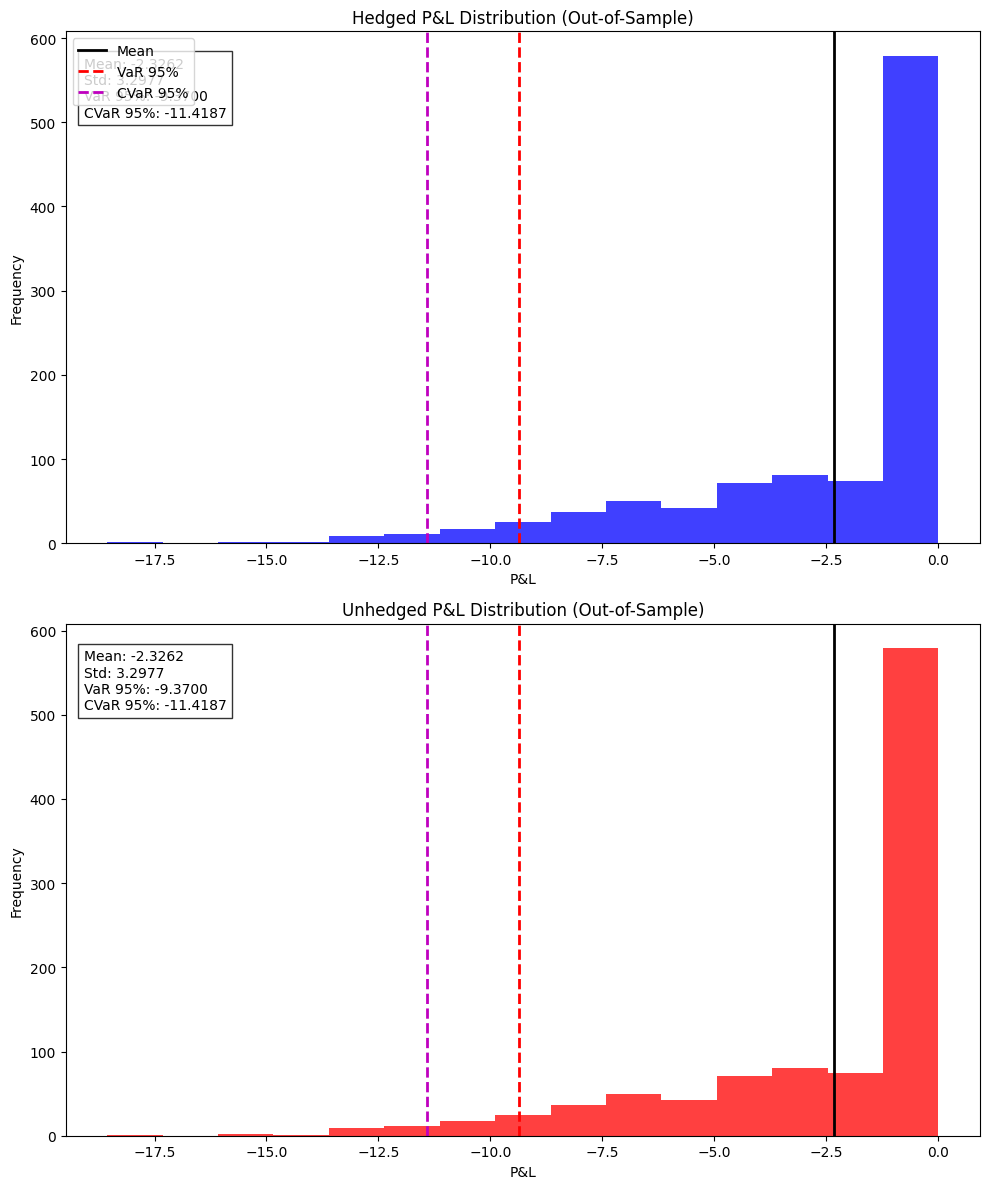

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.6896
  Variance: 0.051400
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 7.1559
  Current PnL: 0.0000
  Moneyness (S/K): 0.9969
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.6896
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Va

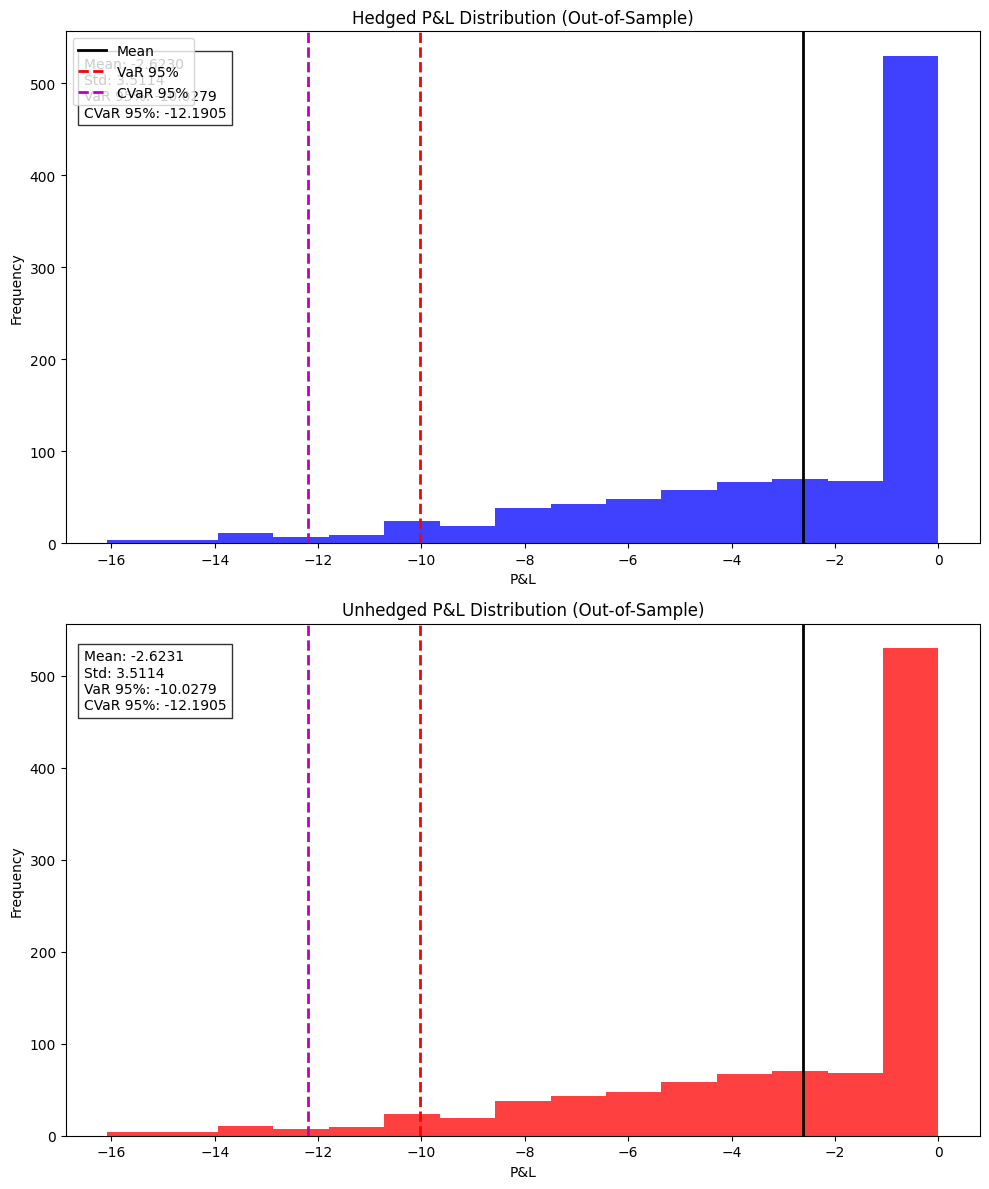

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.1204
  Variance: 0.055791
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.1335
  Current PnL: 0.0000
  Moneyness (S/K): 0.9912
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.1204
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Va

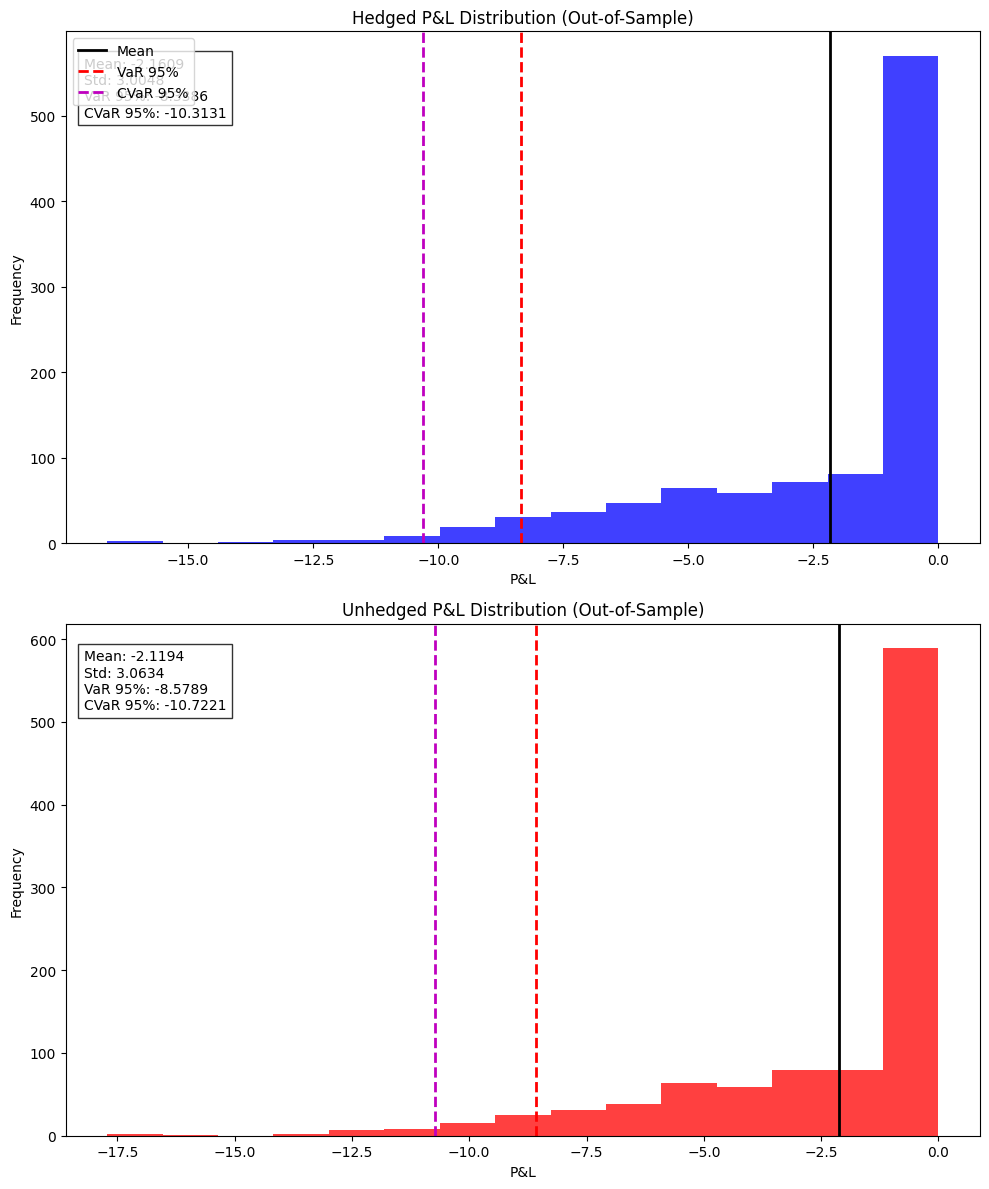

Risk Reduction from Hedging:
VaR Improvement: -0.2403
CVaR Improvement: -0.4089
Std Dev Reduction: 0.0585
---------------------------


In [18]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = A2C(
    policy="MlpPolicy",     
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')


# PPO

## PPO 1 (BAD)

In [19]:
from stable_baselines3 import PPO

In [21]:
device

device(type='cuda')

this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.6329
  Variance: 0.051226
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -0.0896
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.0943
  Current PnL: -0.0896
  Moneyness (S/K): 0.9363
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.6329
  Option Payoff: 0.0000
  Portfolio Value: -0.0896
  Hedging Error: -0.0896
  Total Cost: 0.0196
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/4

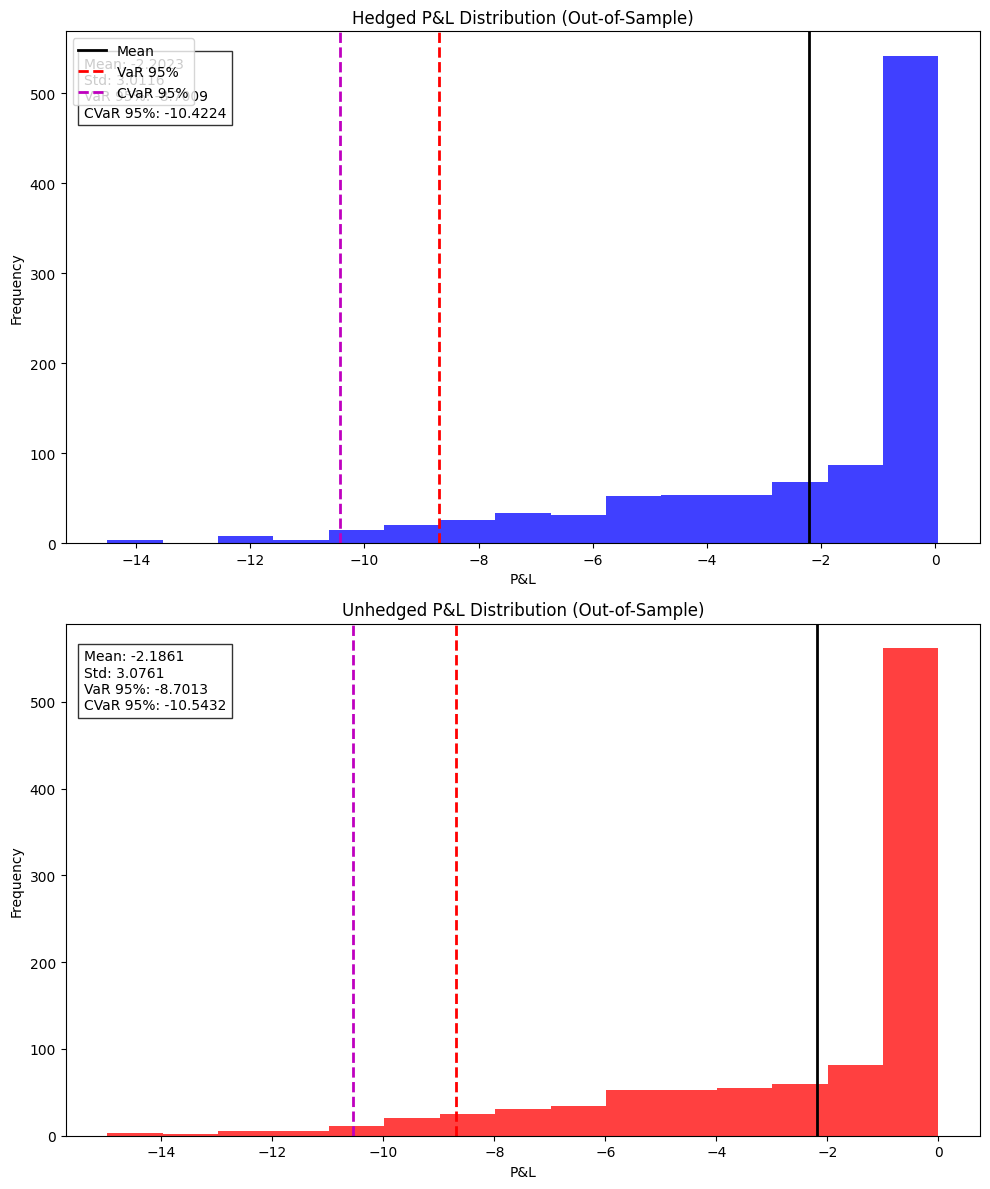

Risk Reduction from Hedging:
VaR Improvement: -0.0004
CVaR Improvement: -0.1208
Std Dev Reduction: 0.0646
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 103.6159
  Variance: 0.025211
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.2183
  Current PnL: -3.6159
  Moneyness (S/K): 1.0362
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 103.6159
  Option Payoff: 3.6159
  Portfolio Value: 0.0000
  Hedging Error: -3.6159
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  

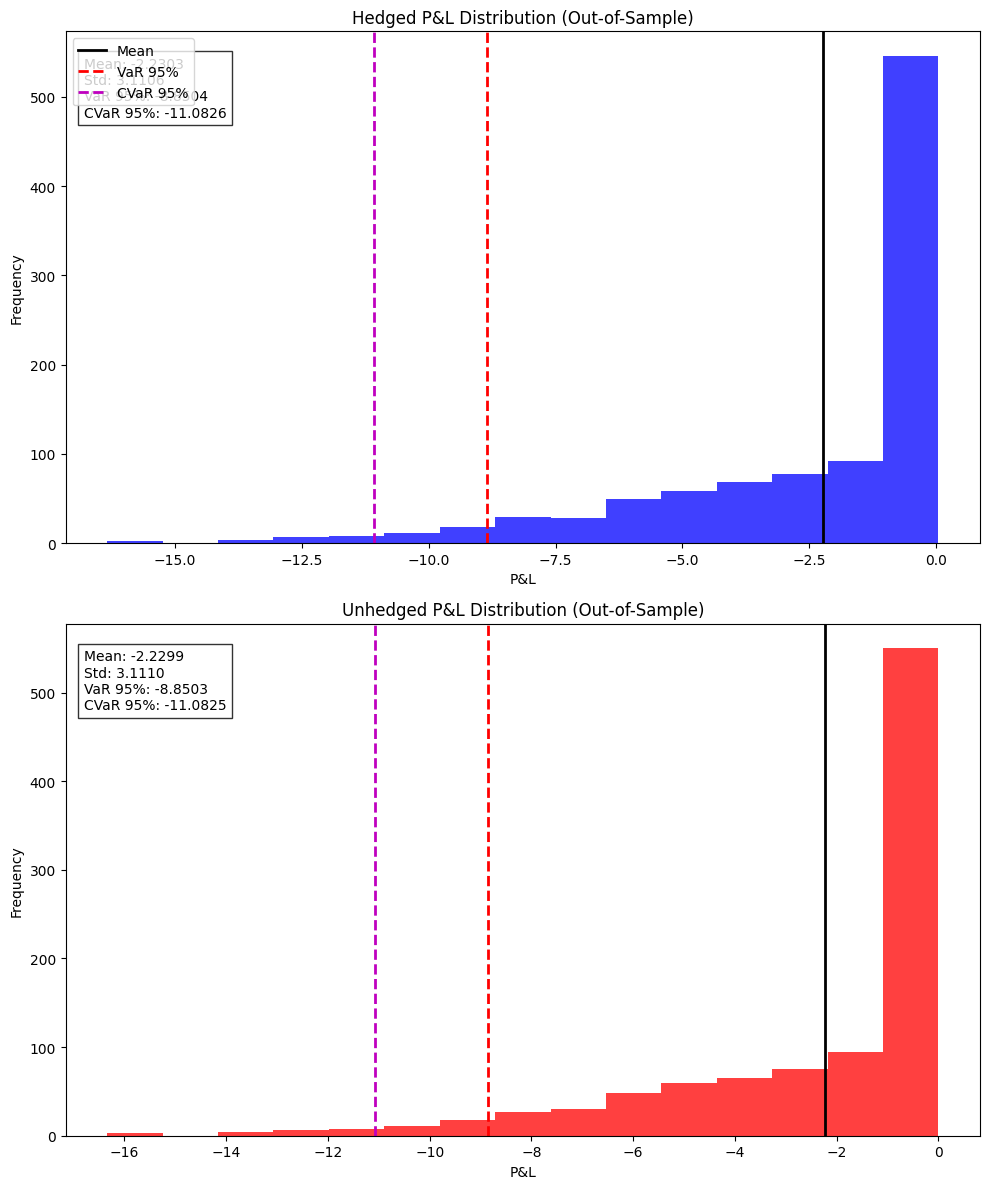

Risk Reduction from Hedging:
VaR Improvement: 0.0001
CVaR Improvement: 0.0001
Std Dev Reduction: 0.0004
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 91.2465
  Variance: 0.025102
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.0764
  Current PnL: 0.0000
  Moneyness (S/K): 0.9125
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 91.2465
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Va

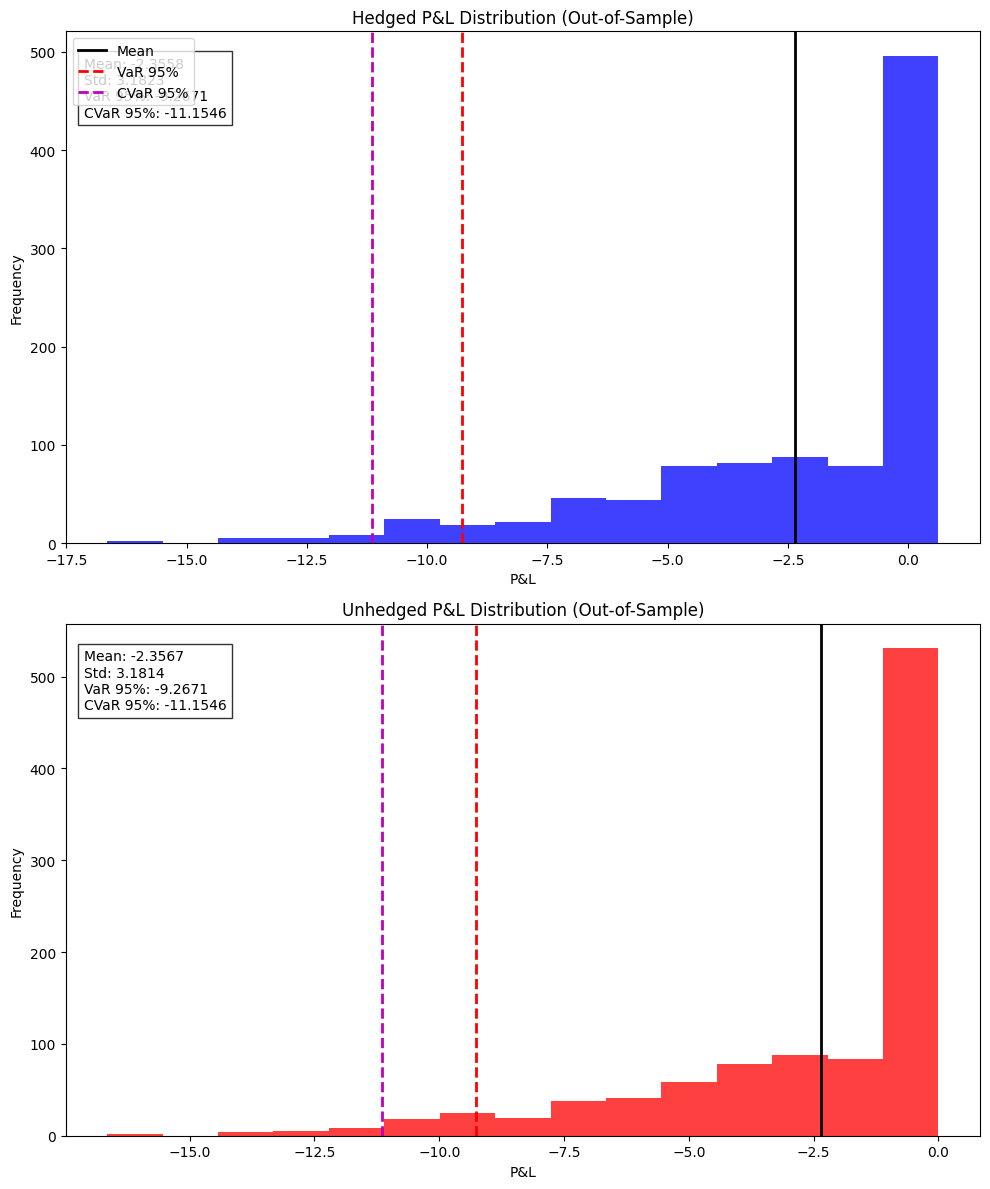

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: -0.0009
---------------------------


In [23]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # PPO model configuration
    model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=12_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')


# SAC

## SAC SIGMA 1 CONST [5, 7, 9]

In [7]:
from stable_baselines3 import SAC

this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 101.9520
  Variance: 0.031394
  Time to Maturity: 0.0000
  Current Position: 0.5220
  Cash Balance: -53.0412
  Rebalancing Day: True
  Transaction Cost: 0.0430
  Reward: 1.0128
  Current PnL: -1.7764
  Moneyness (S/K): 1.0195
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 101.9520
  Option Payoff: 1.9520
  Portfolio Value: 0.1757
  Hedging Error: -1.7764
  Total Cost: 0.2939
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400

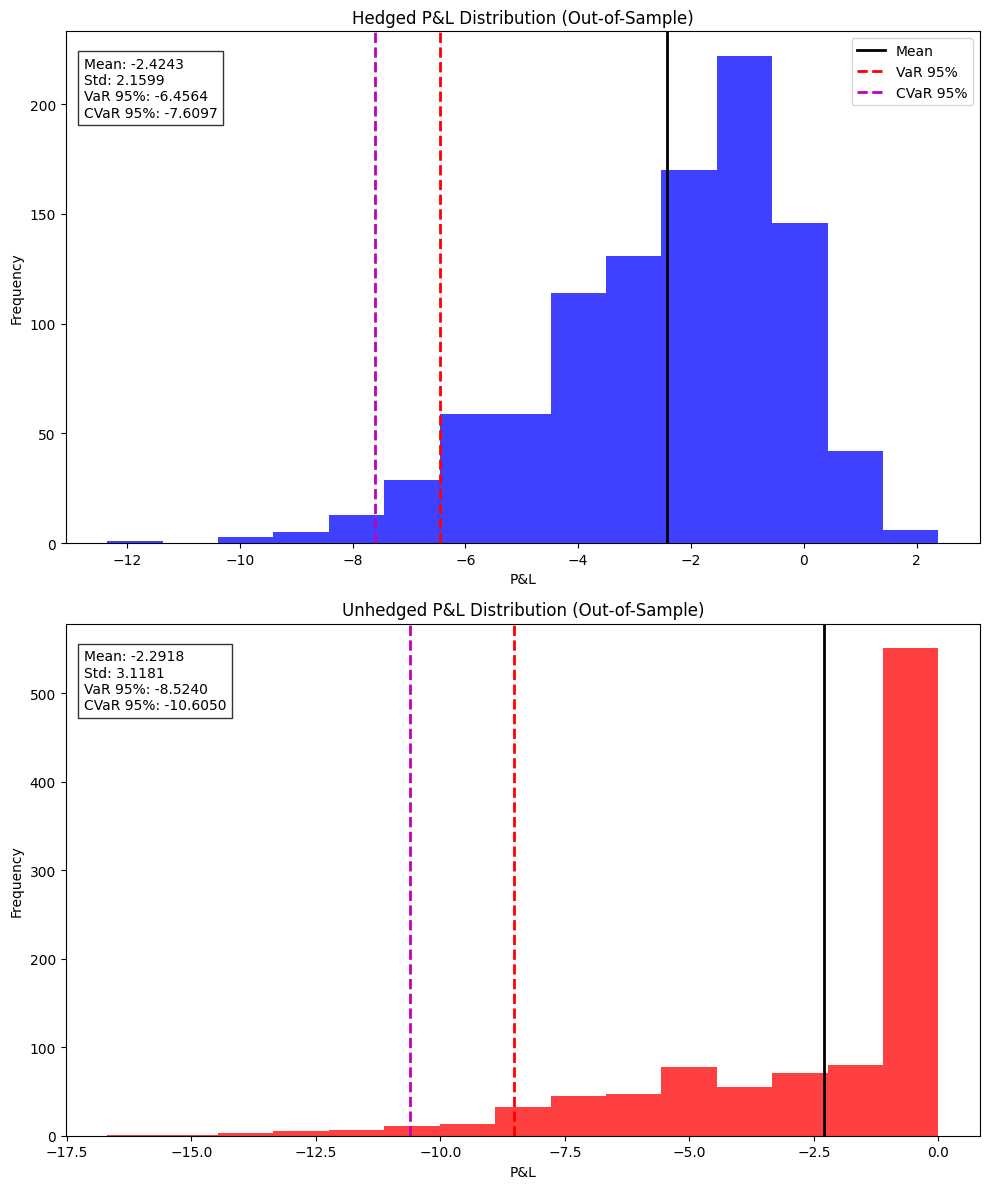

Risk Reduction from Hedging:
VaR Improvement: -2.0676
CVaR Improvement: -2.9954
Std Dev Reduction: 0.9582
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.0344
  Variance: 0.044191
  Time to Maturity: 0.0000
  Current Position: 0.3242
  Cash Balance: -33.5105
  Rebalancing Day: True
  Transaction Cost: 0.0163
  Reward: 1.6592
  Current PnL: -1.7312
  Moneyness (S/K): 0.9803
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.0344
  Option Payoff: 0.0000
  Portfolio Value: -1.7312
  Hedging Error: -1.7312
  Total Cost: 0.2925
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

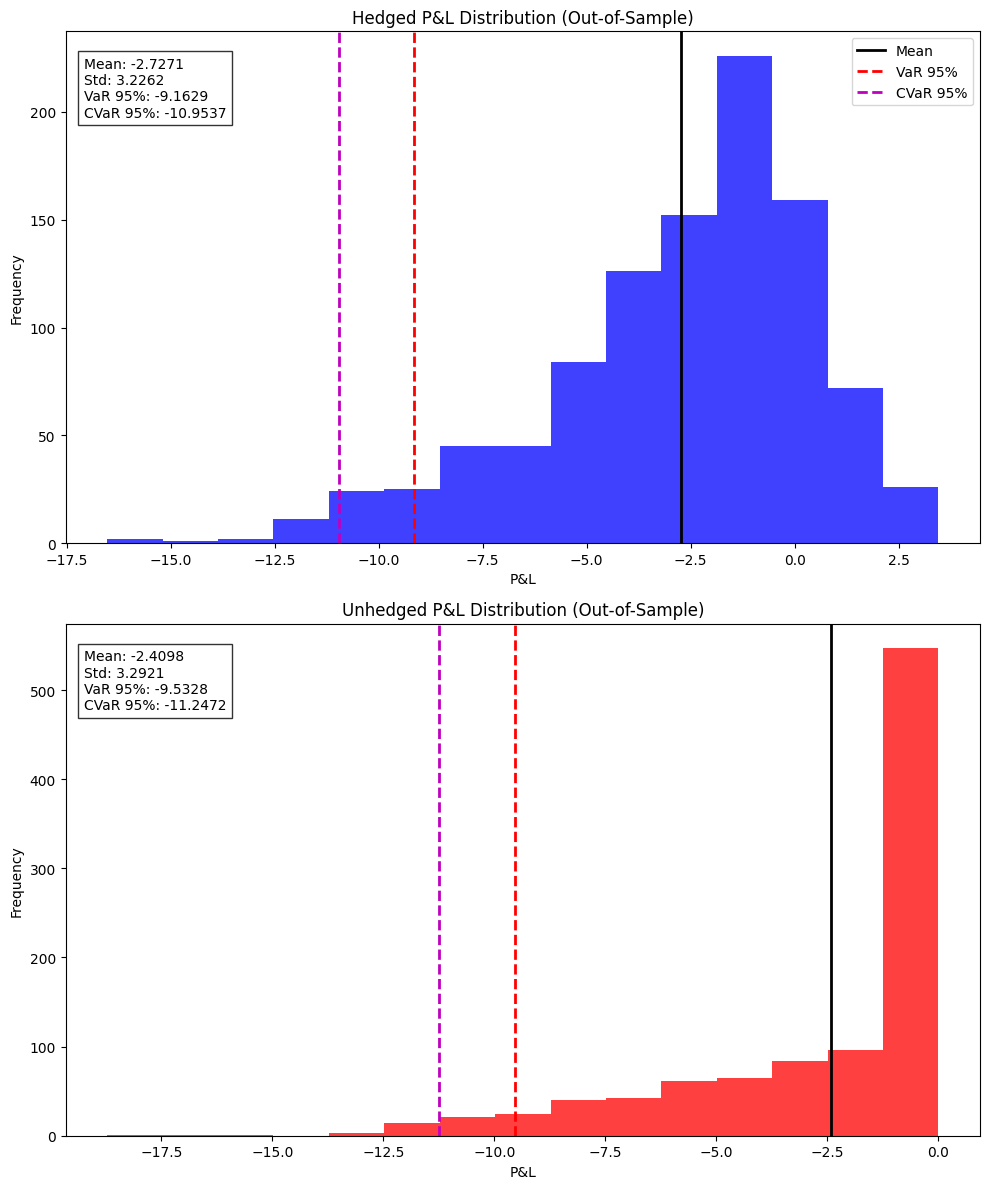

Risk Reduction from Hedging:
VaR Improvement: -0.3699
CVaR Improvement: -0.2935
Std Dev Reduction: 0.0660
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 95.1277
  Variance: 0.048596
  Time to Maturity: 0.0000
  Current Position: 0.4221
  Cash Balance: -41.8220
  Rebalancing Day: True
  Transaction Cost: 0.0072
  Reward: 2.5255
  Current PnL: -1.6689
  Moneyness (S/K): 0.9513
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 95.1277
  Option Payoff: 0.0000
  Portfolio Value: -1.6689
  Hedging Error: -1.6689
  Total Cost: 0.1660
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

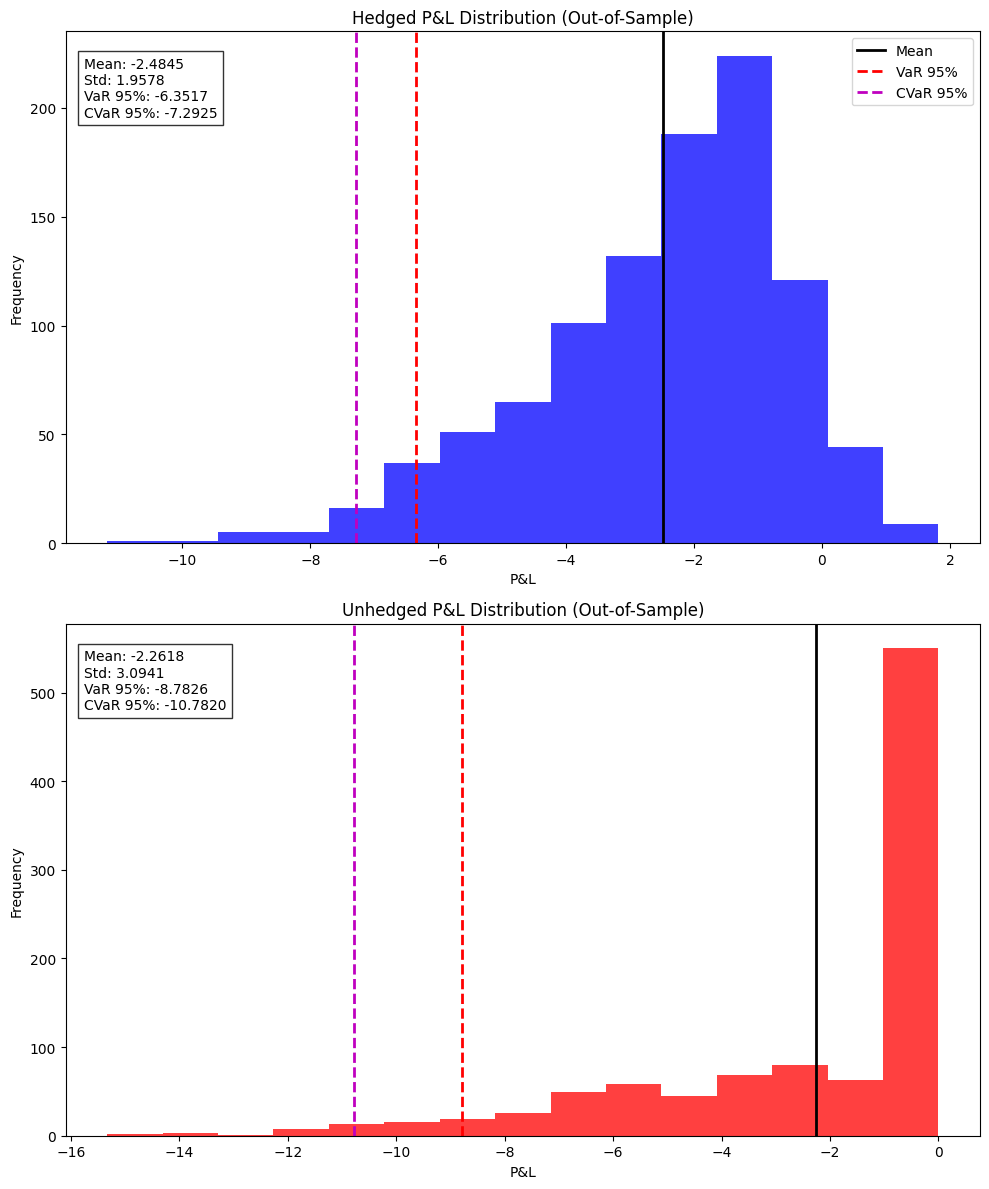

Risk Reduction from Hedging:
VaR Improvement: -2.4309
CVaR Improvement: -3.4895
Std Dev Reduction: 1.1363
---------------------------


In [27]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # SAC model configuration
    model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## SAC (1,9) 10k paths 

this itteration the r_sig = 1, and r_const = 9


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 88.6548
  Variance: 0.065927
  Time to Maturity: 0.0000
  Current Position: 0.1976
  Cash Balance: -22.2812
  Rebalancing Day: True
  Transaction Cost: 0.0090
  Reward: -0.0342
  Current PnL: -4.7649
  Moneyness (S/K): 0.8865
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 88.6548
  Option Payoff: 0.0000
  Portfolio Value: -4.7649
  Hedging Error: -4.7649
  Total Cost: 0.2521
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 97.9017
  Variance: 0.0351

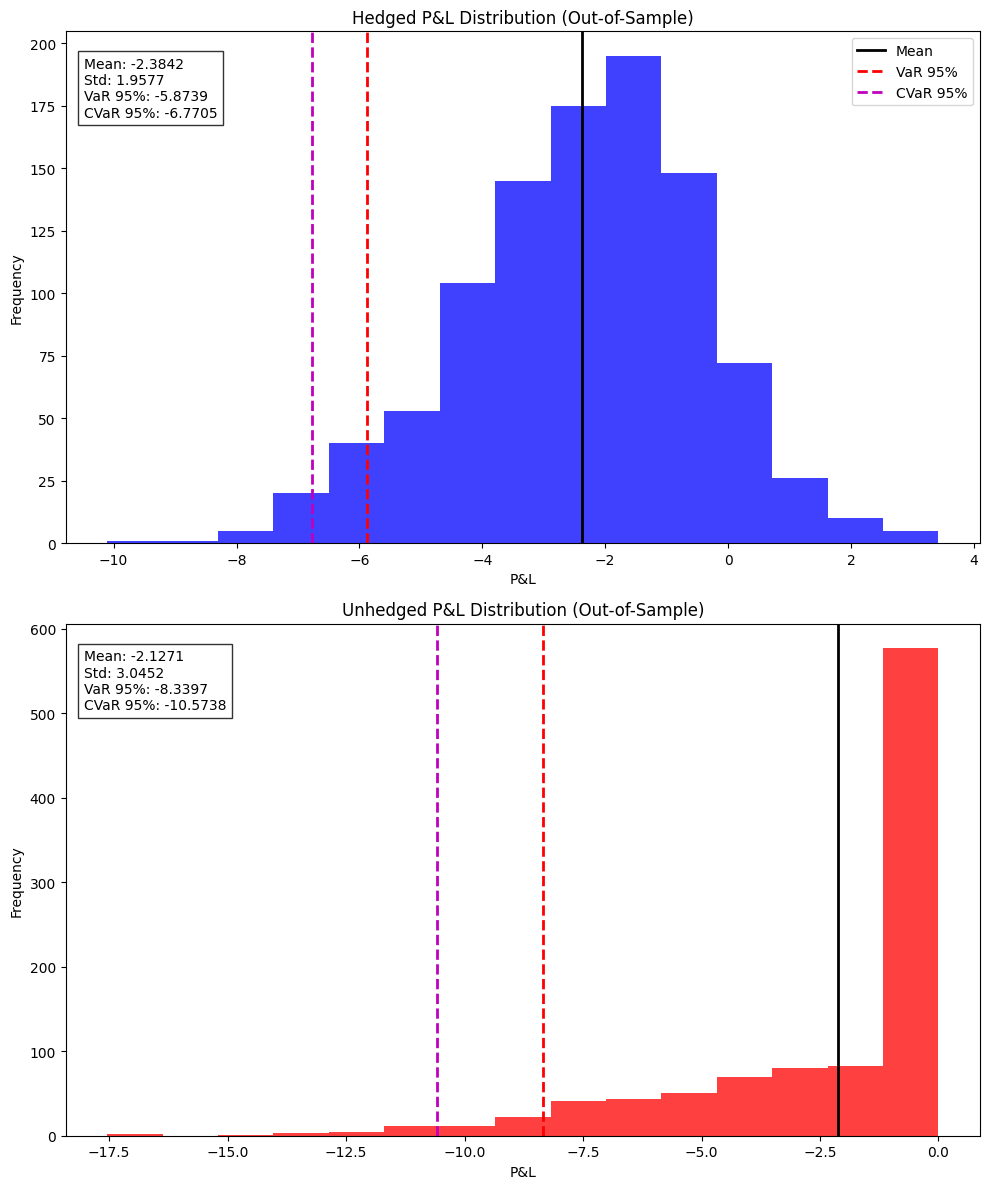

Risk Reduction from Hedging:
VaR Improvement: -2.4658
CVaR Improvement: -3.8033
Std Dev Reduction: 1.0875
---------------------------


In [8]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # SAC model configuration
    model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 102.9188
  Variance: 0.029455
  Time to Maturity: 0.0000
  Current Position: 0.6800
  Cash Balance: -72.0710
  Rebalancing Day: True
  Transaction Cost: 0.0006
  Reward: 0.1590
  Current PnL: -5.0053
  Moneyness (S/K): 1.0292
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 102.9188
  Option Payoff: 2.9188
  Portfolio Value: -2.0866
  Hedging Error: -5.0053
  Total Cost: 0.3096
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 105.5359
  Variance: 0.047121
  Time to Maturity: 0.0000
  Current Position: 0.2925
  Cash Balance: -30.6158
  Rebalancing Day: True
  Transaction Cost: 0.0001
  Reward: 0.5090
  Current PnL: -5.2788
  Mo

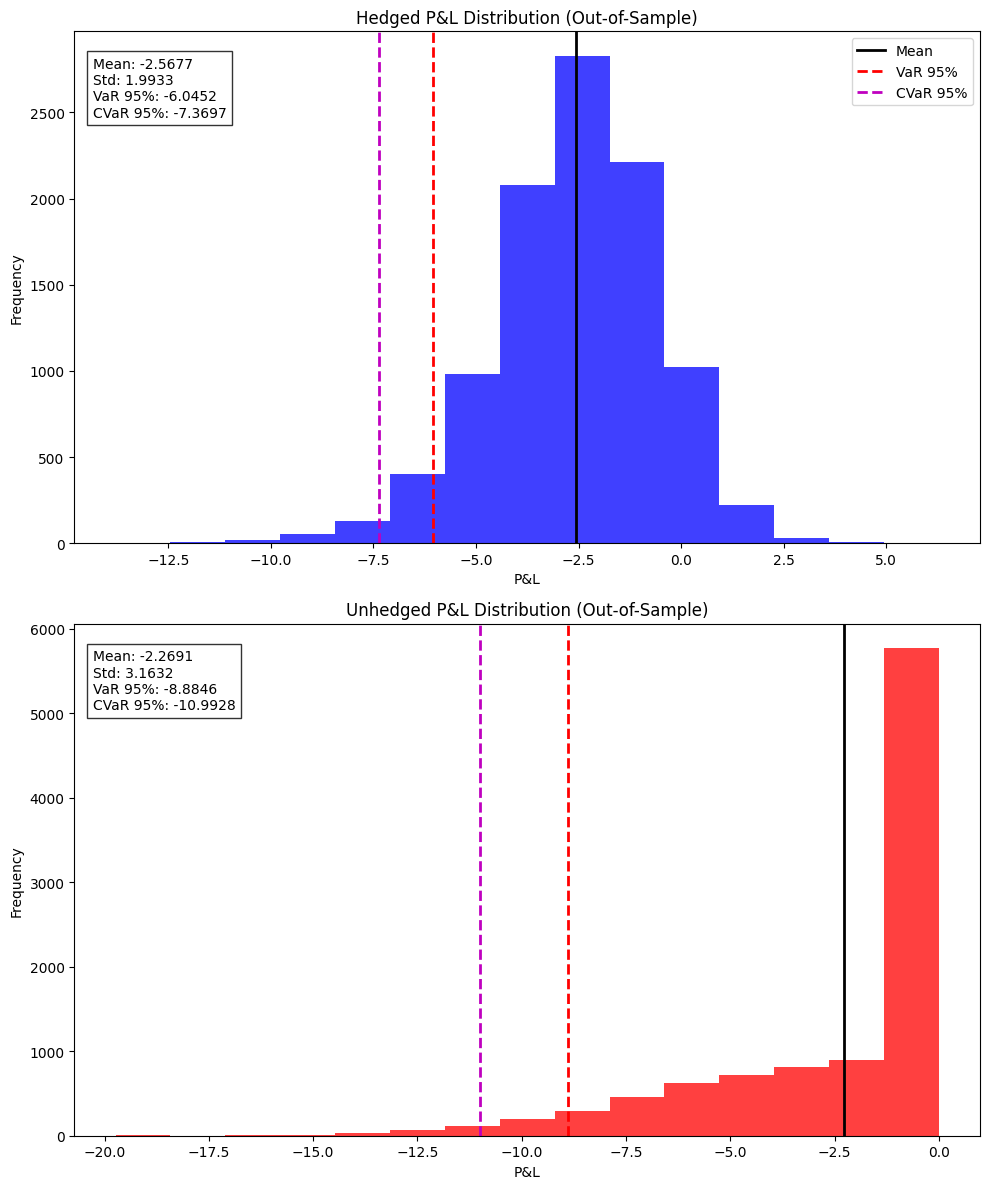

Risk Reduction from Hedging:
VaR Improvement: -2.8394
CVaR Improvement: -3.6231
Std Dev Reduction: 1.1699


In [9]:
eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
n_paths = 10000
pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
plot_pnl_distributions(pnl_dist, unhedged_pnl)

## SAC (0.5, [7, 9])

this itteration the r_sig = 0.5, and r_const = 7


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.3517
  Variance: 0.053671
  Time to Maturity: 0.0000
  Current Position: 0.5617
  Cash Balance: -53.8595
  Rebalancing Day: True
  Transaction Cost: 0.0351
  Reward: -0.3329
  Current PnL: -1.4239
  Moneyness (S/K): 0.9335
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.3517
  Option Payoff: 0.0000
  Portfolio Value: -1.4239
  Hedging Error: -1.4239
  Total Cost: 0.2245
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.2654
  Variance: 0.0211

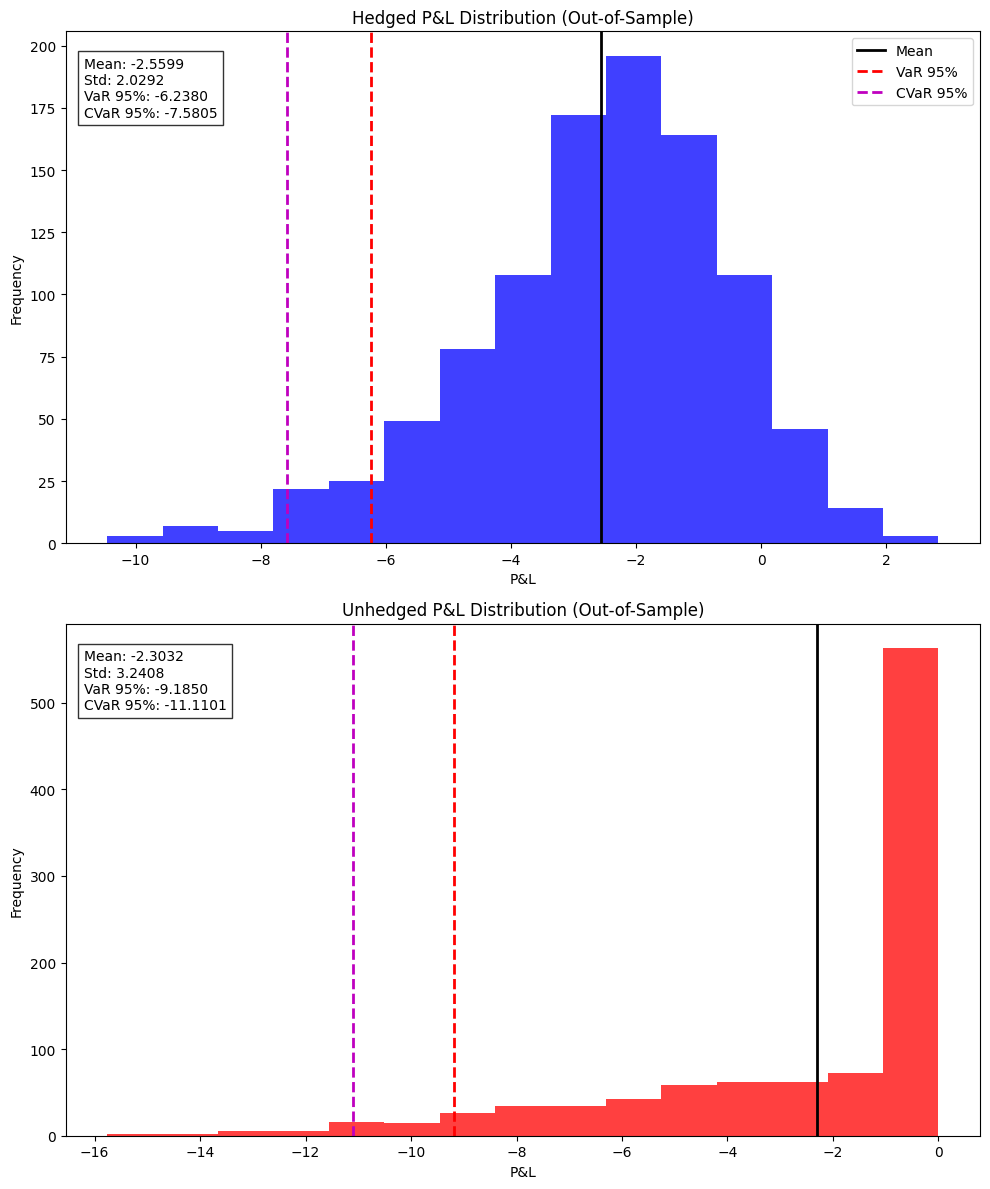

Risk Reduction from Hedging:
VaR Improvement: -2.9470
CVaR Improvement: -3.5296
Std Dev Reduction: 1.2116
---------------------------
this itteration the r_sig = 0.5, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 100.4628
  Variance: 0.039678
  Time to Maturity: 0.0000
  Current Position: 0.9758
  Cash Balance: -97.4415
  Rebalancing Day: True
  Transaction Cost: 0.0173
  Reward: 8.8140
  Current PnL: 0.1269
  Moneyness (S/K): 1.0046
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 100.4628
  Option Payoff: 0.4628
  Portfolio Value: 0.5897
  Hedging Error: 0.1269
  Total Cost: 0.1724
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000


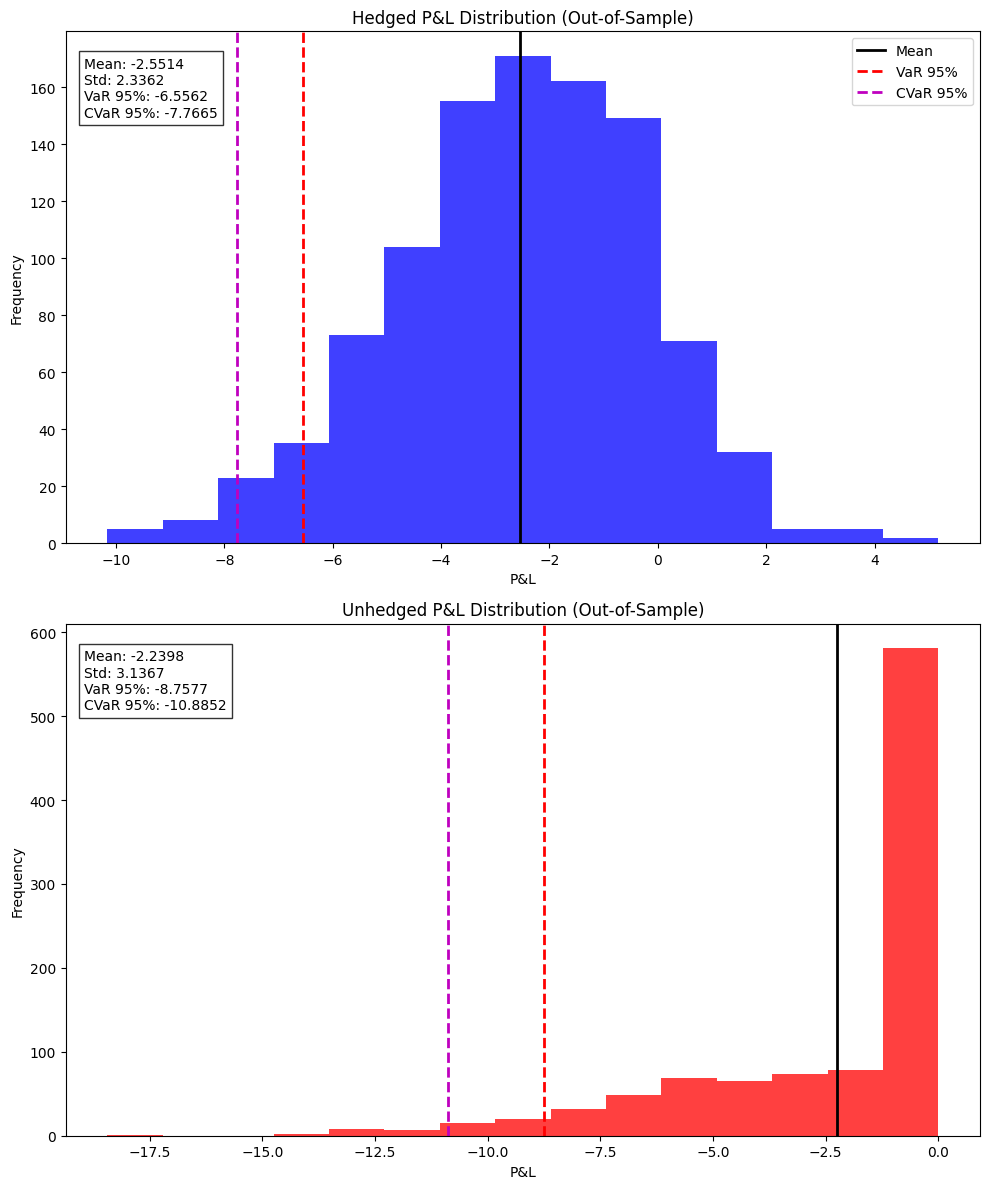

Risk Reduction from Hedging:
VaR Improvement: -2.2015
CVaR Improvement: -3.1186
Std Dev Reduction: 0.8005
---------------------------


In [10]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # SAC model configuration
    model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## SAC (0.5, 7) 10k paths

this itteration the r_sig = 0.5, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.3682
  Variance: 0.042906
  Time to Maturity: 0.0000
  Current Position: 0.2652
  Cash Balance: -27.9096
  Rebalancing Day: True
  Transaction Cost: 0.0073
  Reward: 0.0286
  Current PnL: -2.3510
  Moneyness (S/K): 0.9637
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.3682
  Option Payoff: 0.0000
  Portfolio Value: -2.3510
  Hedging Error: -2.3510
  Total Cost: 0.2496
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.4665
  Variance: 0.042381
  Time to Maturity: 0.0000
  Current Position: 0.5331
  Cash Balance: -53.1125
  Rebalancing Day: True
  Transaction Cost: 0

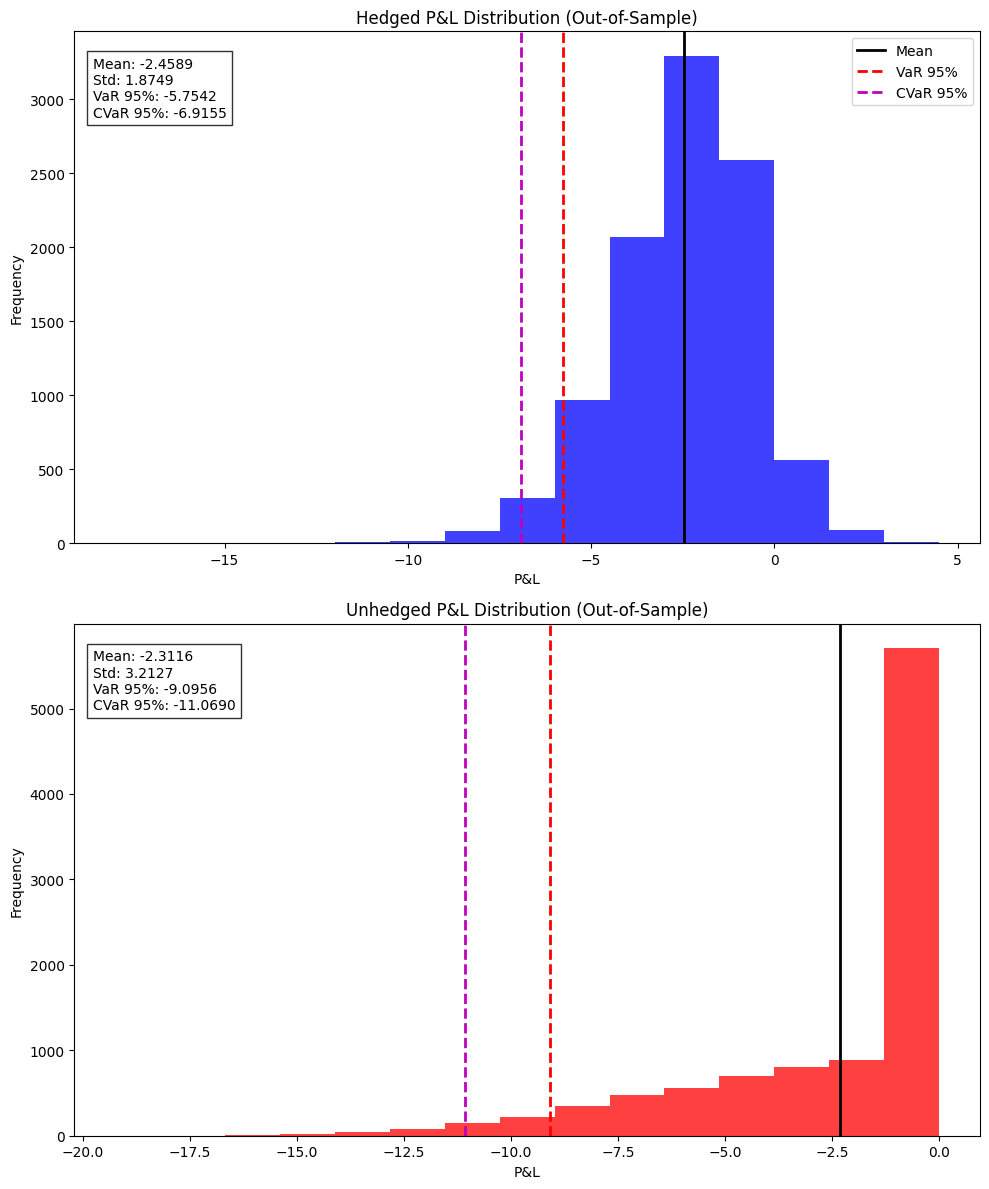

Risk Reduction from Hedging:
VaR Improvement: -3.3414
CVaR Improvement: -4.1535
Std Dev Reduction: 1.3378
---------------------------


In [11]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # SAC model configuration
    model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 10000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

# DDPG

## DDPG SIGMA 1 CONST [5, 7, 9]

In [6]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

this itteration the r_sig = 1, and r_const = 5


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.9293
  Variance: 0.023352
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 4.9440
  Current PnL: -0.1707
  Moneyness (S/K): 0.9993
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.9293
  Option Payoff: 0.0000
  Portfolio Value: -0.1707
  Hedging Error: -0.1707
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 108.3043
  Variance: 0.019

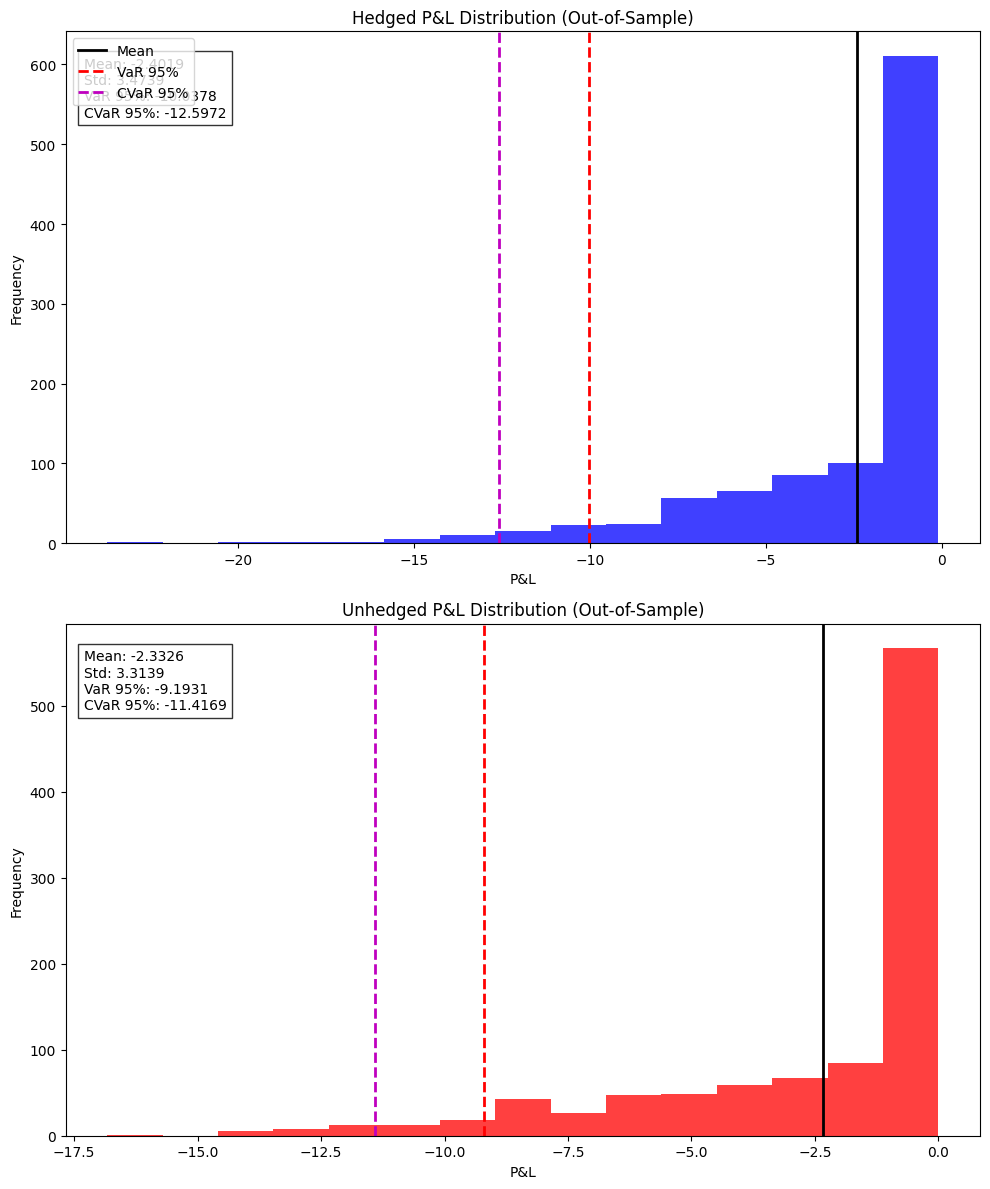

Risk Reduction from Hedging:
VaR Improvement: 0.8448
CVaR Improvement: 1.1802
Std Dev Reduction: -0.1600
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.0686
  Variance: 0.051796
  Time to Maturity: 0.0000
  Current Position: 0.2054
  Cash Balance: -22.4353
  Rebalancing Day: True
  Transaction Cost: 0.0294
  Reward: 0.1822
  Current PnL: -2.7020
  Moneyness (S/K): 0.9607
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.0686
  Option Payoff: 0.0000
  Portfolio Value: -2.7020
  Hedging Error: -2.7020
  Total Cost: 0.3586
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.000

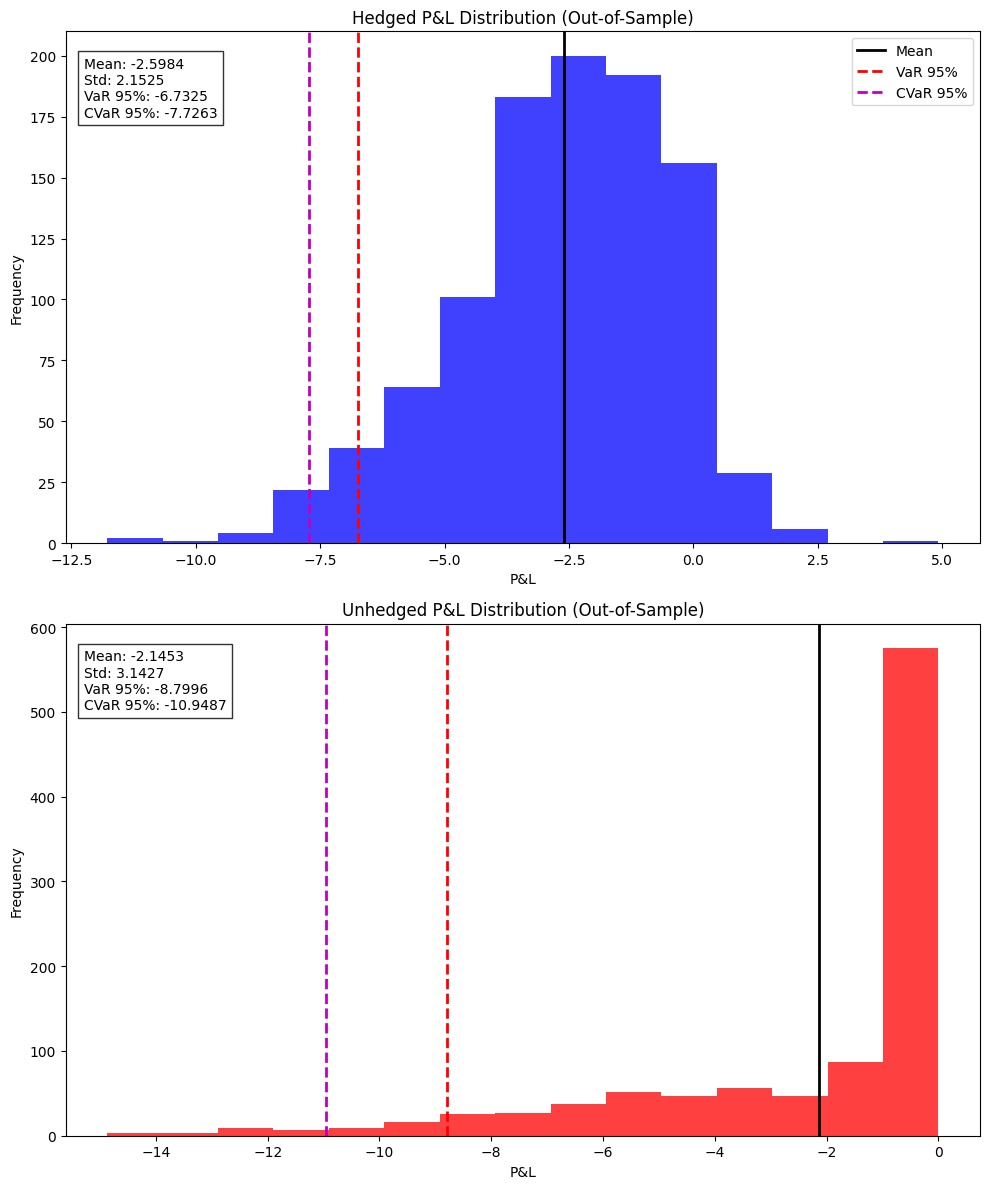

Risk Reduction from Hedging:
VaR Improvement: -2.0671
CVaR Improvement: -3.2224
Std Dev Reduction: 0.9903
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 97.2405
  Variance: 0.026491
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.0890
  Current PnL: 0.0000
  Moneyness (S/K): 0.9724
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 97.2405
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  

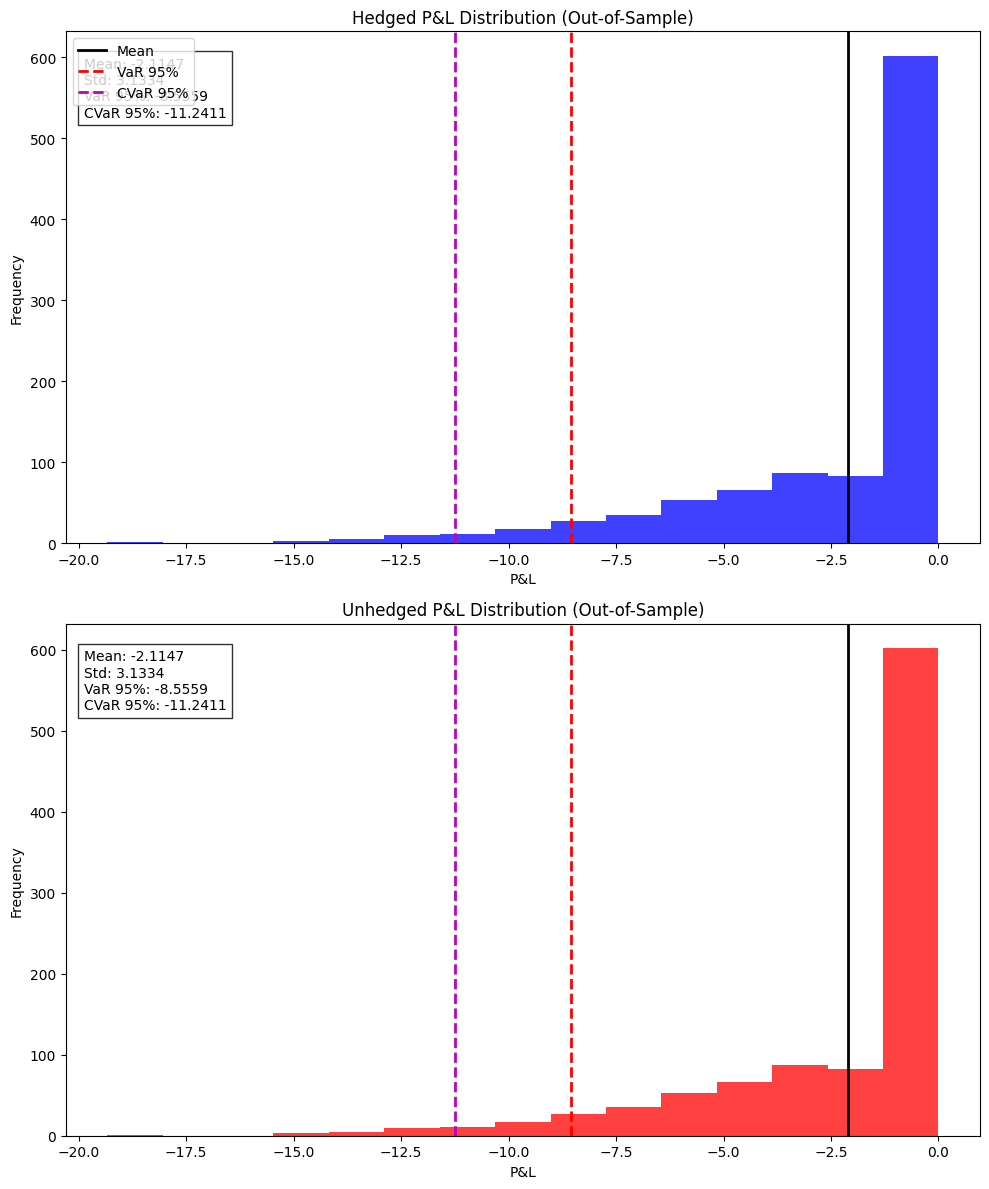

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------


In [9]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])

    # Define action noise for exploration
    n_actions = env.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.1 * np.ones(n_actions),
    theta=0.15
    )
    
    model = DDPG(
    policy="MlpPolicy",
    env=env,
    action_noise=action_noise,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## DDPG TO DIPLOMA

this itteration the r_sig = 0.5, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 90.8393
  Variance: 0.056319
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.1114
  Current PnL: 0.0000
  Moneyness (S/K): 0.9084
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 90.8393
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400

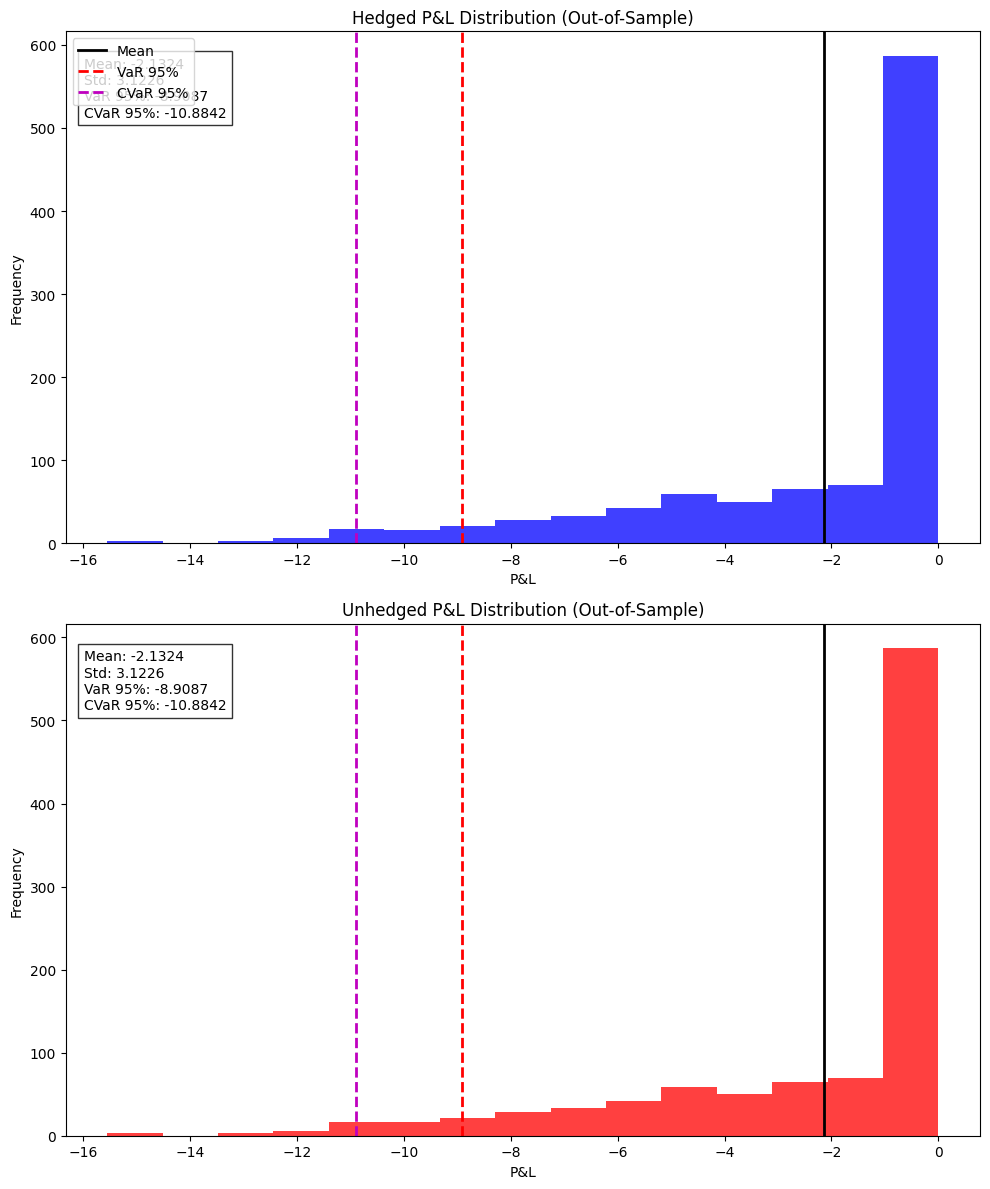

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 0.5, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 92.7497
  Variance: 0.060382
  Time to Maturity: 0.0000
  Current Position: 0.9754
  Cash Balance: -93.5604
  Rebalancing Day: True
  Transaction Cost: 0.0011
  Reward: -0.0011
  Current PnL: -3.0950
  Moneyness (S/K): 0.9275
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 92.7497
  Option Payoff: 0.0000
  Portfolio Value: -3.0950
  Hedging Error: -3.0950
  Total Cost: 0.2407
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0

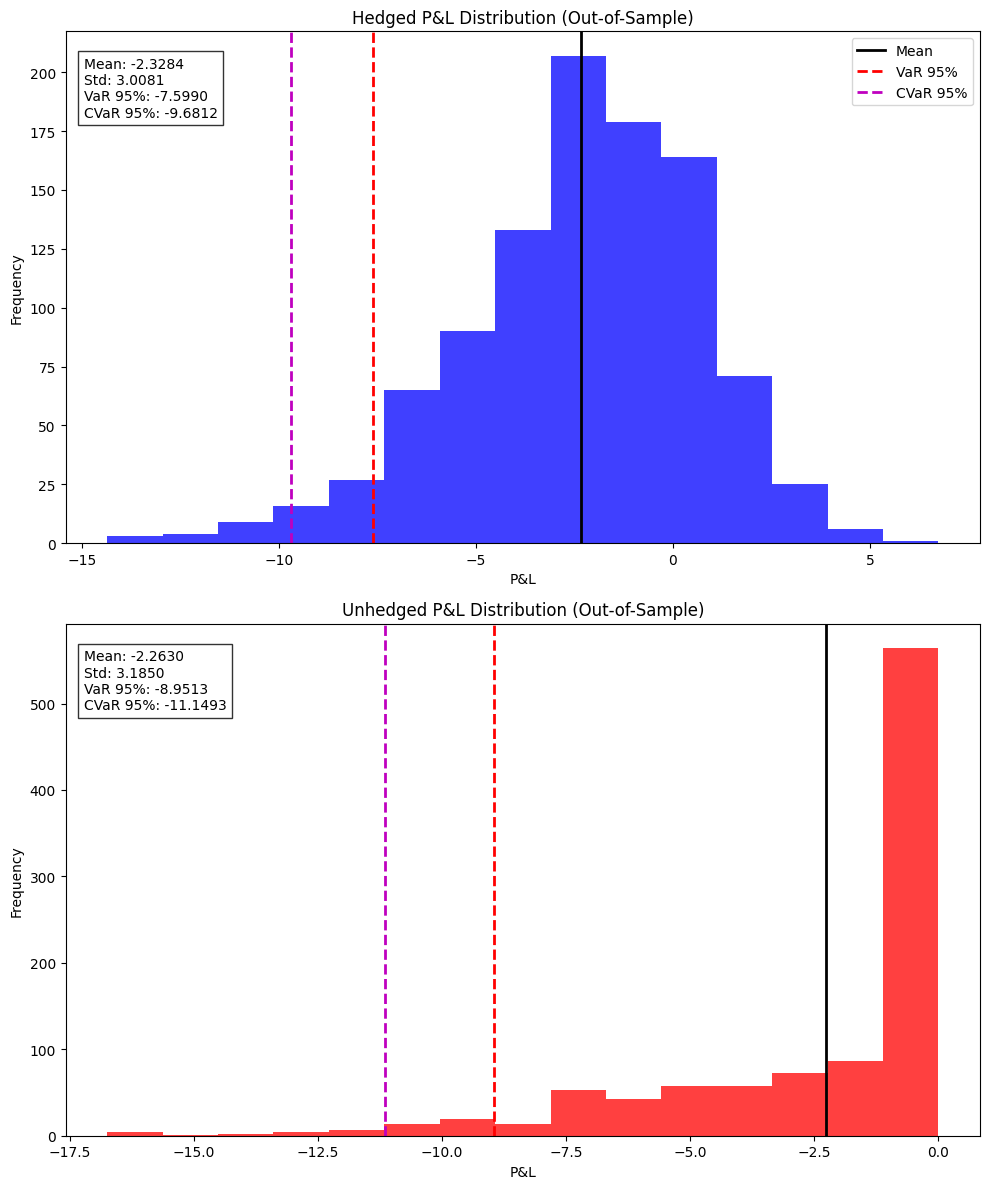

Risk Reduction from Hedging:
VaR Improvement: -1.3523
CVaR Improvement: -1.4681
Std Dev Reduction: 0.1769
---------------------------
this itteration the r_sig = 0.5, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 87.5201
  Variance: 0.071164
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 9.1169
  Current PnL: 0.0000
  Moneyness (S/K): 0.8752
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 87.5201
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000


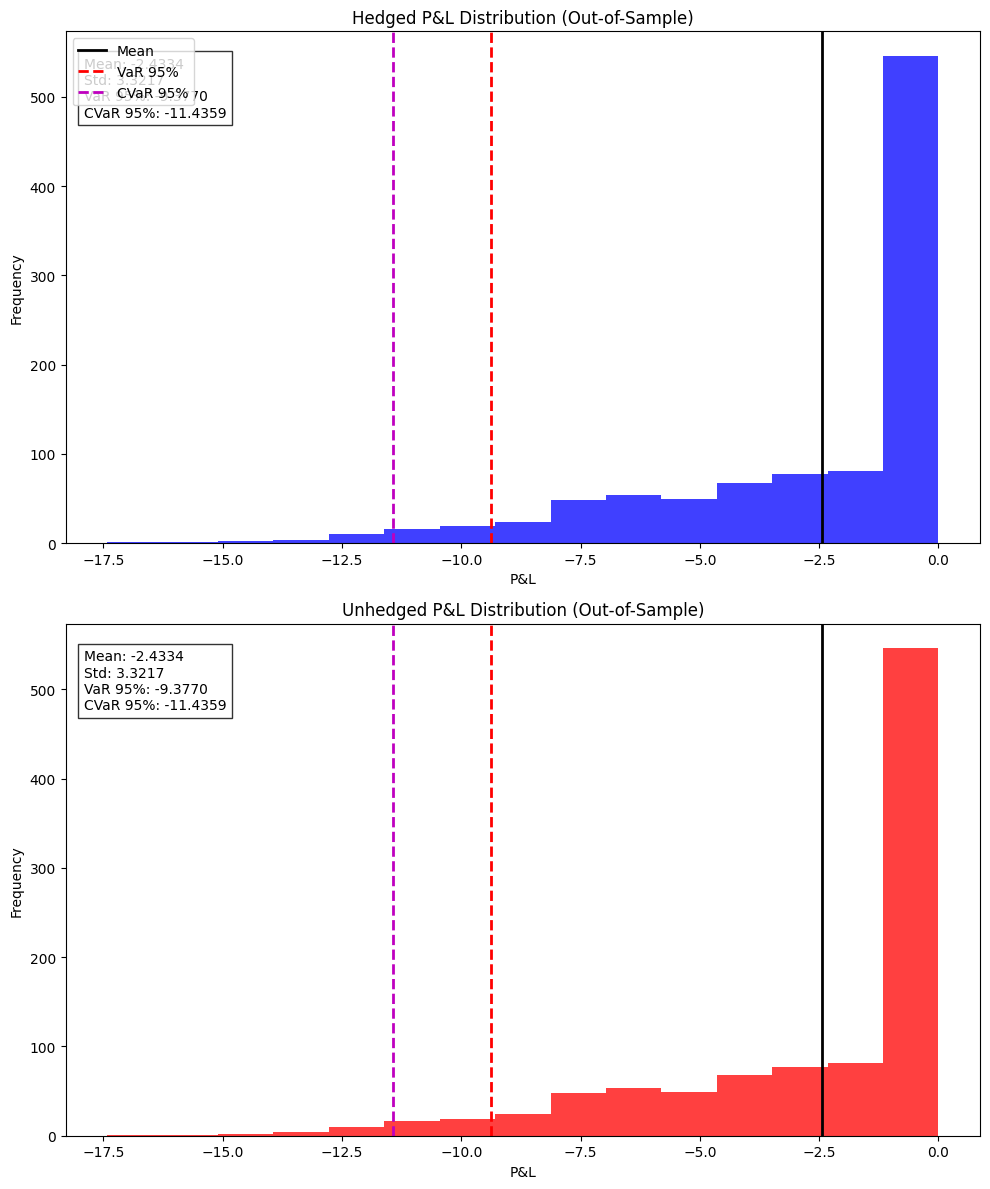

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------


In [22]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # Define action noise for exploration
    n_actions = env.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.1 * np.ones(n_actions),
    theta=0.15
    )
    
    model = DDPG(
    policy="MlpPolicy",
    env=env,
    action_noise=action_noise,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

this itteration the r_sig = 0.5, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.6728
  Variance: 0.024276
  Time to Maturity: 0.0000
  Current Position: 0.9112
  Cash Balance: -92.5265
  Rebalancing Day: True
  Transaction Cost: 0.0039
  Reward: 0.0604
  Current PnL: -2.6136
  Moneyness (S/K): 0.9867
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.6728
  Option Payoff: 0.0000
  Portfolio Value: -2.6136
  Hedging Error: -2.6136
  Total Cost: 0.1314
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 39

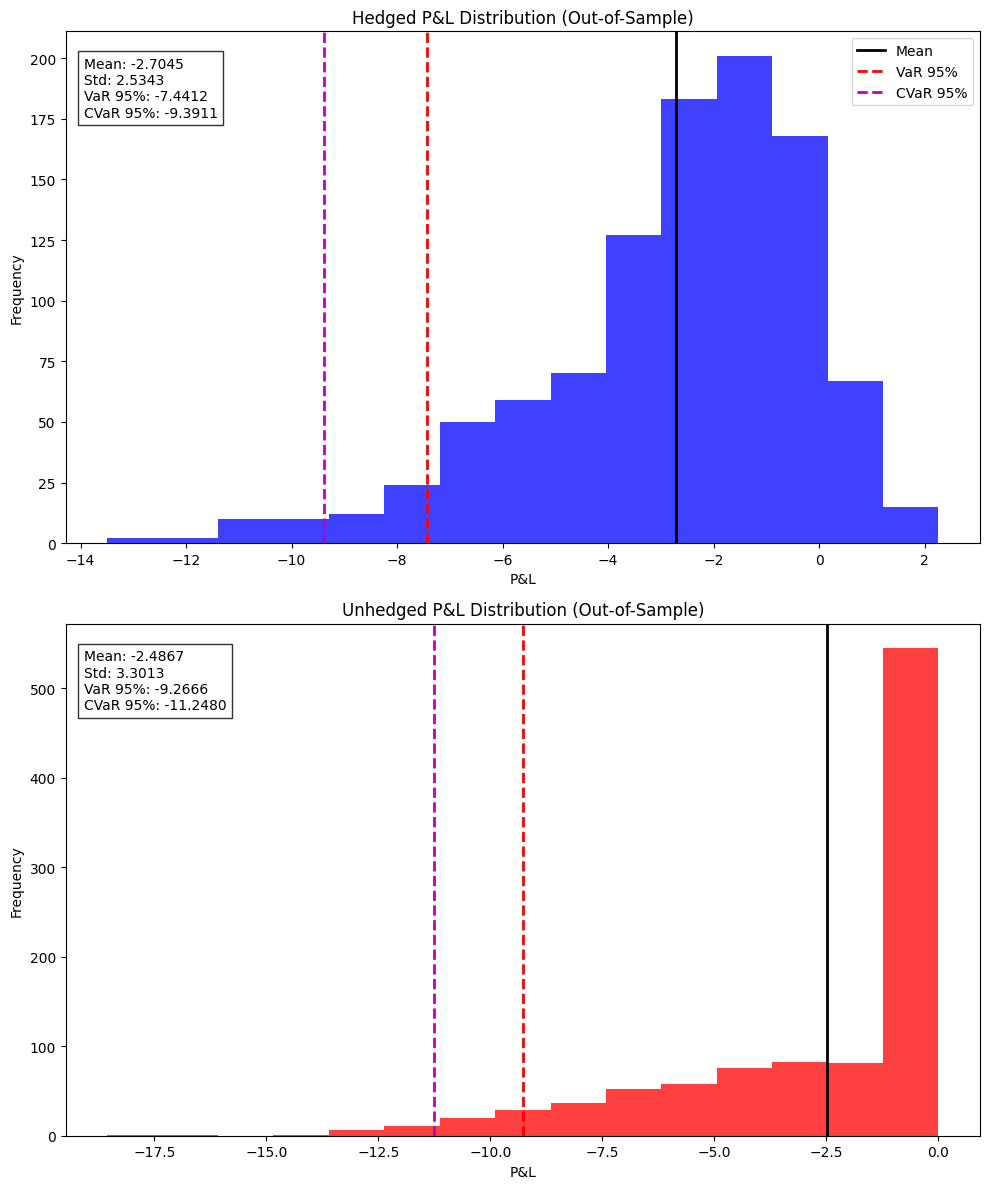

Risk Reduction from Hedging:
VaR Improvement: -1.8254
CVaR Improvement: -1.8569
Std Dev Reduction: 0.7670
---------------------------


In [24]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [7]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    # Define action noise for exploration
    n_actions = env.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.1 * np.ones(n_actions),
    theta=0.15
    )
    
    model = DDPG(
    policy="MlpPolicy",
    env=env,
    action_noise=action_noise,
    verbose=0,
    device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

now n_paths = 10000 are in consideration
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 90.9426
  Variance: 0.071976
  Time to Maturity: 0.0000
  Current Position: 0.0740
  Cash Balance: -10.4093
  Rebalancing Day: True
  Transaction Cost: 0.0299
  Reward: -0.3153
  Current PnL: -3.6752
  Moneyness (S/K): 0.9094
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 90.9426
  Option Payoff: 0.0000
  Portfolio Value: -3.6752
  Hedging Error: -3.6752
  Total Cost: 0.4540
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 107.2011
  Variance: 0.018609
  Time to Maturity: 0.0000
  Current Position: 0.4047
  Cash Balance: -39.8097
  Rebalancing Day: True
  Transaction Cost: 0.0304


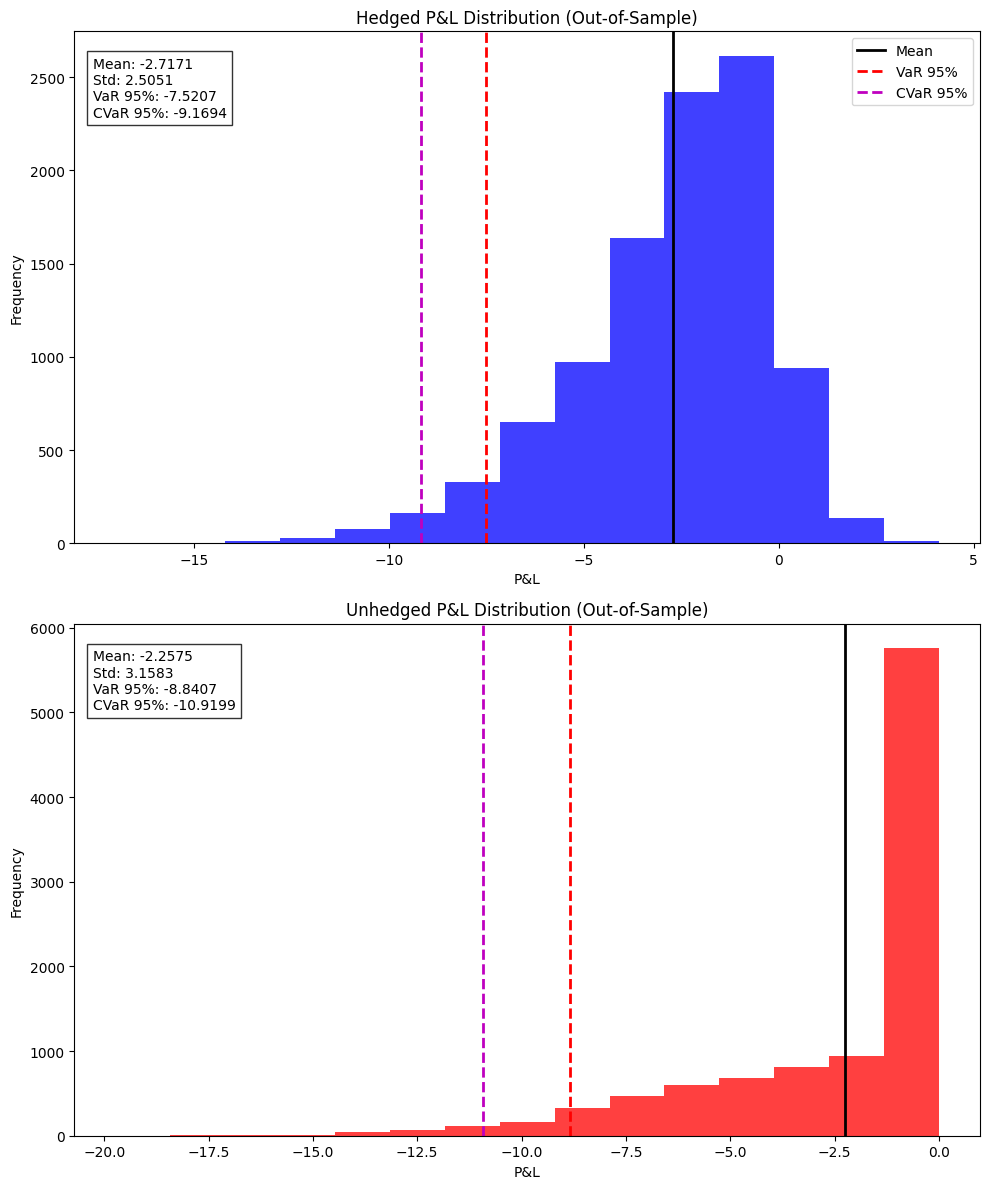

Risk Reduction from Hedging:
VaR Improvement: -1.3200
CVaR Improvement: -1.7505
Std Dev Reduction: 0.6531
---------------------------


In [25]:
N_PATHS = [10000]
for n_paths in N_PATHS:

    print(f'now n_paths = {n_paths} are in consideration')
    
    eval_env = HestonHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)

    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

# Utils

In [ ]:
# reward plot

# Define the pnl range
pnl = np.linspace(-10, 10, 500)

# Parameters for each subplot
sigmas = [0.5, 1.0, 2.0, 3.0]
alpha_fixed = 10
alphas = [5, 10, 12, 14]
sigma_fixed = 2.0

# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: varying sigma
ax = axes[0]
for sigma in sigmas:
    reward = alpha_fixed * np.exp(-pnl**2 / (2 * sigma**2))
    ax.plot(pnl, reward, label=f'σ = {sigma}')
ax.set_title('Reward vs PnL for Different σ (c = 5)')
ax.set_xlabel('PnL')
ax.set_ylabel('Reward R_T')
# ax.grid(True)
ax.legend()

# Right plot: varying c (α)
ax = axes[1]
for c in alphas:
    reward = c * np.exp(-pnl**2 / (2 * sigma_fixed**2))
    ax.plot(pnl, reward, label=f'c = {c}')
ax.set_title('Reward vs PnL for Different c (σ = 2)')
ax.set_xlabel('PnL')
ax.legend()

# plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
def call_option(S_paths, K, r=0.0, T=1/12):
    # take the terminal prices (last column)
    ST = S_paths[-1]
    # payoff per path
    payoffs = np.maximum(ST - K, 0.0)
    # average and discount back to today
    return np.exp(-r * T) * np.mean(payoffs)

# simulate
S, v, time = heston_model_sim(
    S0=100, V0=0.04, rho=-0.7, theta=0.04, sigma=0.28, kappa=1.0,
    r=0.00, q=0.00, T=1/12, n_paths=10000, n_steps=400, SEED=None
)

price = call_option(S, K=100, r=0.00, T=1/12)
print(f"Call option price ≃ {price:.4f}")

Call option price ≃ 2.2993


## Quantlib pricer 

In [25]:
# pip install QuantLib==1.37

In [24]:
# import QuantLib as ql

In [ ]:
# Parameters initialization 
spot_price = 100.0     # Underlying spot price
strike_price = 100.0   # Strike price of the option
risk_free_rate = 0.00  # Risk-free rate (0%)
dividend_yield = 0.0   # No dividends
expiry = 30 / 365      # 30 days until expiry

v0 = 0.04              # Initial variance
kappa = 1.0            # Mean-reversion speed
theta = 0.04           # Long-run variance
sigma = 0.28           # Volatility of volatility
rho = -0.7             # Correlation between asset price and volatility

# Creation of QuantLib objects
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(ql.Date().todaysDate(), ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), ql.Actual360()))
dividend_handle = ql.YieldTermStructureHandle(ql.FlatForward(ql.Date().todaysDate(), ql.QuoteHandle(ql.SimpleQuote(dividend_yield)), ql.Actual360()))

# Heston process and Pricing engine initialization
heston_process = ql.HestonProcess(rate_handle, dividend_handle, spot_handle, v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_engine = ql.AnalyticHestonEngine(heston_model)

# Define European Call Option
option_type = ql.Option.Call
payoff = ql.PlainVanillaPayoff(option_type, strike_price)

maturity_date = ql.Date().todaysDate() + ql.Period(30, ql.Days)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

# Risk-neutral Pricing
european_option.setPricingEngine(heston_engine)
option_price = european_option.NPV()
print(f"Option Price: {option_price:.4f}")

Resulting output: `Option Price: 2.2852`

(output in md as this code ran in colab and the quantlib library was not installed in the Kaggle environment, can be accessed here https://colab.research.google.com/drive/1Y8RThSW0IbJdd8941xmOAtyt7LsrO7z-?usp=sharing)